## このノートブックの流れ

1.003～006までの特徴量を結合

2.いろいろ削ったり入れたり。

3.Optunaを使ってみたりした。

In [176]:
%matplotlib inline                      

import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import time
import pickle
import gc

In [138]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [139]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice
data = pd.read_csv('../house price/004_data.csv')

In [140]:
nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']

In [141]:
train['SalePrice'] = np.log(train['SalePrice'])

In [142]:
alldata = pd.concat([train, test], sort=False)
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


## 欠損値補完

In [143]:
alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)

In [144]:
alldata.shape

(2919, 81)

In [145]:
alldata.SalePrice

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1454          NaN
1455          NaN
1456          NaN
1457          NaN
1458          NaN
Name: SalePrice, Length: 2919, dtype: float64

In [146]:
alldata2 = alldata

# 003～006までの特徴量をimport(もしくは作る)

### 003 & 004

In [147]:
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

#Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 
                                                   7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0,
                                                          85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [148]:
alldata['GarageStatus'] = alldata2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
alldata['BsmtStatus'] = alldata2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
alldata['FirePlaceStatus'] = alldata2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
alldata['PoolStatus'] = alldata2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

alldata['cond_mult_qual'] = (alldata2['OverallCond'] * alldata2['OverallQual']) / 100.0
alldata['total_porch_area'] = alldata2['WoodDeckSF'] + alldata2['OpenPorchSF'] + alldata2['EnclosedPorch'] + alldata2['3SsnPorch'] + alldata2['ScreenPorch'] 
alldata['Totalsqrfootage'] = (alldata2['BsmtFinSF1'] + alldata2['BsmtFinSF2'] + alldata2['1stFlrSF'] + alldata2['2ndFlrSF'])
alldata['Total_Bathrooms'] = (alldata2['FullBath'] + (0.5 * alldata2['HalfBath']) + alldata2['BsmtFullBath'] + (0.5 * alldata2['BsmtHalfBath']))

In [149]:
alldata.shape

(2919, 108)

In [150]:
alldata.SalePrice

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1454          NaN
1455          NaN
1456          NaN
1457          NaN
1458          NaN
Name: SalePrice, Length: 2919, dtype: float64

### 005 & 006

In [151]:
many_feat = pd.read_csv('../house price/many_f_top100.csv')
many_feat = many_feat.rename(columns={many_feat.columns[0]: 'Id'})
delta_feat = pd.read_csv('../house price/delta_f_top200.csv')
delta_feat = delta_feat.rename(columns={delta_feat.columns[0]: 'Id'})

In [152]:
alldata = alldata.merge(many_feat, on='Id', how='left')
alldata = alldata.merge(delta_feat, on='Id', how='left')

In [153]:
alldata.SalePrice

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
2914          NaN
2915          NaN
2916          NaN
2917          NaN
2918          NaN
Name: SalePrice, Length: 2919, dtype: float64

In [154]:
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,delta_mean_PavedDrive_YearBuilt,delta_mean_PavedDrive_1stFlrSF,delta_mean_FireplaceQu_BsmtFullBath,delta_mean_BsmtFinType1_OverallCond,delta_mean_FireplaceQu_BsmtUnfSF,delta_mean_Foundation_YrSold,delta_mean_BsmtQual_BedroomAbvGr,delta_mean_BsmtQual_HalfBath,delta_mean_MSZoning_LotFrontage,delta_mean_BsmtQual_2ndFlrSF
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0.819403,80.424627,-0.501597,1.986364,-233.338658,-0.865931,0.173139,-0.496764,5.319957,-421.902913
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,25.819403,-261.575373,0.498403,-0.299043,-83.338658,0.233385,0.173139,0.503236,-6.680043,444.097087
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,-60.180597,-220.575373,0.573684,-1.013636,-183.850000,-1.732877,0.052388,-0.286595,-14.680043,482.249615
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,24.819403,-36.575373,0.498403,-0.299043,-27.338658,0.233385,1.173139,0.503236,9.319957,631.097087
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,17.819403,-385.575373,NaN,-0.299043,NaN,0.666667,-1.826861,0.503236,10.319957,144.097087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,-5.180597,-635.575373,NaN,-0.774436,NaN,-1.865931,0.052388,0.713405,-31.366834,272.249615
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,-15.180597,42.424627,0.498403,0.986364,-517.338658,-1.865931,1.052388,-0.286595,85.319957,-273.750385
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,16.819403,-211.575373,NaN,-0.299043,NaN,-1.766615,0.173139,-0.496764,-12.680043,-421.902913
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,17.819403,-185.575373,-0.501597,-0.729730,-279.338658,-1.766615,0.173139,0.503236,-0.680043,582.097087


In [155]:
alldata = alldata.iloc[:, 1:]

In [156]:
alldata.to_csv('alldata_007.csv')

# モデリング

In [208]:
data = pd.read_csv('../house price/alldata_007.csv')
data = data.iloc[:, 1:]
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[:len(train)]
test = data[len(train):]
categorical_cols = cats

In [209]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,delta_mean_PavedDrive_YearBuilt,delta_mean_PavedDrive_1stFlrSF,delta_mean_FireplaceQu_BsmtFullBath,delta_mean_BsmtFinType1_OverallCond,delta_mean_FireplaceQu_BsmtUnfSF,delta_mean_Foundation_YrSold,delta_mean_BsmtQual_BedroomAbvGr,delta_mean_BsmtQual_HalfBath,delta_mean_MSZoning_LotFrontage,delta_mean_BsmtQual_2ndFlrSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.819403,80.424627,-0.501597,1.986364,-233.338658,-0.865931,0.173139,-0.496764,5.319957,-421.902913
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,25.819403,-261.575373,0.498403,-0.299043,-83.338658,0.233385,0.173139,0.503236,-6.680043,444.097087
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-60.180597,-220.575373,0.573684,-1.013636,-183.850000,-1.732877,0.052388,-0.286595,-14.680043,482.249615
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,24.819403,-36.575373,0.498403,-0.299043,-27.338658,0.233385,1.173139,0.503236,9.319957,631.097087
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,17.819403,-385.575373,NaN,-0.299043,NaN,0.666667,-1.826861,0.503236,10.319957,144.097087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-5.180597,-635.575373,NaN,-0.774436,NaN,-1.865931,0.052388,0.713405,-31.366834,272.249615
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-15.180597,42.424627,0.498403,0.986364,-517.338658,-1.865931,1.052388,-0.286595,85.319957,-273.750385
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,16.819403,-211.575373,NaN,-0.299043,NaN,-1.766615,0.173139,-0.496764,-12.680043,-421.902913
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,17.819403,-185.575373,-0.501597,-0.729730,-279.338658,-1.766615,0.173139,0.503236,-0.680043,582.097087


In [210]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1460, 607) (1459, 607)


In [211]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [212]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': 9,
        'num_leaves': 7,
        'learning_rate': 0.05,
        'max_bin': 424,
        'min_data_in_leaf': 23
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286027	valid_1's rmse: 0.279308
[20]	training's rmse: 0.216251	valid_1's rmse: 0.216124
[30]	training's rmse: 0.173349	valid_1's rmse: 0.180452
[40]	training's rmse: 0.146702	valid_1's rmse: 0.160389
[50]	training's rmse: 0.12991	valid_1's rmse: 0.150124
[60]	training's rmse: 0.119043	valid_1's rmse: 0.144643
[70]	training's rmse: 0.111497	valid_1's rmse: 0.141541
[80]	training's rmse: 0.105501	valid_1's rmse: 0.139242
[90]	training's rmse: 0.1008	valid_1's rmse: 0.138446
[100]	training's rmse: 0.0969653	valid_1's rmse: 0.137492
[110]	training's rmse: 0.0938508	valid_1's rmse: 0.13675
[120]	training's rmse: 0.0910683	valid_1's rmse: 0.136532
[130]	training's rmse: 0.0885645	valid_1's rmse: 0.136204
[140]	training's rmse: 0.0863004	valid_1's rmse: 0.136537
Early stopping, best iteration is:
[131]	training's rmse: 0.0883734	valid_1's rmse: 0.136122
Training until validation scores don't improve for 10 ro

### optuna使ってみた。

In [177]:
import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'learning_rate': 0.05,
        'max_bin': trial.suggest_int('max_bin', 200, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 80)
    }
    
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=10,
                          num_boost_round=1000,
                          early_stopping_rounds=10)


        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
     
    score = np.sqrt(mean_squared_error(y_train, oof_train))
    return score   

In [178]:
ts = time.time()
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=200)
study.best_params

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282545	valid_1's rmse: 0.275303
[20]	training's rmse: 0.212187	valid_1's rmse: 0.21393
[30]	training's rmse: 0.171087	valid_1's rmse: 0.178453
[40]	training's rmse: 0.146248	valid_1's rmse: 0.159602
[50]	training's rmse: 0.131207	valid_1's rmse: 0.15019
[60]	training's rmse: 0.121269	valid_1's rmse: 0.144552
[70]	training's rmse: 0.114745	valid_1's rmse: 0.141511
[80]	training's rmse: 0.109933	valid_1's rmse: 0.139908
[90]	training's rmse: 0.105938	valid_1's rmse: 0.139289
[100]	training's rmse: 0.102409	valid_1's rmse: 0.138633
[110]	training's rmse: 0.0992491	valid_1's rmse: 0.138138
[120]	training's rmse: 0.0963177	valid_1's rmse: 0.13822
Early stopping, best iteration is:
[110]	training's rmse: 0.0992491	valid_1's rmse: 0.138138
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284764	valid_1's rmse: 0.277423
[20]	training's rmse: 0.215641	valid_1's rmse: 0.20966


[I 2020-07-11 19:59:36,541] Finished trial#0 with value: 0.13196421220907623 with parameters: {'max_depth': 11, 'num_leaves': 10, 'max_bin': 494, 'min_data_in_leaf': 76}. Best is trial#0 with value: 0.13196421220907623.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281257	valid_1's rmse: 0.274274
[20]	training's rmse: 0.210417	valid_1's rmse: 0.211631
[30]	training's rmse: 0.169435	valid_1's rmse: 0.177214
[40]	training's rmse: 0.14486	valid_1's rmse: 0.158651
[50]	training's rmse: 0.130585	valid_1's rmse: 0.148914
[60]	training's rmse: 0.12185	valid_1's rmse: 0.143402
[70]	training's rmse: 0.116204	valid_1's rmse: 0.140906
[80]	training's rmse: 0.112121	valid_1's rmse: 0.139203
[90]	training's rmse: 0.10887	valid_1's rmse: 0.138495
[100]	training's rmse: 0.106006	valid_1's rmse: 0.138158
[110]	training's rmse: 0.103332	valid_1's rmse: 0.137897
[120]	training's rmse: 0.100657	valid_1's rmse: 0.137644
[130]	training's rmse: 0.0979361	valid_1's rmse: 0.137449
[140]	training's rmse: 0.0953985	valid_1's rmse: 0.137275
[150]	training's rmse: 0.0927354	valid_1's rmse: 0.137091
[160]	training's rmse: 0.0904006	valid_1's rmse: 0.137254
Early stopping, best iteration is:


[I 2020-07-11 19:59:47,184] Finished trial#1 with value: 0.13195574531738372 with parameters: {'max_depth': 5, 'num_leaves': 12, 'max_bin': 392, 'min_data_in_leaf': 76}. Best is trial#1 with value: 0.13195574531738372.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283322	valid_1's rmse: 0.276575
[20]	training's rmse: 0.212724	valid_1's rmse: 0.214146
[30]	training's rmse: 0.170289	valid_1's rmse: 0.179254
[40]	training's rmse: 0.144178	valid_1's rmse: 0.160343
[50]	training's rmse: 0.127509	valid_1's rmse: 0.150589
[60]	training's rmse: 0.117231	valid_1's rmse: 0.145693
[70]	training's rmse: 0.11023	valid_1's rmse: 0.143283
[80]	training's rmse: 0.10538	valid_1's rmse: 0.141423
[90]	training's rmse: 0.101561	valid_1's rmse: 0.140596
[100]	training's rmse: 0.0981888	valid_1's rmse: 0.140305
[110]	training's rmse: 0.0957079	valid_1's rmse: 0.140328
Early stopping, best iteration is:
[104]	training's rmse: 0.0972968	valid_1's rmse: 0.140197
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285289	valid_1's rmse: 0.27867
[20]	training's rmse: 0.216169	valid_1's rmse: 0.212647
[30]	training's rmse: 0.175156	valid_1's rmse: 0.17287
[

[I 2020-07-11 19:59:57,473] Finished trial#2 with value: 0.12900095905298772 with parameters: {'max_depth': 3, 'num_leaves': 23, 'max_bin': 431, 'min_data_in_leaf': 28}. Best is trial#2 with value: 0.12900095905298772.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299972	valid_1's rmse: 0.291573
[20]	training's rmse: 0.237098	valid_1's rmse: 0.234151
[30]	training's rmse: 0.197274	valid_1's rmse: 0.197118
[40]	training's rmse: 0.170917	valid_1's rmse: 0.174625
[50]	training's rmse: 0.153132	valid_1's rmse: 0.161264
[60]	training's rmse: 0.140783	valid_1's rmse: 0.152273
[70]	training's rmse: 0.132335	valid_1's rmse: 0.147497
[80]	training's rmse: 0.126404	valid_1's rmse: 0.144539
[90]	training's rmse: 0.122117	valid_1's rmse: 0.14313
[100]	training's rmse: 0.118808	valid_1's rmse: 0.142037
[110]	training's rmse: 0.116422	valid_1's rmse: 0.14138
[120]	training's rmse: 0.114335	valid_1's rmse: 0.141148
[130]	training's rmse: 0.112496	valid_1's rmse: 0.140933
[140]	training's rmse: 0.110912	valid_1's rmse: 0.140535
[150]	training's rmse: 0.109751	valid_1's rmse: 0.140286
[160]	training's rmse: 0.108642	valid_1's rmse: 0.140147
[170]	training's rmse: 0.107546	valid_

[I 2020-07-11 20:00:06,104] Finished trial#3 with value: 0.12969850943846842 with parameters: {'max_depth': 2, 'num_leaves': 31, 'max_bin': 318, 'min_data_in_leaf': 40}. Best is trial#2 with value: 0.12900095905298772.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.290579	valid_1's rmse: 0.283527
[20]	training's rmse: 0.223154	valid_1's rmse: 0.222297
[30]	training's rmse: 0.182402	valid_1's rmse: 0.187274
[40]	training's rmse: 0.15637	valid_1's rmse: 0.166942
[50]	training's rmse: 0.139791	valid_1's rmse: 0.155125
[60]	training's rmse: 0.129233	valid_1's rmse: 0.14814
[70]	training's rmse: 0.122323	valid_1's rmse: 0.144288
[80]	training's rmse: 0.117362	valid_1's rmse: 0.141555
[90]	training's rmse: 0.113802	valid_1's rmse: 0.14047
[100]	training's rmse: 0.110929	valid_1's rmse: 0.14
[110]	training's rmse: 0.108327	valid_1's rmse: 0.139836
[120]	training's rmse: 0.106046	valid_1's rmse: 0.139734
[130]	training's rmse: 0.103787	valid_1's rmse: 0.139165
[140]	training's rmse: 0.10178	valid_1's rmse: 0.138871
[150]	training's rmse: 0.0998221	valid_1's rmse: 0.138566
[160]	training's rmse: 0.0979802	valid_1's rmse: 0.138289
[170]	training's rmse: 0.0961602	valid_1's

[I 2020-07-11 20:00:18,645] Finished trial#4 with value: 0.1300257063087869 with parameters: {'max_depth': 6, 'num_leaves': 6, 'max_bin': 418, 'min_data_in_leaf': 70}. Best is trial#2 with value: 0.12900095905298772.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275705	valid_1's rmse: 0.270884
[20]	training's rmse: 0.202401	valid_1's rmse: 0.209147
[30]	training's rmse: 0.159639	valid_1's rmse: 0.175337
[40]	training's rmse: 0.134207	valid_1's rmse: 0.158036
[50]	training's rmse: 0.118273	valid_1's rmse: 0.149394
[60]	training's rmse: 0.108372	valid_1's rmse: 0.145541
[70]	training's rmse: 0.101352	valid_1's rmse: 0.143954
[80]	training's rmse: 0.0956892	valid_1's rmse: 0.143555
[90]	training's rmse: 0.091126	valid_1's rmse: 0.143072
[100]	training's rmse: 0.0867226	valid_1's rmse: 0.143048
Early stopping, best iteration is:
[91]	training's rmse: 0.0906809	valid_1's rmse: 0.142941
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277856	valid_1's rmse: 0.271324
[20]	training's rmse: 0.205498	valid_1's rmse: 0.20316
[30]	training's rmse: 0.162694	valid_1's rmse: 0.162155
[40]	training's rmse: 0.137878	valid_1's rmse: 0.139559


[I 2020-07-11 20:00:33,031] Finished trial#5 with value: 0.13186360391356203 with parameters: {'max_depth': 16, 'num_leaves': 32, 'max_bin': 285, 'min_data_in_leaf': 52}. Best is trial#2 with value: 0.12900095905298772.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282003	valid_1's rmse: 0.274177
[20]	training's rmse: 0.212009	valid_1's rmse: 0.213005
[30]	training's rmse: 0.170772	valid_1's rmse: 0.179057
[40]	training's rmse: 0.146275	valid_1's rmse: 0.160888
[50]	training's rmse: 0.131199	valid_1's rmse: 0.15089
[60]	training's rmse: 0.121372	valid_1's rmse: 0.145573
[70]	training's rmse: 0.115036	valid_1's rmse: 0.143443
[80]	training's rmse: 0.110132	valid_1's rmse: 0.141473
[90]	training's rmse: 0.105867	valid_1's rmse: 0.140244
[100]	training's rmse: 0.102423	valid_1's rmse: 0.139556
[110]	training's rmse: 0.099124	valid_1's rmse: 0.139278
[120]	training's rmse: 0.0959433	valid_1's rmse: 0.139052
[130]	training's rmse: 0.0932178	valid_1's rmse: 0.138938
Early stopping, best iteration is:
[126]	training's rmse: 0.0943262	valid_1's rmse: 0.138865
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284227	valid_1's rmse: 0.276

[I 2020-07-11 20:00:46,756] Finished trial#6 with value: 0.13279622522894557 with parameters: {'max_depth': 15, 'num_leaves': 26, 'max_bin': 466, 'min_data_in_leaf': 79}. Best is trial#2 with value: 0.12900095905298772.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284146	valid_1's rmse: 0.278228
[20]	training's rmse: 0.213036	valid_1's rmse: 0.215736
[30]	training's rmse: 0.170274	valid_1's rmse: 0.178266
[40]	training's rmse: 0.143891	valid_1's rmse: 0.159122
[50]	training's rmse: 0.12773	valid_1's rmse: 0.149417
[60]	training's rmse: 0.117359	valid_1's rmse: 0.144287
[70]	training's rmse: 0.11028	valid_1's rmse: 0.141764
[80]	training's rmse: 0.105091	valid_1's rmse: 0.140254
[90]	training's rmse: 0.101097	valid_1's rmse: 0.139076
[100]	training's rmse: 0.0975573	valid_1's rmse: 0.13892
[110]	training's rmse: 0.0942707	valid_1's rmse: 0.138703
[120]	training's rmse: 0.0914536	valid_1's rmse: 0.138489
[130]	training's rmse: 0.0888871	valid_1's rmse: 0.138214
[140]	training's rmse: 0.0864171	valid_1's rmse: 0.138167
Early stopping, best iteration is:
[136]	training's rmse: 0.0873585	valid_1's rmse: 0.138037
Training until validation scores don't improve for 10 r

[I 2020-07-11 20:01:01,177] Finished trial#7 with value: 0.12822968585108416 with parameters: {'max_depth': 14, 'num_leaves': 8, 'max_bin': 405, 'min_data_in_leaf': 44}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271996	valid_1's rmse: 0.266503
[20]	training's rmse: 0.196327	valid_1's rmse: 0.203662
[30]	training's rmse: 0.151904	valid_1's rmse: 0.170718
[40]	training's rmse: 0.12576	valid_1's rmse: 0.154696
[50]	training's rmse: 0.110029	valid_1's rmse: 0.147948
[60]	training's rmse: 0.099673	valid_1's rmse: 0.144234
[70]	training's rmse: 0.0932487	valid_1's rmse: 0.142432
[80]	training's rmse: 0.0885301	valid_1's rmse: 0.141894
[90]	training's rmse: 0.0844999	valid_1's rmse: 0.141587
[100]	training's rmse: 0.0811622	valid_1's rmse: 0.140914
[110]	training's rmse: 0.077198	valid_1's rmse: 0.140587
[120]	training's rmse: 0.073957	valid_1's rmse: 0.140182
Early stopping, best iteration is:
[117]	training's rmse: 0.0749856	valid_1's rmse: 0.140025
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274321	valid_1's rmse: 0.268053
[20]	training's rmse: 0.199913	valid_1's rmse: 0.19

[I 2020-07-11 20:01:14,991] Finished trial#8 with value: 0.13047422295603694 with parameters: {'max_depth': 6, 'num_leaves': 22, 'max_bin': 374, 'min_data_in_leaf': 38}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270518	valid_1's rmse: 0.265549
[20]	training's rmse: 0.193435	valid_1's rmse: 0.201532
[30]	training's rmse: 0.148739	valid_1's rmse: 0.169626
[40]	training's rmse: 0.122709	valid_1's rmse: 0.153773
[50]	training's rmse: 0.10626	valid_1's rmse: 0.146664
[60]	training's rmse: 0.0958652	valid_1's rmse: 0.143485
[70]	training's rmse: 0.0894708	valid_1's rmse: 0.142457
[80]	training's rmse: 0.0850836	valid_1's rmse: 0.141831
[90]	training's rmse: 0.0811869	valid_1's rmse: 0.141498
[100]	training's rmse: 0.0771447	valid_1's rmse: 0.141422
Early stopping, best iteration is:
[94]	training's rmse: 0.0797695	valid_1's rmse: 0.141327
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272386	valid_1's rmse: 0.267912
[20]	training's rmse: 0.196636	valid_1's rmse: 0.197875
[30]	training's rmse: 0.152227	valid_1's rmse: 0.159268
[40]	training's rmse: 0.125869	valid_1's rmse: 0.1373

[I 2020-07-11 20:01:30,055] Finished trial#9 with value: 0.13061294171179563 with parameters: {'max_depth': 6, 'num_leaves': 27, 'max_bin': 417, 'min_data_in_leaf': 34}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275931	valid_1's rmse: 0.26966
[20]	training's rmse: 0.201671	valid_1's rmse: 0.207411
[30]	training's rmse: 0.158679	valid_1's rmse: 0.174217
[40]	training's rmse: 0.133107	valid_1's rmse: 0.157424
[50]	training's rmse: 0.117625	valid_1's rmse: 0.149357
[60]	training's rmse: 0.107583	valid_1's rmse: 0.145848
[70]	training's rmse: 0.100231	valid_1's rmse: 0.144208
[80]	training's rmse: 0.0945813	valid_1's rmse: 0.143548
[90]	training's rmse: 0.0898361	valid_1's rmse: 0.143451
[100]	training's rmse: 0.0855588	valid_1's rmse: 0.142999
[110]	training's rmse: 0.0816603	valid_1's rmse: 0.142586
[120]	training's rmse: 0.0778364	valid_1's rmse: 0.142574
[130]	training's rmse: 0.0743871	valid_1's rmse: 0.142055
[140]	training's rmse: 0.0713303	valid_1's rmse: 0.141692
[150]	training's rmse: 0.0682461	valid_1's rmse: 0.141654
[160]	training's rmse: 0.0652933	valid_1's rmse: 0.141756
Early stopping, best iterati

[I 2020-07-11 20:01:46,654] Finished trial#10 with value: 0.13237311570682747 with parameters: {'max_depth': 11, 'num_leaves': 26, 'max_bin': 449, 'min_data_in_leaf': 51}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.293534	valid_1's rmse: 0.2883
[20]	training's rmse: 0.228155	valid_1's rmse: 0.22969
[30]	training's rmse: 0.187244	valid_1's rmse: 0.191965
[40]	training's rmse: 0.160617	valid_1's rmse: 0.169996
[50]	training's rmse: 0.142946	valid_1's rmse: 0.158028
[60]	training's rmse: 0.131367	valid_1's rmse: 0.150504
[70]	training's rmse: 0.123657	valid_1's rmse: 0.146713
[80]	training's rmse: 0.118153	valid_1's rmse: 0.14471
[90]	training's rmse: 0.113919	valid_1's rmse: 0.14311
[100]	training's rmse: 0.110331	valid_1's rmse: 0.142177
[110]	training's rmse: 0.107616	valid_1's rmse: 0.141473
[120]	training's rmse: 0.10517	valid_1's rmse: 0.141223
[130]	training's rmse: 0.103147	valid_1's rmse: 0.14076
[140]	training's rmse: 0.101136	valid_1's rmse: 0.14065
[150]	training's rmse: 0.09929	valid_1's rmse: 0.140407
[160]	training's rmse: 0.097595	valid_1's rmse: 0.140529
Early stopping, best iteration is:
[151]	trai

[I 2020-07-11 20:01:58,153] Finished trial#11 with value: 0.1299500432246825 with parameters: {'max_depth': 6, 'num_leaves': 5, 'max_bin': 267, 'min_data_in_leaf': 32}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275679	valid_1's rmse: 0.26963
[20]	training's rmse: 0.202711	valid_1's rmse: 0.208672
[30]	training's rmse: 0.159561	valid_1's rmse: 0.174331
[40]	training's rmse: 0.134271	valid_1's rmse: 0.157616
[50]	training's rmse: 0.119309	valid_1's rmse: 0.149068
[60]	training's rmse: 0.110383	valid_1's rmse: 0.144883
[70]	training's rmse: 0.104341	valid_1's rmse: 0.14355
[80]	training's rmse: 0.0997549	valid_1's rmse: 0.142343
[90]	training's rmse: 0.0959997	valid_1's rmse: 0.142052
[100]	training's rmse: 0.0923951	valid_1's rmse: 0.141405
[110]	training's rmse: 0.0890596	valid_1's rmse: 0.141237
[120]	training's rmse: 0.0859917	valid_1's rmse: 0.140771
[130]	training's rmse: 0.0830637	valid_1's rmse: 0.140761
[140]	training's rmse: 0.080171	valid_1's rmse: 0.140588
Early stopping, best iteration is:
[133]	training's rmse: 0.0820849	valid_1's rmse: 0.140528
Training until validation scores don't improve for 10

[I 2020-07-11 20:02:11,254] Finished trial#12 with value: 0.1318123598610187 with parameters: {'max_depth': 6, 'num_leaves': 23, 'max_bin': 364, 'min_data_in_leaf': 52}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.290662	valid_1's rmse: 0.283716
[20]	training's rmse: 0.223182	valid_1's rmse: 0.222764
[30]	training's rmse: 0.18243	valid_1's rmse: 0.186463
[40]	training's rmse: 0.156167	valid_1's rmse: 0.165797
[50]	training's rmse: 0.13942	valid_1's rmse: 0.153872
[60]	training's rmse: 0.128806	valid_1's rmse: 0.147805
[70]	training's rmse: 0.121589	valid_1's rmse: 0.143603
[80]	training's rmse: 0.116618	valid_1's rmse: 0.14093
[90]	training's rmse: 0.113013	valid_1's rmse: 0.139642
[100]	training's rmse: 0.110116	valid_1's rmse: 0.139204
[110]	training's rmse: 0.107544	valid_1's rmse: 0.138605
[120]	training's rmse: 0.105123	valid_1's rmse: 0.138379
[130]	training's rmse: 0.103013	valid_1's rmse: 0.137916
[140]	training's rmse: 0.101011	valid_1's rmse: 0.137805
Early stopping, best iteration is:
[136]	training's rmse: 0.101728	valid_1's rmse: 0.137646
Training until validation scores don't improve for 10 rounds


[I 2020-07-11 20:02:22,275] Finished trial#13 with value: 0.13012355561143632 with parameters: {'max_depth': 15, 'num_leaves': 6, 'max_bin': 441, 'min_data_in_leaf': 67}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280187	valid_1's rmse: 0.273823
[20]	training's rmse: 0.209605	valid_1's rmse: 0.212279
[30]	training's rmse: 0.168704	valid_1's rmse: 0.177848
[40]	training's rmse: 0.144075	valid_1's rmse: 0.159755
[50]	training's rmse: 0.129734	valid_1's rmse: 0.150836
[60]	training's rmse: 0.120848	valid_1's rmse: 0.145559
[70]	training's rmse: 0.115314	valid_1's rmse: 0.142557
[80]	training's rmse: 0.111136	valid_1's rmse: 0.141026
[90]	training's rmse: 0.107578	valid_1's rmse: 0.140403
[100]	training's rmse: 0.104604	valid_1's rmse: 0.14044
Early stopping, best iteration is:
[92]	training's rmse: 0.106945	valid_1's rmse: 0.140218
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283685	valid_1's rmse: 0.275592
[20]	training's rmse: 0.213322	valid_1's rmse: 0.207797
[30]	training's rmse: 0.173079	valid_1's rmse: 0.168309
[40]	training's rmse: 0.149192	valid_1's rmse: 0.145361
[50

[I 2020-07-11 20:02:32,249] Finished trial#14 with value: 0.13269670387574112 with parameters: {'max_depth': 5, 'num_leaves': 26, 'max_bin': 428, 'min_data_in_leaf': 74}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284467	valid_1's rmse: 0.278475
[20]	training's rmse: 0.214233	valid_1's rmse: 0.215766
[30]	training's rmse: 0.172707	valid_1's rmse: 0.180382
[40]	training's rmse: 0.147266	valid_1's rmse: 0.162107
[50]	training's rmse: 0.131501	valid_1's rmse: 0.151321
[60]	training's rmse: 0.121452	valid_1's rmse: 0.146029
[70]	training's rmse: 0.115226	valid_1's rmse: 0.143265
[80]	training's rmse: 0.110854	valid_1's rmse: 0.141774
[90]	training's rmse: 0.107655	valid_1's rmse: 0.14093
[100]	training's rmse: 0.104692	valid_1's rmse: 0.140139
[110]	training's rmse: 0.102665	valid_1's rmse: 0.139437
[120]	training's rmse: 0.10069	valid_1's rmse: 0.139158
[130]	training's rmse: 0.0987938	valid_1's rmse: 0.138952
[140]	training's rmse: 0.0969982	valid_1's rmse: 0.138659
[150]	training's rmse: 0.0953491	valid_1's rmse: 0.138765
[160]	training's rmse: 0.0935473	valid_1's rmse: 0.138578
Early stopping, best iteration is:

[I 2020-07-11 20:02:42,708] Finished trial#15 with value: 0.12984264867526737 with parameters: {'max_depth': 3, 'num_leaves': 26, 'max_bin': 444, 'min_data_in_leaf': 51}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278935	valid_1's rmse: 0.272759
[20]	training's rmse: 0.207351	valid_1's rmse: 0.211139
[30]	training's rmse: 0.165546	valid_1's rmse: 0.176497
[40]	training's rmse: 0.141238	valid_1's rmse: 0.159
[50]	training's rmse: 0.125913	valid_1's rmse: 0.150746
[60]	training's rmse: 0.115693	valid_1's rmse: 0.145746
[70]	training's rmse: 0.109164	valid_1's rmse: 0.143741
[80]	training's rmse: 0.104098	valid_1's rmse: 0.142265
[90]	training's rmse: 0.0999491	valid_1's rmse: 0.141515
[100]	training's rmse: 0.0960076	valid_1's rmse: 0.141198
[110]	training's rmse: 0.0925438	valid_1's rmse: 0.140616
[120]	training's rmse: 0.0891581	valid_1's rmse: 0.140723
Early stopping, best iteration is:
[110]	training's rmse: 0.0925438	valid_1's rmse: 0.140616
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281683	valid_1's rmse: 0.274581
[20]	training's rmse: 0.210559	valid_1's rmse: 0.2058

[I 2020-07-11 20:02:55,942] Finished trial#16 with value: 0.13181706087669487 with parameters: {'max_depth': 15, 'num_leaves': 16, 'max_bin': 322, 'min_data_in_leaf': 67}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28705	valid_1's rmse: 0.280844
[20]	training's rmse: 0.217512	valid_1's rmse: 0.219572
[30]	training's rmse: 0.175036	valid_1's rmse: 0.18322
[40]	training's rmse: 0.148406	valid_1's rmse: 0.163211
[50]	training's rmse: 0.131858	valid_1's rmse: 0.152185
[60]	training's rmse: 0.12133	valid_1's rmse: 0.14603
[70]	training's rmse: 0.11422	valid_1's rmse: 0.142781
[80]	training's rmse: 0.109162	valid_1's rmse: 0.141109
[90]	training's rmse: 0.105313	valid_1's rmse: 0.140114
[100]	training's rmse: 0.102004	valid_1's rmse: 0.139621
[110]	training's rmse: 0.0989514	valid_1's rmse: 0.139776
Early stopping, best iteration is:
[102]	training's rmse: 0.101344	valid_1's rmse: 0.139618
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288981	valid_1's rmse: 0.281987
[20]	training's rmse: 0.220619	valid_1's rmse: 0.214625
[30]	training's rmse: 0.179932	valid_1's rmse: 0.174088
[40]

[I 2020-07-11 20:03:08,254] Finished trial#17 with value: 0.13005510046304733 with parameters: {'max_depth': 5, 'num_leaves': 7, 'max_bin': 415, 'min_data_in_leaf': 47}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278774	valid_1's rmse: 0.272621
[20]	training's rmse: 0.206491	valid_1's rmse: 0.211355
[30]	training's rmse: 0.164353	valid_1's rmse: 0.176445
[40]	training's rmse: 0.139191	valid_1's rmse: 0.158514
[50]	training's rmse: 0.123656	valid_1's rmse: 0.149326
[60]	training's rmse: 0.113919	valid_1's rmse: 0.145195
[70]	training's rmse: 0.107588	valid_1's rmse: 0.142768
[80]	training's rmse: 0.102792	valid_1's rmse: 0.141764
[90]	training's rmse: 0.0983444	valid_1's rmse: 0.141159
[100]	training's rmse: 0.0946482	valid_1's rmse: 0.140715
[110]	training's rmse: 0.0912884	valid_1's rmse: 0.140152
[120]	training's rmse: 0.0881064	valid_1's rmse: 0.14003
[130]	training's rmse: 0.0847656	valid_1's rmse: 0.139553
[140]	training's rmse: 0.0818055	valid_1's rmse: 0.139448
[150]	training's rmse: 0.0791529	valid_1's rmse: 0.139352
Early stopping, best iteration is:
[149]	training's rmse: 0.0794299	valid_1's rmse: 0.1

[I 2020-07-11 20:03:21,896] Finished trial#18 with value: 0.13112059959517178 with parameters: {'max_depth': 7, 'num_leaves': 12, 'max_bin': 379, 'min_data_in_leaf': 56}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27962	valid_1's rmse: 0.274093
[20]	training's rmse: 0.207573	valid_1's rmse: 0.211115
[30]	training's rmse: 0.165949	valid_1's rmse: 0.17746
[40]	training's rmse: 0.141962	valid_1's rmse: 0.15989
[50]	training's rmse: 0.12701	valid_1's rmse: 0.151092
[60]	training's rmse: 0.118115	valid_1's rmse: 0.145976
[70]	training's rmse: 0.112394	valid_1's rmse: 0.143571
[80]	training's rmse: 0.10864	valid_1's rmse: 0.141879
[90]	training's rmse: 0.1052	valid_1's rmse: 0.141175
[100]	training's rmse: 0.102148	valid_1's rmse: 0.140923
[110]	training's rmse: 0.0994955	valid_1's rmse: 0.141042
[120]	training's rmse: 0.0971581	valid_1's rmse: 0.140718
[130]	training's rmse: 0.0946788	valid_1's rmse: 0.140433
[140]	training's rmse: 0.0922065	valid_1's rmse: 0.140258
[150]	training's rmse: 0.0899473	valid_1's rmse: 0.140257
[160]	training's rmse: 0.0873433	valid_1's rmse: 0.140098
[170]	training's rmse: 0.0851964	vali

[I 2020-07-11 20:03:33,954] Finished trial#19 with value: 0.13147125844030277 with parameters: {'max_depth': 5, 'num_leaves': 13, 'max_bin': 487, 'min_data_in_leaf': 67}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.293845	valid_1's rmse: 0.287564
[20]	training's rmse: 0.228005	valid_1's rmse: 0.229975
[30]	training's rmse: 0.186728	valid_1's rmse: 0.192508
[40]	training's rmse: 0.160318	valid_1's rmse: 0.171317
[50]	training's rmse: 0.142782	valid_1's rmse: 0.157749
[60]	training's rmse: 0.131403	valid_1's rmse: 0.150113
[70]	training's rmse: 0.123661	valid_1's rmse: 0.145505
[80]	training's rmse: 0.118061	valid_1's rmse: 0.143493
[90]	training's rmse: 0.114039	valid_1's rmse: 0.141913
[100]	training's rmse: 0.110731	valid_1's rmse: 0.141156
[110]	training's rmse: 0.108088	valid_1's rmse: 0.140763
[120]	training's rmse: 0.105827	valid_1's rmse: 0.140435
[130]	training's rmse: 0.103761	valid_1's rmse: 0.140214
[140]	training's rmse: 0.101807	valid_1's rmse: 0.140166
[150]	training's rmse: 0.100102	valid_1's rmse: 0.139787
Early stopping, best iteration is:
[148]	training's rmse: 0.100423	valid_1's rmse: 0.139719
T

[I 2020-07-11 20:03:44,623] Finished trial#20 with value: 0.12939909267983477 with parameters: {'max_depth': 10, 'num_leaves': 5, 'max_bin': 268, 'min_data_in_leaf': 38}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285019	valid_1's rmse: 0.277928
[20]	training's rmse: 0.216038	valid_1's rmse: 0.216623
[30]	training's rmse: 0.174148	valid_1's rmse: 0.180454
[40]	training's rmse: 0.148865	valid_1's rmse: 0.161117
[50]	training's rmse: 0.133586	valid_1's rmse: 0.15039
[60]	training's rmse: 0.124467	valid_1's rmse: 0.145194
[70]	training's rmse: 0.118556	valid_1's rmse: 0.141935
[80]	training's rmse: 0.114343	valid_1's rmse: 0.14013
[90]	training's rmse: 0.111436	valid_1's rmse: 0.139161
[100]	training's rmse: 0.1089	valid_1's rmse: 0.138988
[110]	training's rmse: 0.106222	valid_1's rmse: 0.138663
[120]	training's rmse: 0.103947	valid_1's rmse: 0.138313
[130]	training's rmse: 0.101738	valid_1's rmse: 0.137756
[140]	training's rmse: 0.0991607	valid_1's rmse: 0.137725
[150]	training's rmse: 0.0970585	valid_1's rmse: 0.13772
[160]	training's rmse: 0.0952184	valid_1's rmse: 0.137659
Early stopping, best iteration is:
[15

[I 2020-07-11 20:03:55,489] Finished trial#21 with value: 0.13140045583832552 with parameters: {'max_depth': 4, 'num_leaves': 8, 'max_bin': 462, 'min_data_in_leaf': 74}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269207	valid_1's rmse: 0.266604
[20]	training's rmse: 0.191435	valid_1's rmse: 0.201637
[30]	training's rmse: 0.146225	valid_1's rmse: 0.169121
[40]	training's rmse: 0.118988	valid_1's rmse: 0.153029
[50]	training's rmse: 0.101776	valid_1's rmse: 0.145786
[60]	training's rmse: 0.0902222	valid_1's rmse: 0.142213
[70]	training's rmse: 0.0819123	valid_1's rmse: 0.141077
[80]	training's rmse: 0.0759479	valid_1's rmse: 0.140242
[90]	training's rmse: 0.070801	valid_1's rmse: 0.140237
Early stopping, best iteration is:
[84]	training's rmse: 0.0737058	valid_1's rmse: 0.140163
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271571	valid_1's rmse: 0.267711
[20]	training's rmse: 0.195134	valid_1's rmse: 0.198049
[30]	training's rmse: 0.150021	valid_1's rmse: 0.15977
[40]	training's rmse: 0.122584	valid_1's rmse: 0.138756
[50]	training's rmse: 0.105636	valid_1's rmse: 0.127848


[I 2020-07-11 20:04:11,797] Finished trial#22 with value: 0.1318576316559432 with parameters: {'max_depth': 13, 'num_leaves': 31, 'max_bin': 234, 'min_data_in_leaf': 32}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274624	valid_1's rmse: 0.270008
[20]	training's rmse: 0.200657	valid_1's rmse: 0.206853
[30]	training's rmse: 0.15745	valid_1's rmse: 0.172687
[40]	training's rmse: 0.131651	valid_1's rmse: 0.156301
[50]	training's rmse: 0.116065	valid_1's rmse: 0.148299
[60]	training's rmse: 0.105555	valid_1's rmse: 0.144488
[70]	training's rmse: 0.0982089	valid_1's rmse: 0.142536
[80]	training's rmse: 0.0924642	valid_1's rmse: 0.142164
Early stopping, best iteration is:
[79]	training's rmse: 0.0930214	valid_1's rmse: 0.142059
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276922	valid_1's rmse: 0.270555
[20]	training's rmse: 0.203444	valid_1's rmse: 0.200036
[30]	training's rmse: 0.160624	valid_1's rmse: 0.160511
[40]	training's rmse: 0.135434	valid_1's rmse: 0.137832
[50]	training's rmse: 0.120172	valid_1's rmse: 0.126156
[60]	training's rmse: 0.110195	valid_1's rmse: 0.119696
[

[I 2020-07-11 20:04:27,844] Finished trial#23 with value: 0.13165300734300978 with parameters: {'max_depth': 14, 'num_leaves': 20, 'max_bin': 361, 'min_data_in_leaf': 49}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277752	valid_1's rmse: 0.273069
[20]	training's rmse: 0.204137	valid_1's rmse: 0.210637
[30]	training's rmse: 0.15992	valid_1's rmse: 0.176332
[40]	training's rmse: 0.132847	valid_1's rmse: 0.158355
[50]	training's rmse: 0.11606	valid_1's rmse: 0.149783
[60]	training's rmse: 0.105215	valid_1's rmse: 0.145956
[70]	training's rmse: 0.097086	valid_1's rmse: 0.143637
[80]	training's rmse: 0.090903	valid_1's rmse: 0.141742
[90]	training's rmse: 0.0857297	valid_1's rmse: 0.141519
[100]	training's rmse: 0.0815569	valid_1's rmse: 0.141049
[110]	training's rmse: 0.0779514	valid_1's rmse: 0.140699
[120]	training's rmse: 0.0744353	valid_1's rmse: 0.140764
Early stopping, best iteration is:
[112]	training's rmse: 0.0772337	valid_1's rmse: 0.140505
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280648	valid_1's rmse: 0.276974
[20]	training's rmse: 0.207937	valid_1's rmse: 0.208

[I 2020-07-11 20:04:44,780] Finished trial#24 with value: 0.12872573501859258 with parameters: {'max_depth': 15, 'num_leaves': 11, 'max_bin': 296, 'min_data_in_leaf': 21}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278898	valid_1's rmse: 0.274288
[20]	training's rmse: 0.207198	valid_1's rmse: 0.212223
[30]	training's rmse: 0.165139	valid_1's rmse: 0.177132
[40]	training's rmse: 0.14036	valid_1's rmse: 0.159663
[50]	training's rmse: 0.124812	valid_1's rmse: 0.151042
[60]	training's rmse: 0.11482	valid_1's rmse: 0.146828
[70]	training's rmse: 0.108105	valid_1's rmse: 0.144469
[80]	training's rmse: 0.102823	valid_1's rmse: 0.14308
[90]	training's rmse: 0.0984492	valid_1's rmse: 0.142851
[100]	training's rmse: 0.0944566	valid_1's rmse: 0.142303
[110]	training's rmse: 0.090725	valid_1's rmse: 0.142364
[120]	training's rmse: 0.0874113	valid_1's rmse: 0.141829
[130]	training's rmse: 0.0841335	valid_1's rmse: 0.141196
[140]	training's rmse: 0.081099	valid_1's rmse: 0.140922
[150]	training's rmse: 0.0782355	valid_1's rmse: 0.140542
[160]	training's rmse: 0.0754678	valid_1's rmse: 0.140482
Early stopping, best iteration is

[I 2020-07-11 20:04:58,931] Finished trial#25 with value: 0.13254239264811377 with parameters: {'max_depth': 13, 'num_leaves': 24, 'max_bin': 289, 'min_data_in_leaf': 64}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278888	valid_1's rmse: 0.272344
[20]	training's rmse: 0.205683	valid_1's rmse: 0.209849
[30]	training's rmse: 0.162684	valid_1's rmse: 0.174626
[40]	training's rmse: 0.136732	valid_1's rmse: 0.15756
[50]	training's rmse: 0.120536	valid_1's rmse: 0.148655
[60]	training's rmse: 0.11019	valid_1's rmse: 0.144474
[70]	training's rmse: 0.102891	valid_1's rmse: 0.142424
[80]	training's rmse: 0.0977006	valid_1's rmse: 0.141051
[90]	training's rmse: 0.093156	valid_1's rmse: 0.140664
[100]	training's rmse: 0.089136	valid_1's rmse: 0.140413
[110]	training's rmse: 0.0852913	valid_1's rmse: 0.140229
Early stopping, best iteration is:
[109]	training's rmse: 0.0857122	valid_1's rmse: 0.140187
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280957	valid_1's rmse: 0.274727
[20]	training's rmse: 0.208762	valid_1's rmse: 0.206342
[30]	training's rmse: 0.16631	valid_1's rmse: 0.165966


[I 2020-07-11 20:05:13,467] Finished trial#26 with value: 0.12828637793642705 with parameters: {'max_depth': 12, 'num_leaves': 11, 'max_bin': 387, 'min_data_in_leaf': 40}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279302	valid_1's rmse: 0.274034
[20]	training's rmse: 0.207861	valid_1's rmse: 0.211987
[30]	training's rmse: 0.166238	valid_1's rmse: 0.177693
[40]	training's rmse: 0.141486	valid_1's rmse: 0.15996
[50]	training's rmse: 0.126217	valid_1's rmse: 0.151236
[60]	training's rmse: 0.116464	valid_1's rmse: 0.146486
[70]	training's rmse: 0.110253	valid_1's rmse: 0.14372
[80]	training's rmse: 0.105394	valid_1's rmse: 0.142352
[90]	training's rmse: 0.101172	valid_1's rmse: 0.141787
[100]	training's rmse: 0.0974414	valid_1's rmse: 0.141724
[110]	training's rmse: 0.0941858	valid_1's rmse: 0.141472
[120]	training's rmse: 0.0909606	valid_1's rmse: 0.141458
[130]	training's rmse: 0.0878919	valid_1's rmse: 0.140682
[140]	training's rmse: 0.0850376	valid_1's rmse: 0.140684
Early stopping, best iteration is:
[137]	training's rmse: 0.0859776	valid_1's rmse: 0.140423
Training until validation scores don't improve for 10 

[I 2020-07-11 20:05:28,169] Finished trial#27 with value: 0.1318882787176483 with parameters: {'max_depth': 8, 'num_leaves': 14, 'max_bin': 401, 'min_data_in_leaf': 69}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281934	valid_1's rmse: 0.276077
[20]	training's rmse: 0.210691	valid_1's rmse: 0.213927
[30]	training's rmse: 0.168213	valid_1's rmse: 0.178661
[40]	training's rmse: 0.14205	valid_1's rmse: 0.159627
[50]	training's rmse: 0.126385	valid_1's rmse: 0.15008
[60]	training's rmse: 0.116184	valid_1's rmse: 0.145125
[70]	training's rmse: 0.109399	valid_1's rmse: 0.142573
[80]	training's rmse: 0.104101	valid_1's rmse: 0.141025
[90]	training's rmse: 0.0998091	valid_1's rmse: 0.140493
[100]	training's rmse: 0.0962728	valid_1's rmse: 0.140011
[110]	training's rmse: 0.0929942	valid_1's rmse: 0.139623
[120]	training's rmse: 0.0899584	valid_1's rmse: 0.139337
[130]	training's rmse: 0.0871232	valid_1's rmse: 0.138932
[140]	training's rmse: 0.0845682	valid_1's rmse: 0.138826
[150]	training's rmse: 0.0819617	valid_1's rmse: 0.138813
[160]	training's rmse: 0.0796335	valid_1's rmse: 0.138541
Early stopping, best iteration

[I 2020-07-11 20:05:42,190] Finished trial#28 with value: 0.12925120414886346 with parameters: {'max_depth': 10, 'num_leaves': 9, 'max_bin': 490, 'min_data_in_leaf': 49}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276172	valid_1's rmse: 0.269209
[20]	training's rmse: 0.202146	valid_1's rmse: 0.205256
[30]	training's rmse: 0.159357	valid_1's rmse: 0.172333
[40]	training's rmse: 0.133429	valid_1's rmse: 0.15499
[50]	training's rmse: 0.117905	valid_1's rmse: 0.146814
[60]	training's rmse: 0.107504	valid_1's rmse: 0.143063
[70]	training's rmse: 0.100901	valid_1's rmse: 0.141601
[80]	training's rmse: 0.0963453	valid_1's rmse: 0.140936
[90]	training's rmse: 0.0925049	valid_1's rmse: 0.140499
[100]	training's rmse: 0.0895888	valid_1's rmse: 0.139994
[110]	training's rmse: 0.0870377	valid_1's rmse: 0.139801
[120]	training's rmse: 0.084836	valid_1's rmse: 0.139635
[130]	training's rmse: 0.0822903	valid_1's rmse: 0.139143
[140]	training's rmse: 0.0800029	valid_1's rmse: 0.138746
[150]	training's rmse: 0.0775265	valid_1's rmse: 0.138999
Early stopping, best iteration is:
[141]	training's rmse: 0.0797834	valid_1's rmse: 0.1

[I 2020-07-11 20:05:54,224] Finished trial#29 with value: 0.12987698586933916 with parameters: {'max_depth': 4, 'num_leaves': 13, 'max_bin': 338, 'min_data_in_leaf': 35}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279983	valid_1's rmse: 0.273779
[20]	training's rmse: 0.209045	valid_1's rmse: 0.21196
[30]	training's rmse: 0.168007	valid_1's rmse: 0.176941
[40]	training's rmse: 0.143171	valid_1's rmse: 0.159431
[50]	training's rmse: 0.128214	valid_1's rmse: 0.150793
[60]	training's rmse: 0.118668	valid_1's rmse: 0.145609
[70]	training's rmse: 0.112038	valid_1's rmse: 0.143532
[80]	training's rmse: 0.10685	valid_1's rmse: 0.142192
[90]	training's rmse: 0.102607	valid_1's rmse: 0.1415
[100]	training's rmse: 0.0990313	valid_1's rmse: 0.141103
[110]	training's rmse: 0.0957195	valid_1's rmse: 0.140851
Early stopping, best iteration is:
[105]	training's rmse: 0.0974565	valid_1's rmse: 0.140626
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283595	valid_1's rmse: 0.275448
[20]	training's rmse: 0.212993	valid_1's rmse: 0.207926
[30]	training's rmse: 0.172085	valid_1's rmse: 0.166564
[

[I 2020-07-11 20:06:07,576] Finished trial#30 with value: 0.1325859913336432 with parameters: {'max_depth': 10, 'num_leaves': 13, 'max_bin': 482, 'min_data_in_leaf': 74}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237029	valid_1's rmse: 0.234456
[30]	training's rmse: 0.196936	valid_1's rmse: 0.197213
[40]	training's rmse: 0.17051	valid_1's rmse: 0.174892
[50]	training's rmse: 0.152592	valid_1's rmse: 0.161308
[60]	training's rmse: 0.140347	valid_1's rmse: 0.152065
[70]	training's rmse: 0.131667	valid_1's rmse: 0.147051
[80]	training's rmse: 0.12544	valid_1's rmse: 0.143971
[90]	training's rmse: 0.120862	valid_1's rmse: 0.142341
[100]	training's rmse: 0.117365	valid_1's rmse: 0.141147
[110]	training's rmse: 0.114348	valid_1's rmse: 0.140517
[120]	training's rmse: 0.111948	valid_1's rmse: 0.140297
[130]	training's rmse: 0.110101	valid_1's rmse: 0.139983
[140]	training's rmse: 0.108504	valid_1's rmse: 0.139741
[150]	training's rmse: 0.107185	valid_1's rmse: 0.139326
[160]	training's rmse: 0.105813	valid_1's rmse: 0.139426
Early stopping, best iteration is:
[15

[I 2020-07-11 20:06:17,153] Finished trial#31 with value: 0.12967318704916414 with parameters: {'max_depth': 2, 'num_leaves': 20, 'max_bin': 494, 'min_data_in_leaf': 26}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272976	valid_1's rmse: 0.269638
[20]	training's rmse: 0.197313	valid_1's rmse: 0.206348
[30]	training's rmse: 0.15252	valid_1's rmse: 0.172095
[40]	training's rmse: 0.126588	valid_1's rmse: 0.15585
[50]	training's rmse: 0.110931	valid_1's rmse: 0.148158
[60]	training's rmse: 0.100187	valid_1's rmse: 0.144854
[70]	training's rmse: 0.0937133	valid_1's rmse: 0.14336
[80]	training's rmse: 0.0894488	valid_1's rmse: 0.143113
[90]	training's rmse: 0.0857114	valid_1's rmse: 0.142662
[100]	training's rmse: 0.0818197	valid_1's rmse: 0.142959
Early stopping, best iteration is:
[91]	training's rmse: 0.0853464	valid_1's rmse: 0.142595
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274442	valid_1's rmse: 0.268472
[20]	training's rmse: 0.200803	valid_1's rmse: 0.19986
[30]	training's rmse: 0.157361	valid_1's rmse: 0.159669
[40]	training's rmse: 0.131884	valid_1's rmse: 0.137725
[

[I 2020-07-11 20:06:29,841] Finished trial#32 with value: 0.13067078433152823 with parameters: {'max_depth': 6, 'num_leaves': 21, 'max_bin': 226, 'min_data_in_leaf': 39}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332918	valid_1's rmse: 0.322572
[20]	training's rmse: 0.287301	valid_1's rmse: 0.278953
[30]	training's rmse: 0.253964	valid_1's rmse: 0.247654
[40]	training's rmse: 0.229043	valid_1's rmse: 0.22425
[50]	training's rmse: 0.209825	valid_1's rmse: 0.206991
[60]	training's rmse: 0.194729	valid_1's rmse: 0.194465
[70]	training's rmse: 0.18268	valid_1's rmse: 0.185038
[80]	training's rmse: 0.172993	valid_1's rmse: 0.178016
[90]	training's rmse: 0.165132	valid_1's rmse: 0.172102
[100]	training's rmse: 0.158606	valid_1's rmse: 0.166667
[110]	training's rmse: 0.153178	valid_1's rmse: 0.162862
[120]	training's rmse: 0.148592	valid_1's rmse: 0.159267
[130]	training's rmse: 0.144711	valid_1's rmse: 0.156768
[140]	training's rmse: 0.141382	valid_1's rmse: 0.154366
[150]	training's rmse: 0.138531	valid_1's rmse: 0.152808
[160]	training's rmse: 0.136052	valid_1's rmse: 0.15123
[170]	training's rmse: 0.133906	valid_1

[I 2020-07-11 20:06:38,983] Finished trial#33 with value: 0.13364570190347902 with parameters: {'max_depth': 2, 'num_leaves': 2, 'max_bin': 228, 'min_data_in_leaf': 63}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269581	valid_1's rmse: 0.265606
[20]	training's rmse: 0.192112	valid_1's rmse: 0.200721
[30]	training's rmse: 0.147037	valid_1's rmse: 0.168342
[40]	training's rmse: 0.120029	valid_1's rmse: 0.151927
[50]	training's rmse: 0.103327	valid_1's rmse: 0.145228
[60]	training's rmse: 0.0919338	valid_1's rmse: 0.141912
[70]	training's rmse: 0.0840451	valid_1's rmse: 0.140501
[80]	training's rmse: 0.0780106	valid_1's rmse: 0.140059
[90]	training's rmse: 0.0733853	valid_1's rmse: 0.139926
[100]	training's rmse: 0.0687023	valid_1's rmse: 0.139985
Early stopping, best iteration is:
[93]	training's rmse: 0.0719783	valid_1's rmse: 0.139826
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272172	valid_1's rmse: 0.267872
[20]	training's rmse: 0.195728	valid_1's rmse: 0.197798
[30]	training's rmse: 0.151064	valid_1's rmse: 0.159391
[40]	training's rmse: 0.124173	valid_1's rmse: 0.137

[I 2020-07-11 20:06:57,930] Finished trial#34 with value: 0.13139245549151898 with parameters: {'max_depth': 11, 'num_leaves': 24, 'max_bin': 405, 'min_data_in_leaf': 32}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27785	valid_1's rmse: 0.272352
[20]	training's rmse: 0.204685	valid_1's rmse: 0.208955
[30]	training's rmse: 0.162228	valid_1's rmse: 0.17468
[40]	training's rmse: 0.13682	valid_1's rmse: 0.157396
[50]	training's rmse: 0.121486	valid_1's rmse: 0.149143
[60]	training's rmse: 0.112173	valid_1's rmse: 0.144966
[70]	training's rmse: 0.106625	valid_1's rmse: 0.143093
[80]	training's rmse: 0.102861	valid_1's rmse: 0.142
[90]	training's rmse: 0.0990578	valid_1's rmse: 0.1414
[100]	training's rmse: 0.0961396	valid_1's rmse: 0.141219
[110]	training's rmse: 0.0935853	valid_1's rmse: 0.141343
Early stopping, best iteration is:
[101]	training's rmse: 0.0959851	valid_1's rmse: 0.141186
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280055	valid_1's rmse: 0.274713
[20]	training's rmse: 0.20738	valid_1's rmse: 0.203457
[30]	training's rmse: 0.166092	valid_1's rmse: 0.163743
[40]	

[I 2020-07-11 20:07:08,287] Finished trial#35 with value: 0.13083350406142455 with parameters: {'max_depth': 4, 'num_leaves': 21, 'max_bin': 345, 'min_data_in_leaf': 46}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299972	valid_1's rmse: 0.292191
[20]	training's rmse: 0.237575	valid_1's rmse: 0.234949
[30]	training's rmse: 0.198477	valid_1's rmse: 0.199214
[40]	training's rmse: 0.172535	valid_1's rmse: 0.176448
[50]	training's rmse: 0.154904	valid_1's rmse: 0.162401
[60]	training's rmse: 0.142805	valid_1's rmse: 0.15375
[70]	training's rmse: 0.13466	valid_1's rmse: 0.148836
[80]	training's rmse: 0.128935	valid_1's rmse: 0.146099
[90]	training's rmse: 0.124964	valid_1's rmse: 0.143935
[100]	training's rmse: 0.122197	valid_1's rmse: 0.142783
[110]	training's rmse: 0.119791	valid_1's rmse: 0.141937
[120]	training's rmse: 0.117909	valid_1's rmse: 0.141358
[130]	training's rmse: 0.116329	valid_1's rmse: 0.140967
[140]	training's rmse: 0.115067	valid_1's rmse: 0.140708
[150]	training's rmse: 0.113715	valid_1's rmse: 0.140453
[160]	training's rmse: 0.112677	valid_1's rmse: 0.140498
[170]	training's rmse: 0.111778	valid_

[I 2020-07-11 20:07:15,344] Finished trial#36 with value: 0.1321533499598545 with parameters: {'max_depth': 2, 'num_leaves': 25, 'max_bin': 302, 'min_data_in_leaf': 69}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281381	valid_1's rmse: 0.276019
[20]	training's rmse: 0.210615	valid_1's rmse: 0.214692
[30]	training's rmse: 0.169532	valid_1's rmse: 0.179447
[40]	training's rmse: 0.144705	valid_1's rmse: 0.160783
[50]	training's rmse: 0.129969	valid_1's rmse: 0.151009
[60]	training's rmse: 0.121514	valid_1's rmse: 0.14617
[70]	training's rmse: 0.116311	valid_1's rmse: 0.143494
[80]	training's rmse: 0.112467	valid_1's rmse: 0.141681
[90]	training's rmse: 0.109585	valid_1's rmse: 0.140968
[100]	training's rmse: 0.106774	valid_1's rmse: 0.140483
[110]	training's rmse: 0.104143	valid_1's rmse: 0.140316
[120]	training's rmse: 0.101741	valid_1's rmse: 0.140346
Early stopping, best iteration is:
[114]	training's rmse: 0.10324	valid_1's rmse: 0.140162
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284343	valid_1's rmse: 0.277168
[20]	training's rmse: 0.214434	valid_1's rmse: 0.20856
[3

[I 2020-07-11 20:07:24,804] Finished trial#37 with value: 0.13118381121933623 with parameters: {'max_depth': 4, 'num_leaves': 29, 'max_bin': 273, 'min_data_in_leaf': 72}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.21694	valid_1's rmse: 0.213238
[40]	training's rmse: 0.190625	valid_1's rmse: 0.191174
[50]	training's rmse: 0.171567	valid_1's rmse: 0.175724
[60]	training's rmse: 0.157884	valid_1's rmse: 0.165878
[70]	training's rmse: 0.148085	valid_1's rmse: 0.158813
[80]	training's rmse: 0.140757	valid_1's rmse: 0.15371
[90]	training's rmse: 0.135201	valid_1's rmse: 0.150176
[100]	training's rmse: 0.130915	valid_1's rmse: 0.14841
[110]	training's rmse: 0.127451	valid_1's rmse: 0.146833
[120]	training's rmse: 0.124756	valid_1's rmse: 0.145705
[130]	training's rmse: 0.122539	valid_1's rmse: 0.145217
[140]	training's rmse: 0.120777	valid_1's rmse: 0.144947
[150]	training's rmse: 0.119295	valid_1's rmse: 0.144519
[160]	training's rmse: 0.118054	valid_1's rmse: 0.144101
[170]	training's rmse: 0.116935	valid_1

[I 2020-07-11 20:07:35,180] Finished trial#38 with value: 0.1325221522604452 with parameters: {'max_depth': 7, 'num_leaves': 3, 'max_bin': 455, 'min_data_in_leaf': 71}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273135	valid_1's rmse: 0.267718
[20]	training's rmse: 0.197207	valid_1's rmse: 0.203523
[30]	training's rmse: 0.152549	valid_1's rmse: 0.170019
[40]	training's rmse: 0.126857	valid_1's rmse: 0.154501
[50]	training's rmse: 0.110956	valid_1's rmse: 0.147313
[60]	training's rmse: 0.10025	valid_1's rmse: 0.143453
[70]	training's rmse: 0.0924628	valid_1's rmse: 0.142643
[80]	training's rmse: 0.0864173	valid_1's rmse: 0.142188
[90]	training's rmse: 0.0814077	valid_1's rmse: 0.141856
[100]	training's rmse: 0.0767634	valid_1's rmse: 0.141294
[110]	training's rmse: 0.0726719	valid_1's rmse: 0.141093
Early stopping, best iteration is:
[109]	training's rmse: 0.0730387	valid_1's rmse: 0.141074
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274965	valid_1's rmse: 0.269294
[20]	training's rmse: 0.20077	valid_1's rmse: 0.198799
[30]	training's rmse: 0.157132	valid_1's rmse: 0.158

[I 2020-07-11 20:07:53,041] Finished trial#39 with value: 0.13077480297005623 with parameters: {'max_depth': 14, 'num_leaves': 26, 'max_bin': 424, 'min_data_in_leaf': 42}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281733	valid_1's rmse: 0.275052
[20]	training's rmse: 0.210498	valid_1's rmse: 0.212261
[30]	training's rmse: 0.168824	valid_1's rmse: 0.177256
[40]	training's rmse: 0.143783	valid_1's rmse: 0.158594
[50]	training's rmse: 0.128215	valid_1's rmse: 0.149517
[60]	training's rmse: 0.118884	valid_1's rmse: 0.144782
[70]	training's rmse: 0.112488	valid_1's rmse: 0.142125
[80]	training's rmse: 0.107701	valid_1's rmse: 0.141088
[90]	training's rmse: 0.103643	valid_1's rmse: 0.140498
[100]	training's rmse: 0.100202	valid_1's rmse: 0.14048
[110]	training's rmse: 0.0968927	valid_1's rmse: 0.139692
[120]	training's rmse: 0.0937026	valid_1's rmse: 0.139434
[130]	training's rmse: 0.0907996	valid_1's rmse: 0.139582
[140]	training's rmse: 0.0878174	valid_1's rmse: 0.139285
Early stopping, best iteration is:
[139]	training's rmse: 0.0880991	valid_1's rmse: 0.139198
Training until validation scores don't improve for 10 

[I 2020-07-11 20:08:06,291] Finished trial#40 with value: 0.1307604322874371 with parameters: {'max_depth': 12, 'num_leaves': 10, 'max_bin': 355, 'min_data_in_leaf': 65}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280498	valid_1's rmse: 0.274309
[20]	training's rmse: 0.209842	valid_1's rmse: 0.21209
[30]	training's rmse: 0.168626	valid_1's rmse: 0.177021
[40]	training's rmse: 0.143899	valid_1's rmse: 0.15926
[50]	training's rmse: 0.129373	valid_1's rmse: 0.150038
[60]	training's rmse: 0.119864	valid_1's rmse: 0.145047
[70]	training's rmse: 0.113865	valid_1's rmse: 0.142649
[80]	training's rmse: 0.109441	valid_1's rmse: 0.141058
[90]	training's rmse: 0.105431	valid_1's rmse: 0.140514
[100]	training's rmse: 0.10186	valid_1's rmse: 0.140175
[110]	training's rmse: 0.0986093	valid_1's rmse: 0.139906
[120]	training's rmse: 0.0955906	valid_1's rmse: 0.139764
[130]	training's rmse: 0.0928399	valid_1's rmse: 0.13951
[140]	training's rmse: 0.0902226	valid_1's rmse: 0.139493
[150]	training's rmse: 0.0876908	valid_1's rmse: 0.139231
Early stopping, best iteration is:
[145]	training's rmse: 0.088948	valid_1's rmse: 0.139147


[I 2020-07-11 20:08:17,536] Finished trial#41 with value: 0.13241146109167176 with parameters: {'max_depth': 7, 'num_leaves': 26, 'max_bin': 246, 'min_data_in_leaf': 75}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268159	valid_1's rmse: 0.26582
[20]	training's rmse: 0.189345	valid_1's rmse: 0.2016
[30]	training's rmse: 0.143447	valid_1's rmse: 0.169609
[40]	training's rmse: 0.115713	valid_1's rmse: 0.152766
[50]	training's rmse: 0.0981663	valid_1's rmse: 0.145864
[60]	training's rmse: 0.087195	valid_1's rmse: 0.143261
[70]	training's rmse: 0.0798759	valid_1's rmse: 0.141711
[80]	training's rmse: 0.0750894	valid_1's rmse: 0.141055
[90]	training's rmse: 0.0707683	valid_1's rmse: 0.140611
[100]	training's rmse: 0.0672198	valid_1's rmse: 0.140371
[110]	training's rmse: 0.0639015	valid_1's rmse: 0.140184
[120]	training's rmse: 0.0611308	valid_1's rmse: 0.140386
Early stopping, best iteration is:
[110]	training's rmse: 0.0639015	valid_1's rmse: 0.140184
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27063	valid_1's rmse: 0.26782
[20]	training's rmse: 0.193655	valid_1's rmse: 0.199

[I 2020-07-11 20:08:32,366] Finished trial#42 with value: 0.13114998520638363 with parameters: {'max_depth': 6, 'num_leaves': 26, 'max_bin': 222, 'min_data_in_leaf': 25}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279228	valid_1's rmse: 0.273562
[20]	training's rmse: 0.207835	valid_1's rmse: 0.2113
[30]	training's rmse: 0.166148	valid_1's rmse: 0.177088
[40]	training's rmse: 0.141697	valid_1's rmse: 0.159228
[50]	training's rmse: 0.126599	valid_1's rmse: 0.150613
[60]	training's rmse: 0.117022	valid_1's rmse: 0.145303
[70]	training's rmse: 0.110527	valid_1's rmse: 0.142852
[80]	training's rmse: 0.105503	valid_1's rmse: 0.141563
[90]	training's rmse: 0.101367	valid_1's rmse: 0.140612
[100]	training's rmse: 0.097706	valid_1's rmse: 0.140225
[110]	training's rmse: 0.0943046	valid_1's rmse: 0.140188
Early stopping, best iteration is:
[106]	training's rmse: 0.0956165	valid_1's rmse: 0.139874
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282813	valid_1's rmse: 0.275604
[20]	training's rmse: 0.212021	valid_1's rmse: 0.207315
[30]	training's rmse: 0.170725	valid_1's rmse: 0.166739


[I 2020-07-11 20:08:45,240] Finished trial#43 with value: 0.13233498835898472 with parameters: {'max_depth': 9, 'num_leaves': 27, 'max_bin': 319, 'min_data_in_leaf': 70}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282792	valid_1's rmse: 0.275124
[20]	training's rmse: 0.213178	valid_1's rmse: 0.214493
[30]	training's rmse: 0.172668	valid_1's rmse: 0.179733
[40]	training's rmse: 0.147941	valid_1's rmse: 0.160804
[50]	training's rmse: 0.133117	valid_1's rmse: 0.151524
[60]	training's rmse: 0.123603	valid_1's rmse: 0.146469
[70]	training's rmse: 0.117019	valid_1's rmse: 0.143886
[80]	training's rmse: 0.112096	valid_1's rmse: 0.141936
[90]	training's rmse: 0.107901	valid_1's rmse: 0.140704
[100]	training's rmse: 0.104206	valid_1's rmse: 0.140263
[110]	training's rmse: 0.10076	valid_1's rmse: 0.140095
[120]	training's rmse: 0.097486	valid_1's rmse: 0.139906
[130]	training's rmse: 0.094647	valid_1's rmse: 0.139416
[140]	training's rmse: 0.0917539	valid_1's rmse: 0.139564
Early stopping, best iteration is:
[133]	training's rmse: 0.0937912	valid_1's rmse: 0.139102
Training until validation scores don't improve for 10 rou

[I 2020-07-11 20:08:55,974] Finished trial#44 with value: 0.13320898109682539 with parameters: {'max_depth': 15, 'num_leaves': 16, 'max_bin': 208, 'min_data_in_leaf': 80}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28439	valid_1's rmse: 0.27932
[20]	training's rmse: 0.213992	valid_1's rmse: 0.215148
[30]	training's rmse: 0.171793	valid_1's rmse: 0.179197
[40]	training's rmse: 0.146163	valid_1's rmse: 0.160658
[50]	training's rmse: 0.129987	valid_1's rmse: 0.149986
[60]	training's rmse: 0.120145	valid_1's rmse: 0.144696
[70]	training's rmse: 0.113874	valid_1's rmse: 0.141956
[80]	training's rmse: 0.110143	valid_1's rmse: 0.140876
[90]	training's rmse: 0.107035	valid_1's rmse: 0.140254
[100]	training's rmse: 0.10414	valid_1's rmse: 0.139589
[110]	training's rmse: 0.101726	valid_1's rmse: 0.139368
[120]	training's rmse: 0.0995168	valid_1's rmse: 0.139056
[130]	training's rmse: 0.097679	valid_1's rmse: 0.138777
[140]	training's rmse: 0.0959854	valid_1's rmse: 0.138737
[150]	training's rmse: 0.0941931	valid_1's rmse: 0.138538
[160]	training's rmse: 0.0927422	valid_1's rmse: 0.138508
Early stopping, best iteration is:


[I 2020-07-11 20:09:05,570] Finished trial#45 with value: 0.13053528655810798 with parameters: {'max_depth': 3, 'num_leaves': 23, 'max_bin': 360, 'min_data_in_leaf': 48}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237208	valid_1's rmse: 0.233744
[30]	training's rmse: 0.197596	valid_1's rmse: 0.197626
[40]	training's rmse: 0.171276	valid_1's rmse: 0.175397
[50]	training's rmse: 0.153202	valid_1's rmse: 0.162077
[60]	training's rmse: 0.141006	valid_1's rmse: 0.153385
[70]	training's rmse: 0.132382	valid_1's rmse: 0.147862
[80]	training's rmse: 0.126328	valid_1's rmse: 0.145085
[90]	training's rmse: 0.121907	valid_1's rmse: 0.143141
[100]	training's rmse: 0.118535	valid_1's rmse: 0.141848
[110]	training's rmse: 0.115831	valid_1's rmse: 0.14146
[120]	training's rmse: 0.113646	valid_1's rmse: 0.141297
[130]	training's rmse: 0.111788	valid_1's rmse: 0.140974
[140]	training's rmse: 0.110144	valid_1's rmse: 0.141073
[150]	training's rmse: 0.108601	valid_1's rmse: 0.140792
[160]	training's rmse: 0.107183	valid_1's rmse: 0.140655
[170]	training's rmse: 0.105894	valid

[I 2020-07-11 20:09:17,256] Finished trial#46 with value: 0.13023356307677394 with parameters: {'max_depth': 8, 'num_leaves': 4, 'max_bin': 389, 'min_data_in_leaf': 49}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27649	valid_1's rmse: 0.269533
[20]	training's rmse: 0.202869	valid_1's rmse: 0.206544
[30]	training's rmse: 0.159807	valid_1's rmse: 0.173132
[40]	training's rmse: 0.13383	valid_1's rmse: 0.155611
[50]	training's rmse: 0.117543	valid_1's rmse: 0.147397
[60]	training's rmse: 0.106928	valid_1's rmse: 0.144312
[70]	training's rmse: 0.099223	valid_1's rmse: 0.141983
[80]	training's rmse: 0.0933232	valid_1's rmse: 0.140915
[90]	training's rmse: 0.0884605	valid_1's rmse: 0.139994
[100]	training's rmse: 0.0843227	valid_1's rmse: 0.139287
Early stopping, best iteration is:
[96]	training's rmse: 0.0858611	valid_1's rmse: 0.139287
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279728	valid_1's rmse: 0.274299
[20]	training's rmse: 0.206782	valid_1's rmse: 0.205293
[30]	training's rmse: 0.164322	valid_1's rmse: 0.164588
[40]	training's rmse: 0.138721	valid_1's rmse: 0.141415


[I 2020-07-11 20:09:31,862] Finished trial#47 with value: 0.13015399822067839 with parameters: {'max_depth': 14, 'num_leaves': 12, 'max_bin': 374, 'min_data_in_leaf': 34}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275931	valid_1's rmse: 0.26966
[20]	training's rmse: 0.201671	valid_1's rmse: 0.207411
[30]	training's rmse: 0.158679	valid_1's rmse: 0.174217
[40]	training's rmse: 0.133107	valid_1's rmse: 0.157424
[50]	training's rmse: 0.117651	valid_1's rmse: 0.14941
[60]	training's rmse: 0.107901	valid_1's rmse: 0.145765
[70]	training's rmse: 0.100795	valid_1's rmse: 0.144213
[80]	training's rmse: 0.0956626	valid_1's rmse: 0.143098
[90]	training's rmse: 0.0915721	valid_1's rmse: 0.142456
[100]	training's rmse: 0.0879132	valid_1's rmse: 0.141923
[110]	training's rmse: 0.0842563	valid_1's rmse: 0.141472
Early stopping, best iteration is:
[109]	training's rmse: 0.0844656	valid_1's rmse: 0.141407
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277671	valid_1's rmse: 0.272079
[20]	training's rmse: 0.205286	valid_1's rmse: 0.2024
[30]	training's rmse: 0.163133	valid_1's rmse: 0.16251


[I 2020-07-11 20:09:47,573] Finished trial#48 with value: 0.13219598126670173 with parameters: {'max_depth': 8, 'num_leaves': 24, 'max_bin': 494, 'min_data_in_leaf': 51}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.23771	valid_1's rmse: 0.235174
[30]	training's rmse: 0.198589	valid_1's rmse: 0.199106
[40]	training's rmse: 0.172196	valid_1's rmse: 0.176235
[50]	training's rmse: 0.154518	valid_1's rmse: 0.163082
[60]	training's rmse: 0.142321	valid_1's rmse: 0.154449
[70]	training's rmse: 0.133947	valid_1's rmse: 0.149356
[80]	training's rmse: 0.127814	valid_1's rmse: 0.145836
[90]	training's rmse: 0.123382	valid_1's rmse: 0.143477
[100]	training's rmse: 0.12017	valid_1's rmse: 0.142033
[110]	training's rmse: 0.117662	valid_1's rmse: 0.141337
[120]	training's rmse: 0.115643	valid_1's rmse: 0.141014
[130]	training's rmse: 0.113854	valid_1's rmse: 0.140617
[140]	training's rmse: 0.112327	valid_1's rmse: 0.140353
[150]	training's rmse: 0.110842	valid_1's rmse: 0.140019
[160]	training's rmse: 0.109537	valid_1's rmse: 0.139908
[170]	training's rmse: 0.108298	valid_

[I 2020-07-11 20:09:57,541] Finished trial#49 with value: 0.13130707201669534 with parameters: {'max_depth': 13, 'num_leaves': 4, 'max_bin': 394, 'min_data_in_leaf': 69}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279586	valid_1's rmse: 0.274227
[20]	training's rmse: 0.207856	valid_1's rmse: 0.212062
[30]	training's rmse: 0.166732	valid_1's rmse: 0.176725
[40]	training's rmse: 0.141996	valid_1's rmse: 0.159134
[50]	training's rmse: 0.126736	valid_1's rmse: 0.150203
[60]	training's rmse: 0.117371	valid_1's rmse: 0.145822
[70]	training's rmse: 0.111084	valid_1's rmse: 0.143119
[80]	training's rmse: 0.106021	valid_1's rmse: 0.141667
[90]	training's rmse: 0.101937	valid_1's rmse: 0.141009
[100]	training's rmse: 0.0983691	valid_1's rmse: 0.140888
[110]	training's rmse: 0.0950153	valid_1's rmse: 0.140567
[120]	training's rmse: 0.0918604	valid_1's rmse: 0.14058
Early stopping, best iteration is:
[113]	training's rmse: 0.0941003	valid_1's rmse: 0.140533
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283172	valid_1's rmse: 0.275989
[20]	training's rmse: 0.212667	valid_1's rmse: 0.207

[I 2020-07-11 20:10:10,852] Finished trial#50 with value: 0.1324554955582342 with parameters: {'max_depth': 8, 'num_leaves': 22, 'max_bin': 489, 'min_data_in_leaf': 71}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270417	valid_1's rmse: 0.267192
[20]	training's rmse: 0.193613	valid_1's rmse: 0.203641
[30]	training's rmse: 0.148984	valid_1's rmse: 0.171675
[40]	training's rmse: 0.122955	valid_1's rmse: 0.155397
[50]	training's rmse: 0.107059	valid_1's rmse: 0.147976
[60]	training's rmse: 0.096686	valid_1's rmse: 0.144545
[70]	training's rmse: 0.0903866	valid_1's rmse: 0.143127
[80]	training's rmse: 0.0862165	valid_1's rmse: 0.142328
[90]	training's rmse: 0.0821439	valid_1's rmse: 0.141993
[100]	training's rmse: 0.0790207	valid_1's rmse: 0.141801
[110]	training's rmse: 0.0752451	valid_1's rmse: 0.141607
Early stopping, best iteration is:
[107]	training's rmse: 0.0766008	valid_1's rmse: 0.141449
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272499	valid_1's rmse: 0.268433
[20]	training's rmse: 0.197482	valid_1's rmse: 0.199122
[30]	training's rmse: 0.153612	valid_1's rmse: 0.1

[I 2020-07-11 20:10:24,577] Finished trial#51 with value: 0.13081711088650821 with parameters: {'max_depth': 6, 'num_leaves': 30, 'max_bin': 301, 'min_data_in_leaf': 35}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279582	valid_1's rmse: 0.274055
[20]	training's rmse: 0.20767	valid_1's rmse: 0.212247
[30]	training's rmse: 0.16546	valid_1's rmse: 0.177
[40]	training's rmse: 0.140405	valid_1's rmse: 0.158907
[50]	training's rmse: 0.124586	valid_1's rmse: 0.149283
[60]	training's rmse: 0.114864	valid_1's rmse: 0.14477
[70]	training's rmse: 0.108347	valid_1's rmse: 0.142262
[80]	training's rmse: 0.103328	valid_1's rmse: 0.141454
[90]	training's rmse: 0.0992629	valid_1's rmse: 0.140899
[100]	training's rmse: 0.0954459	valid_1's rmse: 0.140484
[110]	training's rmse: 0.0917759	valid_1's rmse: 0.140049
[120]	training's rmse: 0.0884354	valid_1's rmse: 0.140043
[130]	training's rmse: 0.0853383	valid_1's rmse: 0.139697
[140]	training's rmse: 0.0823169	valid_1's rmse: 0.139637
Early stopping, best iteration is:
[137]	training's rmse: 0.0831305	valid_1's rmse: 0.139503
Training until validation scores don't improve for 10 rou

[I 2020-07-11 20:10:38,176] Finished trial#52 with value: 0.13114554462607805 with parameters: {'max_depth': 11, 'num_leaves': 12, 'max_bin': 459, 'min_data_in_leaf': 61}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281941	valid_1's rmse: 0.274286
[20]	training's rmse: 0.211873	valid_1's rmse: 0.213142
[30]	training's rmse: 0.170821	valid_1's rmse: 0.178722
[40]	training's rmse: 0.146585	valid_1's rmse: 0.160302
[50]	training's rmse: 0.132349	valid_1's rmse: 0.151197
[60]	training's rmse: 0.123103	valid_1's rmse: 0.145528
[70]	training's rmse: 0.11738	valid_1's rmse: 0.142829
[80]	training's rmse: 0.113329	valid_1's rmse: 0.141337
[90]	training's rmse: 0.110104	valid_1's rmse: 0.140383
[100]	training's rmse: 0.106984	valid_1's rmse: 0.14002
Early stopping, best iteration is:
[97]	training's rmse: 0.107949	valid_1's rmse: 0.139951
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283879	valid_1's rmse: 0.276553
[20]	training's rmse: 0.214352	valid_1's rmse: 0.208545
[30]	training's rmse: 0.174342	valid_1's rmse: 0.168157
[40]	training's rmse: 0.150255	valid_1's rmse: 0.144986
[50]

[I 2020-07-11 20:10:49,577] Finished trial#53 with value: 0.1323632100679264 with parameters: {'max_depth': 5, 'num_leaves': 24, 'max_bin': 446, 'min_data_in_leaf': 77}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266074	valid_1's rmse: 0.263473
[20]	training's rmse: 0.185534	valid_1's rmse: 0.198595
[30]	training's rmse: 0.137615	valid_1's rmse: 0.167054
[40]	training's rmse: 0.108332	valid_1's rmse: 0.152168
[50]	training's rmse: 0.0900205	valid_1's rmse: 0.14547
[60]	training's rmse: 0.0777059	valid_1's rmse: 0.143091
[70]	training's rmse: 0.0687508	valid_1's rmse: 0.141991
[80]	training's rmse: 0.061752	valid_1's rmse: 0.141886
Early stopping, best iteration is:
[74]	training's rmse: 0.0657755	valid_1's rmse: 0.141782
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.26801	valid_1's rmse: 0.264975
[20]	training's rmse: 0.188945	valid_1's rmse: 0.197357
[30]	training's rmse: 0.140949	valid_1's rmse: 0.160273
[40]	training's rmse: 0.112337	valid_1's rmse: 0.140564
[50]	training's rmse: 0.0940025	valid_1's rmse: 0.130393
[60]	training's rmse: 0.0818813	valid_1's rmse: 0.125178

[I 2020-07-11 20:11:17,174] Finished trial#54 with value: 0.13343382809983007 with parameters: {'max_depth': 12, 'num_leaves': 31, 'max_bin': 397, 'min_data_in_leaf': 21}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281941	valid_1's rmse: 0.276118
[20]	training's rmse: 0.210633	valid_1's rmse: 0.212623
[30]	training's rmse: 0.168708	valid_1's rmse: 0.176433
[40]	training's rmse: 0.144041	valid_1's rmse: 0.158455
[50]	training's rmse: 0.1287	valid_1's rmse: 0.149305
[60]	training's rmse: 0.118964	valid_1's rmse: 0.144522
[70]	training's rmse: 0.112519	valid_1's rmse: 0.141955
[80]	training's rmse: 0.107708	valid_1's rmse: 0.140707
[90]	training's rmse: 0.103841	valid_1's rmse: 0.14035
[100]	training's rmse: 0.100354	valid_1's rmse: 0.139752
[110]	training's rmse: 0.0971192	valid_1's rmse: 0.139269
[120]	training's rmse: 0.0940707	valid_1's rmse: 0.139504
Early stopping, best iteration is:
[110]	training's rmse: 0.0971192	valid_1's rmse: 0.139269
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284046	valid_1's rmse: 0.277035
[20]	training's rmse: 0.213778	valid_1's rmse: 0.208875

[I 2020-07-11 20:11:29,784] Finished trial#55 with value: 0.1307693543129828 with parameters: {'max_depth': 12, 'num_leaves': 10, 'max_bin': 434, 'min_data_in_leaf': 65}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279668	valid_1's rmse: 0.27373
[20]	training's rmse: 0.208304	valid_1's rmse: 0.212386
[30]	training's rmse: 0.16708	valid_1's rmse: 0.17756
[40]	training's rmse: 0.142706	valid_1's rmse: 0.160516
[50]	training's rmse: 0.127117	valid_1's rmse: 0.150666
[60]	training's rmse: 0.117657	valid_1's rmse: 0.146119
[70]	training's rmse: 0.111242	valid_1's rmse: 0.143325
[80]	training's rmse: 0.10629	valid_1's rmse: 0.141597
[90]	training's rmse: 0.102341	valid_1's rmse: 0.14084
[100]	training's rmse: 0.0989013	valid_1's rmse: 0.140795
[110]	training's rmse: 0.0952944	valid_1's rmse: 0.140434
[120]	training's rmse: 0.0922391	valid_1's rmse: 0.140372
[130]	training's rmse: 0.0893753	valid_1's rmse: 0.139908
[140]	training's rmse: 0.0865019	valid_1's rmse: 0.139565
[150]	training's rmse: 0.0839446	valid_1's rmse: 0.139101
[160]	training's rmse: 0.0811594	valid_1's rmse: 0.138815
[170]	training's rmse: 0.0786445	v

[I 2020-07-11 20:11:43,790] Finished trial#56 with value: 0.13240424267863077 with parameters: {'max_depth': 9, 'num_leaves': 32, 'max_bin': 445, 'min_data_in_leaf': 73}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271029	valid_1's rmse: 0.267202
[20]	training's rmse: 0.194506	valid_1's rmse: 0.201961
[30]	training's rmse: 0.15017	valid_1's rmse: 0.169297
[40]	training's rmse: 0.123308	valid_1's rmse: 0.152224
[50]	training's rmse: 0.106742	valid_1's rmse: 0.144584
[60]	training's rmse: 0.0955857	valid_1's rmse: 0.141919
[70]	training's rmse: 0.087299	valid_1's rmse: 0.141443
[80]	training's rmse: 0.0807673	valid_1's rmse: 0.141186
[90]	training's rmse: 0.0756444	valid_1's rmse: 0.140856
[100]	training's rmse: 0.0708775	valid_1's rmse: 0.141061
Early stopping, best iteration is:
[90]	training's rmse: 0.0756444	valid_1's rmse: 0.140856
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273836	valid_1's rmse: 0.269207
[20]	training's rmse: 0.198277	valid_1's rmse: 0.200129
[30]	training's rmse: 0.153729	valid_1's rmse: 0.160252
[40]	training's rmse: 0.127933	valid_1's rmse: 0.13797

[I 2020-07-11 20:12:04,105] Finished trial#57 with value: 0.13082180584051115 with parameters: {'max_depth': 9, 'num_leaves': 19, 'max_bin': 412, 'min_data_in_leaf': 30}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273324	valid_1's rmse: 0.268641
[20]	training's rmse: 0.198243	valid_1's rmse: 0.205968
[30]	training's rmse: 0.153467	valid_1's rmse: 0.17172
[40]	training's rmse: 0.127557	valid_1's rmse: 0.155548
[50]	training's rmse: 0.111636	valid_1's rmse: 0.14816
[60]	training's rmse: 0.10091	valid_1's rmse: 0.145129
[70]	training's rmse: 0.0933187	valid_1's rmse: 0.143594
[80]	training's rmse: 0.0874782	valid_1's rmse: 0.143405
Early stopping, best iteration is:
[76]	training's rmse: 0.0896998	valid_1's rmse: 0.143127
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275123	valid_1's rmse: 0.269229
[20]	training's rmse: 0.2008	valid_1's rmse: 0.198355
[30]	training's rmse: 0.157681	valid_1's rmse: 0.159283
[40]	training's rmse: 0.132037	valid_1's rmse: 0.138688
[50]	training's rmse: 0.116364	valid_1's rmse: 0.127592
[60]	training's rmse: 0.105879	valid_1's rmse: 0.121711
[70]	

[I 2020-07-11 20:12:16,632] Finished trial#58 with value: 0.13130547226277844 with parameters: {'max_depth': 16, 'num_leaves': 23, 'max_bin': 205, 'min_data_in_leaf': 43}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280987	valid_1's rmse: 0.273465
[20]	training's rmse: 0.209678	valid_1's rmse: 0.213092
[30]	training's rmse: 0.166504	valid_1's rmse: 0.177943
[40]	training's rmse: 0.140722	valid_1's rmse: 0.159259
[50]	training's rmse: 0.12449	valid_1's rmse: 0.149912
[60]	training's rmse: 0.114177	valid_1's rmse: 0.145213
[70]	training's rmse: 0.10699	valid_1's rmse: 0.142864
[80]	training's rmse: 0.101646	valid_1's rmse: 0.141002
[90]	training's rmse: 0.0973239	valid_1's rmse: 0.140571
[100]	training's rmse: 0.0935801	valid_1's rmse: 0.139819
[110]	training's rmse: 0.0900092	valid_1's rmse: 0.139174
[120]	training's rmse: 0.0870367	valid_1's rmse: 0.13933
Early stopping, best iteration is:
[113]	training's rmse: 0.089075	valid_1's rmse: 0.139109
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283944	valid_1's rmse: 0.278076
[20]	training's rmse: 0.21336	valid_1's rmse: 0.209181

[I 2020-07-11 20:12:31,133] Finished trial#59 with value: 0.12872667921312148 with parameters: {'max_depth': 7, 'num_leaves': 9, 'max_bin': 469, 'min_data_in_leaf': 37}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237029	valid_1's rmse: 0.234456
[30]	training's rmse: 0.196936	valid_1's rmse: 0.197213
[40]	training's rmse: 0.17051	valid_1's rmse: 0.174892
[50]	training's rmse: 0.152592	valid_1's rmse: 0.161308
[60]	training's rmse: 0.140347	valid_1's rmse: 0.152065
[70]	training's rmse: 0.131631	valid_1's rmse: 0.146912
[80]	training's rmse: 0.125478	valid_1's rmse: 0.1442
[90]	training's rmse: 0.120983	valid_1's rmse: 0.142718
[100]	training's rmse: 0.117292	valid_1's rmse: 0.141506
[110]	training's rmse: 0.114534	valid_1's rmse: 0.14096
[120]	training's rmse: 0.112023	valid_1's rmse: 0.140538
[130]	training's rmse: 0.110299	valid_1's rmse: 0.140226
[140]	training's rmse: 0.108742	valid_1's rmse: 0.14006
[150]	training's rmse: 0.107125	valid_1's rmse: 0.139827
[160]	training's rmse: 0.105811	valid_1's rmse: 0.139703
[170]	training's rmse: 0.104591	valid_1's

[I 2020-07-11 20:12:41,121] Finished trial#60 with value: 0.12887914896971747 with parameters: {'max_depth': 2, 'num_leaves': 12, 'max_bin': 411, 'min_data_in_leaf': 23}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281689	valid_1's rmse: 0.274697
[20]	training's rmse: 0.209792	valid_1's rmse: 0.21217
[30]	training's rmse: 0.166975	valid_1's rmse: 0.177005
[40]	training's rmse: 0.140679	valid_1's rmse: 0.158469
[50]	training's rmse: 0.124541	valid_1's rmse: 0.148993
[60]	training's rmse: 0.114291	valid_1's rmse: 0.144656
[70]	training's rmse: 0.107018	valid_1's rmse: 0.142167
[80]	training's rmse: 0.102094	valid_1's rmse: 0.14066
[90]	training's rmse: 0.0982011	valid_1's rmse: 0.139774
[100]	training's rmse: 0.094812	valid_1's rmse: 0.139371
[110]	training's rmse: 0.0916515	valid_1's rmse: 0.139036
[120]	training's rmse: 0.0885784	valid_1's rmse: 0.139286
Early stopping, best iteration is:
[114]	training's rmse: 0.090439	valid_1's rmse: 0.138949
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283602	valid_1's rmse: 0.278198
[20]	training's rmse: 0.213383	valid_1's rmse: 0.21086

[I 2020-07-11 20:12:54,698] Finished trial#61 with value: 0.12894034376395344 with parameters: {'max_depth': 5, 'num_leaves': 9, 'max_bin': 492, 'min_data_in_leaf': 41}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277816	valid_1's rmse: 0.272416
[20]	training's rmse: 0.204674	valid_1's rmse: 0.210752
[30]	training's rmse: 0.161913	valid_1's rmse: 0.17541
[40]	training's rmse: 0.136977	valid_1's rmse: 0.158546
[50]	training's rmse: 0.121587	valid_1's rmse: 0.149763
[60]	training's rmse: 0.111967	valid_1's rmse: 0.146026
[70]	training's rmse: 0.105252	valid_1's rmse: 0.143662
[80]	training's rmse: 0.100105	valid_1's rmse: 0.142283
[90]	training's rmse: 0.0957769	valid_1's rmse: 0.141744
[100]	training's rmse: 0.0917734	valid_1's rmse: 0.141279
Early stopping, best iteration is:
[98]	training's rmse: 0.0925556	valid_1's rmse: 0.141151
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279649	valid_1's rmse: 0.272962
[20]	training's rmse: 0.208175	valid_1's rmse: 0.204467
[30]	training's rmse: 0.1665	valid_1's rmse: 0.16411
[40]	training's rmse: 0.142122	valid_1's rmse: 0.141307
[50

[I 2020-07-11 20:13:08,033] Finished trial#62 with value: 0.13308106787260623 with parameters: {'max_depth': 9, 'num_leaves': 25, 'max_bin': 394, 'min_data_in_leaf': 59}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283578	valid_1's rmse: 0.275968
[20]	training's rmse: 0.213471	valid_1's rmse: 0.216059
[30]	training's rmse: 0.171391	valid_1's rmse: 0.18056
[40]	training's rmse: 0.145008	valid_1's rmse: 0.16083
[50]	training's rmse: 0.128735	valid_1's rmse: 0.151048
[60]	training's rmse: 0.118733	valid_1's rmse: 0.146213
[70]	training's rmse: 0.112286	valid_1's rmse: 0.142728
[80]	training's rmse: 0.107689	valid_1's rmse: 0.141781
[90]	training's rmse: 0.104092	valid_1's rmse: 0.141189
[100]	training's rmse: 0.101133	valid_1's rmse: 0.140293
[110]	training's rmse: 0.0988267	valid_1's rmse: 0.139838
[120]	training's rmse: 0.0968176	valid_1's rmse: 0.139358
[130]	training's rmse: 0.09479	valid_1's rmse: 0.139466
[140]	training's rmse: 0.0930922	valid_1's rmse: 0.139168
[150]	training's rmse: 0.0913763	valid_1's rmse: 0.139058
Early stopping, best iteration is:
[144]	training's rmse: 0.0924346	valid_1's rmse: 0.138882

[I 2020-07-11 20:13:17,806] Finished trial#63 with value: 0.12928981651733198 with parameters: {'max_depth': 3, 'num_leaves': 31, 'max_bin': 484, 'min_data_in_leaf': 37}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285241	valid_1's rmse: 0.278324
[20]	training's rmse: 0.216256	valid_1's rmse: 0.216609
[30]	training's rmse: 0.175507	valid_1's rmse: 0.181878
[40]	training's rmse: 0.150671	valid_1's rmse: 0.1622
[50]	training's rmse: 0.134947	valid_1's rmse: 0.151259
[60]	training's rmse: 0.125773	valid_1's rmse: 0.145806
[70]	training's rmse: 0.119669	valid_1's rmse: 0.142299
[80]	training's rmse: 0.115804	valid_1's rmse: 0.140233
[90]	training's rmse: 0.112746	valid_1's rmse: 0.139501
[100]	training's rmse: 0.110102	valid_1's rmse: 0.138753
[110]	training's rmse: 0.10827	valid_1's rmse: 0.13845
[120]	training's rmse: 0.106617	valid_1's rmse: 0.138584
Early stopping, best iteration is:
[110]	training's rmse: 0.10827	valid_1's rmse: 0.13845
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288269	valid_1's rmse: 0.281512
[20]	training's rmse: 0.220078	valid_1's rmse: 0.214156
[30]	

[I 2020-07-11 20:13:27,417] Finished trial#64 with value: 0.13021522782676476 with parameters: {'max_depth': 3, 'num_leaves': 18, 'max_bin': 455, 'min_data_in_leaf': 71}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281934	valid_1's rmse: 0.276077
[20]	training's rmse: 0.210691	valid_1's rmse: 0.213927
[30]	training's rmse: 0.168213	valid_1's rmse: 0.178661
[40]	training's rmse: 0.14205	valid_1's rmse: 0.159627
[50]	training's rmse: 0.126385	valid_1's rmse: 0.15008
[60]	training's rmse: 0.116184	valid_1's rmse: 0.145125
[70]	training's rmse: 0.109399	valid_1's rmse: 0.142573
[80]	training's rmse: 0.104101	valid_1's rmse: 0.141025
[90]	training's rmse: 0.0998091	valid_1's rmse: 0.140493
[100]	training's rmse: 0.0962728	valid_1's rmse: 0.140011
[110]	training's rmse: 0.0929942	valid_1's rmse: 0.139623
[120]	training's rmse: 0.0899584	valid_1's rmse: 0.139337
[130]	training's rmse: 0.0871232	valid_1's rmse: 0.138932
[140]	training's rmse: 0.0845682	valid_1's rmse: 0.138826
[150]	training's rmse: 0.0819617	valid_1's rmse: 0.138813
[160]	training's rmse: 0.0795946	valid_1's rmse: 0.138727
Early stopping, best iteration

[I 2020-07-11 20:13:40,899] Finished trial#65 with value: 0.12945996240604832 with parameters: {'max_depth': 11, 'num_leaves': 9, 'max_bin': 439, 'min_data_in_leaf': 49}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273912	valid_1's rmse: 0.268571
[20]	training's rmse: 0.199928	valid_1's rmse: 0.206037
[30]	training's rmse: 0.155463	valid_1's rmse: 0.172178
[40]	training's rmse: 0.129602	valid_1's rmse: 0.156162
[50]	training's rmse: 0.113512	valid_1's rmse: 0.147832
[60]	training's rmse: 0.102644	valid_1's rmse: 0.144066
[70]	training's rmse: 0.0952966	valid_1's rmse: 0.142626
[80]	training's rmse: 0.0895001	valid_1's rmse: 0.142294
[90]	training's rmse: 0.0850201	valid_1's rmse: 0.142419
Early stopping, best iteration is:
[82]	training's rmse: 0.0884622	valid_1's rmse: 0.142169
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276098	valid_1's rmse: 0.269619
[20]	training's rmse: 0.201823	valid_1's rmse: 0.198737
[30]	training's rmse: 0.158584	valid_1's rmse: 0.158726
[40]	training's rmse: 0.133191	valid_1's rmse: 0.137185
[50]	training's rmse: 0.117651	valid_1's rmse: 0.125948

[I 2020-07-11 20:13:57,939] Finished trial#66 with value: 0.1303799568045418 with parameters: {'max_depth': 10, 'num_leaves': 24, 'max_bin': 392, 'min_data_in_leaf': 45}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269894	valid_1's rmse: 0.264696
[20]	training's rmse: 0.192583	valid_1's rmse: 0.200687
[30]	training's rmse: 0.147591	valid_1's rmse: 0.169315
[40]	training's rmse: 0.120821	valid_1's rmse: 0.153274
[50]	training's rmse: 0.104109	valid_1's rmse: 0.146168
[60]	training's rmse: 0.0928442	valid_1's rmse: 0.143522
[70]	training's rmse: 0.0848829	valid_1's rmse: 0.142075
[80]	training's rmse: 0.078985	valid_1's rmse: 0.141757
[90]	training's rmse: 0.0740157	valid_1's rmse: 0.141614
Early stopping, best iteration is:
[89]	training's rmse: 0.0744474	valid_1's rmse: 0.14151
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272154	valid_1's rmse: 0.2677
[20]	training's rmse: 0.196212	valid_1's rmse: 0.198098
[30]	training's rmse: 0.151628	valid_1's rmse: 0.159149
[40]	training's rmse: 0.12517	valid_1's rmse: 0.138063
[50]	training's rmse: 0.108598	valid_1's rmse: 0.126979
[60

[I 2020-07-11 20:14:17,611] Finished trial#67 with value: 0.13090189066804525 with parameters: {'max_depth': 12, 'num_leaves': 32, 'max_bin': 332, 'min_data_in_leaf': 35}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27962	valid_1's rmse: 0.274251
[20]	training's rmse: 0.208294	valid_1's rmse: 0.212494
[30]	training's rmse: 0.166772	valid_1's rmse: 0.17787
[40]	training's rmse: 0.142187	valid_1's rmse: 0.160027
[50]	training's rmse: 0.12739	valid_1's rmse: 0.151056
[60]	training's rmse: 0.118677	valid_1's rmse: 0.146076
[70]	training's rmse: 0.112836	valid_1's rmse: 0.143098
[80]	training's rmse: 0.108961	valid_1's rmse: 0.141646
[90]	training's rmse: 0.105696	valid_1's rmse: 0.141105
[100]	training's rmse: 0.102714	valid_1's rmse: 0.140674
[110]	training's rmse: 0.099961	valid_1's rmse: 0.140073
[120]	training's rmse: 0.0975431	valid_1's rmse: 0.140217
Early stopping, best iteration is:
[110]	training's rmse: 0.099961	valid_1's rmse: 0.140073
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2818	valid_1's rmse: 0.274245
[20]	training's rmse: 0.210928	valid_1's rmse: 0.205172
[30

[I 2020-07-11 20:14:29,014] Finished trial#68 with value: 0.13187267964261826 with parameters: {'max_depth': 5, 'num_leaves': 18, 'max_bin': 410, 'min_data_in_leaf': 68}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277726	valid_1's rmse: 0.271489
[20]	training's rmse: 0.205235	valid_1's rmse: 0.20911
[30]	training's rmse: 0.162194	valid_1's rmse: 0.174963
[40]	training's rmse: 0.136798	valid_1's rmse: 0.157685
[50]	training's rmse: 0.121826	valid_1's rmse: 0.148584
[60]	training's rmse: 0.112818	valid_1's rmse: 0.14451
[70]	training's rmse: 0.1067	valid_1's rmse: 0.142515
[80]	training's rmse: 0.102417	valid_1's rmse: 0.141674
[90]	training's rmse: 0.0988415	valid_1's rmse: 0.141093
[100]	training's rmse: 0.0949402	valid_1's rmse: 0.140812
[110]	training's rmse: 0.0913837	valid_1's rmse: 0.14016
[120]	training's rmse: 0.0885322	valid_1's rmse: 0.139765
[130]	training's rmse: 0.0858883	valid_1's rmse: 0.139695
[140]	training's rmse: 0.0831797	valid_1's rmse: 0.139487
Early stopping, best iteration is:
[139]	training's rmse: 0.0834185	valid_1's rmse: 0.139337
Training until validation scores don't improve for 10 ro

[I 2020-07-11 20:14:42,278] Finished trial#69 with value: 0.1305963238159802 with parameters: {'max_depth': 5, 'num_leaves': 13, 'max_bin': 396, 'min_data_in_leaf': 51}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287016	valid_1's rmse: 0.280968
[20]	training's rmse: 0.217622	valid_1's rmse: 0.219168
[30]	training's rmse: 0.175391	valid_1's rmse: 0.181965
[40]	training's rmse: 0.148864	valid_1's rmse: 0.162196
[50]	training's rmse: 0.132058	valid_1's rmse: 0.151428
[60]	training's rmse: 0.121433	valid_1's rmse: 0.145472
[70]	training's rmse: 0.11428	valid_1's rmse: 0.142779
[80]	training's rmse: 0.109191	valid_1's rmse: 0.141269
[90]	training's rmse: 0.105325	valid_1's rmse: 0.140403
[100]	training's rmse: 0.101817	valid_1's rmse: 0.140464
[110]	training's rmse: 0.0988271	valid_1's rmse: 0.140577
Early stopping, best iteration is:
[103]	training's rmse: 0.100892	valid_1's rmse: 0.140265
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288428	valid_1's rmse: 0.281064
[20]	training's rmse: 0.220805	valid_1's rmse: 0.214779
[30]	training's rmse: 0.179651	valid_1's rmse: 0.175351


[I 2020-07-11 20:14:54,338] Finished trial#70 with value: 0.13082408911243565 with parameters: {'max_depth': 8, 'num_leaves': 7, 'max_bin': 308, 'min_data_in_leaf': 46}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279219	valid_1's rmse: 0.273989
[20]	training's rmse: 0.207638	valid_1's rmse: 0.211501
[30]	training's rmse: 0.165907	valid_1's rmse: 0.177341
[40]	training's rmse: 0.141316	valid_1's rmse: 0.159611
[50]	training's rmse: 0.125689	valid_1's rmse: 0.150264
[60]	training's rmse: 0.116259	valid_1's rmse: 0.145721
[70]	training's rmse: 0.109529	valid_1's rmse: 0.143287
[80]	training's rmse: 0.104339	valid_1's rmse: 0.14211
[90]	training's rmse: 0.100003	valid_1's rmse: 0.141584
[100]	training's rmse: 0.096437	valid_1's rmse: 0.140779
[110]	training's rmse: 0.0927306	valid_1's rmse: 0.140487
[120]	training's rmse: 0.0894706	valid_1's rmse: 0.140431
Early stopping, best iteration is:
[113]	training's rmse: 0.0917331	valid_1's rmse: 0.140096
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281689	valid_1's rmse: 0.27411
[20]	training's rmse: 0.210489	valid_1's rmse: 0.20475

[I 2020-07-11 20:15:08,570] Finished trial#71 with value: 0.13191057131228331 with parameters: {'max_depth': 14, 'num_leaves': 18, 'max_bin': 409, 'min_data_in_leaf': 68}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278931	valid_1's rmse: 0.272916
[20]	training's rmse: 0.207406	valid_1's rmse: 0.211292
[30]	training's rmse: 0.165709	valid_1's rmse: 0.176869
[40]	training's rmse: 0.140953	valid_1's rmse: 0.15915
[50]	training's rmse: 0.125661	valid_1's rmse: 0.150562
[60]	training's rmse: 0.115821	valid_1's rmse: 0.145714
[70]	training's rmse: 0.109265	valid_1's rmse: 0.143664
[80]	training's rmse: 0.104328	valid_1's rmse: 0.142323
[90]	training's rmse: 0.100071	valid_1's rmse: 0.141567
[100]	training's rmse: 0.0963117	valid_1's rmse: 0.141307
Early stopping, best iteration is:
[95]	training's rmse: 0.0980922	valid_1's rmse: 0.140927
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281753	valid_1's rmse: 0.274575
[20]	training's rmse: 0.210767	valid_1's rmse: 0.205741
[30]	training's rmse: 0.169725	valid_1's rmse: 0.165239
[40]	training's rmse: 0.145497	valid_1's rmse: 0.142407
[

[I 2020-07-11 20:15:22,327] Finished trial#72 with value: 0.13200877001409397 with parameters: {'max_depth': 15, 'num_leaves': 28, 'max_bin': 355, 'min_data_in_leaf': 68}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281257	valid_1's rmse: 0.274311
[20]	training's rmse: 0.210407	valid_1's rmse: 0.21167
[30]	training's rmse: 0.169207	valid_1's rmse: 0.177282
[40]	training's rmse: 0.144507	valid_1's rmse: 0.159096
[50]	training's rmse: 0.129305	valid_1's rmse: 0.149263
[60]	training's rmse: 0.119989	valid_1's rmse: 0.144082
[70]	training's rmse: 0.113723	valid_1's rmse: 0.141846
[80]	training's rmse: 0.10902	valid_1's rmse: 0.140246
[90]	training's rmse: 0.105065	valid_1's rmse: 0.139452
[100]	training's rmse: 0.101941	valid_1's rmse: 0.138872
[110]	training's rmse: 0.0986968	valid_1's rmse: 0.138757
[120]	training's rmse: 0.0955272	valid_1's rmse: 0.139098
Early stopping, best iteration is:
[112]	training's rmse: 0.0980041	valid_1's rmse: 0.138581
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283684	valid_1's rmse: 0.276248
[20]	training's rmse: 0.214441	valid_1's rmse: 0.20794

[I 2020-07-11 20:15:34,412] Finished trial#73 with value: 0.132620655654837 with parameters: {'max_depth': 7, 'num_leaves': 12, 'max_bin': 425, 'min_data_in_leaf': 76}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.267278	valid_1's rmse: 0.263161
[20]	training's rmse: 0.187869	valid_1's rmse: 0.198276
[30]	training's rmse: 0.140549	valid_1's rmse: 0.166616
[40]	training's rmse: 0.111649	valid_1's rmse: 0.151002
[50]	training's rmse: 0.093269	valid_1's rmse: 0.144426
[60]	training's rmse: 0.0810825	valid_1's rmse: 0.142043
[70]	training's rmse: 0.0720697	valid_1's rmse: 0.14099
[80]	training's rmse: 0.0653209	valid_1's rmse: 0.140428
Early stopping, best iteration is:
[77]	training's rmse: 0.0672531	valid_1's rmse: 0.140335
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.26927	valid_1's rmse: 0.265649
[20]	training's rmse: 0.191201	valid_1's rmse: 0.197387
[30]	training's rmse: 0.143436	valid_1's rmse: 0.160678
[40]	training's rmse: 0.115252	valid_1's rmse: 0.14006
[50]	training's rmse: 0.096785	valid_1's rmse: 0.129571
[60]	training's rmse: 0.0848239	valid_1's rmse: 0.124113
[

[I 2020-07-11 20:16:01,021] Finished trial#74 with value: 0.13225004645054786 with parameters: {'max_depth': 10, 'num_leaves': 27, 'max_bin': 361, 'min_data_in_leaf': 21}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278558	valid_1's rmse: 0.273881
[20]	training's rmse: 0.20653	valid_1's rmse: 0.210838
[30]	training's rmse: 0.164583	valid_1's rmse: 0.176388
[40]	training's rmse: 0.139989	valid_1's rmse: 0.158516
[50]	training's rmse: 0.124366	valid_1's rmse: 0.149451
[60]	training's rmse: 0.114393	valid_1's rmse: 0.144641
[70]	training's rmse: 0.107455	valid_1's rmse: 0.141962
[80]	training's rmse: 0.10234	valid_1's rmse: 0.140908
[90]	training's rmse: 0.0978004	valid_1's rmse: 0.140716
[100]	training's rmse: 0.0936978	valid_1's rmse: 0.140325
[110]	training's rmse: 0.0900183	valid_1's rmse: 0.13977
Early stopping, best iteration is:
[108]	training's rmse: 0.0907041	valid_1's rmse: 0.139669
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280602	valid_1's rmse: 0.273611
[20]	training's rmse: 0.209169	valid_1's rmse: 0.203331
[30]	training's rmse: 0.167679	valid_1's rmse: 0.162783

[I 2020-07-11 20:16:12,340] Finished trial#75 with value: 0.1318529744947229 with parameters: {'max_depth': 14, 'num_leaves': 16, 'max_bin': 205, 'min_data_in_leaf': 62}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274924	valid_1's rmse: 0.268462
[20]	training's rmse: 0.200071	valid_1's rmse: 0.205903
[30]	training's rmse: 0.156311	valid_1's rmse: 0.171733
[40]	training's rmse: 0.130989	valid_1's rmse: 0.155816
[50]	training's rmse: 0.116049	valid_1's rmse: 0.148474
[60]	training's rmse: 0.10658	valid_1's rmse: 0.144294
[70]	training's rmse: 0.10051	valid_1's rmse: 0.14223
[80]	training's rmse: 0.0967407	valid_1's rmse: 0.141558
[90]	training's rmse: 0.0925631	valid_1's rmse: 0.141086
[100]	training's rmse: 0.0889743	valid_1's rmse: 0.140435
[110]	training's rmse: 0.0858856	valid_1's rmse: 0.140145
Early stopping, best iteration is:
[107]	training's rmse: 0.0868102	valid_1's rmse: 0.140068
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276233	valid_1's rmse: 0.270239
[20]	training's rmse: 0.202687	valid_1's rmse: 0.200592
[30]	training's rmse: 0.160603	valid_1's rmse: 0.16183

[I 2020-07-11 20:16:26,314] Finished trial#76 with value: 0.13034613208328757 with parameters: {'max_depth': 5, 'num_leaves': 30, 'max_bin': 447, 'min_data_in_leaf': 43}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273619	valid_1's rmse: 0.270039
[20]	training's rmse: 0.198102	valid_1's rmse: 0.20618
[30]	training's rmse: 0.153571	valid_1's rmse: 0.172455
[40]	training's rmse: 0.126044	valid_1's rmse: 0.155344
[50]	training's rmse: 0.10887	valid_1's rmse: 0.147426
[60]	training's rmse: 0.0976249	valid_1's rmse: 0.143814
[70]	training's rmse: 0.0891726	valid_1's rmse: 0.14182
[80]	training's rmse: 0.0823837	valid_1's rmse: 0.141069
[90]	training's rmse: 0.0771124	valid_1's rmse: 0.140432
[100]	training's rmse: 0.0724288	valid_1's rmse: 0.140345
Early stopping, best iteration is:
[97]	training's rmse: 0.073733	valid_1's rmse: 0.140173
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276328	valid_1's rmse: 0.272675
[20]	training's rmse: 0.201369	valid_1's rmse: 0.20386
[30]	training's rmse: 0.157013	valid_1's rmse: 0.163989
[40]	training's rmse: 0.13073	valid_1's rmse: 0.140657
[5

[I 2020-07-11 20:16:41,068] Finished trial#77 with value: 0.130449398111983 with parameters: {'max_depth': 15, 'num_leaves': 15, 'max_bin': 230, 'min_data_in_leaf': 23}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27937	valid_1's rmse: 0.273206
[20]	training's rmse: 0.208215	valid_1's rmse: 0.211992
[30]	training's rmse: 0.167224	valid_1's rmse: 0.178379
[40]	training's rmse: 0.142649	valid_1's rmse: 0.160478
[50]	training's rmse: 0.127654	valid_1's rmse: 0.151355
[60]	training's rmse: 0.118498	valid_1's rmse: 0.14694
[70]	training's rmse: 0.112589	valid_1's rmse: 0.144785
[80]	training's rmse: 0.107911	valid_1's rmse: 0.143082
[90]	training's rmse: 0.103931	valid_1's rmse: 0.142217
[100]	training's rmse: 0.100505	valid_1's rmse: 0.141756
[110]	training's rmse: 0.0974068	valid_1's rmse: 0.141655
[120]	training's rmse: 0.0944	valid_1's rmse: 0.141296
[130]	training's rmse: 0.0916252	valid_1's rmse: 0.141384
[140]	training's rmse: 0.0890237	valid_1's rmse: 0.141418
Early stopping, best iteration is:
[131]	training's rmse: 0.0913655	valid_1's rmse: 0.141205
Training until validation scores don't improve for 10 roun

[I 2020-07-11 20:16:54,831] Finished trial#78 with value: 0.1324294707069969 with parameters: {'max_depth': 7, 'num_leaves': 19, 'max_bin': 349, 'min_data_in_leaf': 73}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271096	valid_1's rmse: 0.266655
[20]	training's rmse: 0.194168	valid_1's rmse: 0.202585
[30]	training's rmse: 0.15038	valid_1's rmse: 0.171435
[40]	training's rmse: 0.124168	valid_1's rmse: 0.155405
[50]	training's rmse: 0.107825	valid_1's rmse: 0.147144
[60]	training's rmse: 0.0971947	valid_1's rmse: 0.143517
[70]	training's rmse: 0.0902578	valid_1's rmse: 0.141471
[80]	training's rmse: 0.0855777	valid_1's rmse: 0.140993
Early stopping, best iteration is:
[76]	training's rmse: 0.0872756	valid_1's rmse: 0.140824
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273804	valid_1's rmse: 0.270001
[20]	training's rmse: 0.198876	valid_1's rmse: 0.200888
[30]	training's rmse: 0.154721	valid_1's rmse: 0.160604
[40]	training's rmse: 0.128682	valid_1's rmse: 0.139547
[50]	training's rmse: 0.11268	valid_1's rmse: 0.128894
[60]	training's rmse: 0.102558	valid_1's rmse: 0.123604
[

[I 2020-07-11 20:17:09,662] Finished trial#79 with value: 0.1316209213695274 with parameters: {'max_depth': 7, 'num_leaves': 26, 'max_bin': 276, 'min_data_in_leaf': 37}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288257	valid_1's rmse: 0.280721
[20]	training's rmse: 0.21977	valid_1's rmse: 0.21925
[30]	training's rmse: 0.179012	valid_1's rmse: 0.183962
[40]	training's rmse: 0.153179	valid_1's rmse: 0.164207
[50]	training's rmse: 0.137942	valid_1's rmse: 0.153473
[60]	training's rmse: 0.128379	valid_1's rmse: 0.147015
[70]	training's rmse: 0.122357	valid_1's rmse: 0.143609
[80]	training's rmse: 0.118258	valid_1's rmse: 0.141163
[90]	training's rmse: 0.115246	valid_1's rmse: 0.139842
[100]	training's rmse: 0.112649	valid_1's rmse: 0.139362
[110]	training's rmse: 0.110532	valid_1's rmse: 0.138859
[120]	training's rmse: 0.108525	valid_1's rmse: 0.138753
[130]	training's rmse: 0.106527	valid_1's rmse: 0.138354
[140]	training's rmse: 0.104603	valid_1's rmse: 0.13802
[150]	training's rmse: 0.103055	valid_1's rmse: 0.137872
[160]	training's rmse: 0.10114	valid_1's rmse: 0.137841
Early stopping, best iteration is:
[155]

[I 2020-07-11 20:17:18,944] Finished trial#80 with value: 0.13062422927013748 with parameters: {'max_depth': 3, 'num_leaves': 7, 'max_bin': 464, 'min_data_in_leaf': 77}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275055	valid_1's rmse: 0.270257
[20]	training's rmse: 0.201187	valid_1's rmse: 0.207972
[30]	training's rmse: 0.157318	valid_1's rmse: 0.173896
[40]	training's rmse: 0.131316	valid_1's rmse: 0.157382
[50]	training's rmse: 0.115349	valid_1's rmse: 0.148875
[60]	training's rmse: 0.105134	valid_1's rmse: 0.144914
[70]	training's rmse: 0.0975908	valid_1's rmse: 0.142776
[80]	training's rmse: 0.0916607	valid_1's rmse: 0.142334
Early stopping, best iteration is:
[79]	training's rmse: 0.0921607	valid_1's rmse: 0.142303
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276856	valid_1's rmse: 0.269913
[20]	training's rmse: 0.203333	valid_1's rmse: 0.199396
[30]	training's rmse: 0.160404	valid_1's rmse: 0.159607
[40]	training's rmse: 0.135592	valid_1's rmse: 0.137138
[50]	training's rmse: 0.120115	valid_1's rmse: 0.125633
[60]	training's rmse: 0.109753	valid_1's rmse: 0.119306


[I 2020-07-11 20:17:34,857] Finished trial#81 with value: 0.13051964883269232 with parameters: {'max_depth': 13, 'num_leaves': 17, 'max_bin': 491, 'min_data_in_leaf': 46}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312291	valid_1's rmse: 0.303284
[20]	training's rmse: 0.25512	valid_1's rmse: 0.248
[30]	training's rmse: 0.216511	valid_1's rmse: 0.21408
[40]	training's rmse: 0.189683	valid_1's rmse: 0.190566
[50]	training's rmse: 0.170618	valid_1's rmse: 0.175261
[60]	training's rmse: 0.156495	valid_1's rmse: 0.165243
[70]	training's rmse: 0.14609	valid_1's rmse: 0.157495
[80]	training's rmse: 0.138247	valid_1's rmse: 0.152481
[90]	training's rmse: 0.132317	valid_1's rmse: 0.148856
[100]	training's rmse: 0.127763	valid_1's rmse: 0.146842
[110]	training's rmse: 0.12411	valid_1's rmse: 0.145637
[120]	training's rmse: 0.121108	valid_1's rmse: 0.144886
[130]	training's rmse: 0.118743	valid_1's rmse: 0.144093
[140]	training's rmse: 0.116722	valid_1's rmse: 0.143469
[150]	training's rmse: 0.11494	valid_1's rmse: 0.143528
Early stopping, best iteration is:
[146]	training's rmse: 0.115649	valid_1's rmse: 0.143343
Training 

[I 2020-07-11 20:17:44,683] Finished trial#82 with value: 0.1313407033367139 with parameters: {'max_depth': 3, 'num_leaves': 3, 'max_bin': 358, 'min_data_in_leaf': 26}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283308	valid_1's rmse: 0.276414
[20]	training's rmse: 0.213035	valid_1's rmse: 0.216138
[30]	training's rmse: 0.170323	valid_1's rmse: 0.179922
[40]	training's rmse: 0.143934	valid_1's rmse: 0.160562
[50]	training's rmse: 0.127602	valid_1's rmse: 0.150581
[60]	training's rmse: 0.117162	valid_1's rmse: 0.145753
[70]	training's rmse: 0.109968	valid_1's rmse: 0.143477
[80]	training's rmse: 0.104556	valid_1's rmse: 0.141493
[90]	training's rmse: 0.100493	valid_1's rmse: 0.140483
[100]	training's rmse: 0.0969364	valid_1's rmse: 0.140094
[110]	training's rmse: 0.0937212	valid_1's rmse: 0.1398
Early stopping, best iteration is:
[104]	training's rmse: 0.0956202	valid_1's rmse: 0.139677
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285818	valid_1's rmse: 0.279548
[20]	training's rmse: 0.216277	valid_1's rmse: 0.211197
[30]	training's rmse: 0.175106	valid_1's rmse: 0.171741

[I 2020-07-11 20:17:57,151] Finished trial#83 with value: 0.12928977388399246 with parameters: {'max_depth': 6, 'num_leaves': 8, 'max_bin': 290, 'min_data_in_leaf': 36}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271607	valid_1's rmse: 0.267761
[20]	training's rmse: 0.195432	valid_1's rmse: 0.204253
[30]	training's rmse: 0.151148	valid_1's rmse: 0.172522
[40]	training's rmse: 0.124727	valid_1's rmse: 0.156531
[50]	training's rmse: 0.108155	valid_1's rmse: 0.148827
[60]	training's rmse: 0.0967772	valid_1's rmse: 0.145377
[70]	training's rmse: 0.0885941	valid_1's rmse: 0.143535
[80]	training's rmse: 0.0824091	valid_1's rmse: 0.143239
[90]	training's rmse: 0.0773586	valid_1's rmse: 0.142752
[100]	training's rmse: 0.0724905	valid_1's rmse: 0.142568
[110]	training's rmse: 0.0681187	valid_1's rmse: 0.142041
[120]	training's rmse: 0.0643724	valid_1's rmse: 0.141975
[130]	training's rmse: 0.0609581	valid_1's rmse: 0.141819
Early stopping, best iteration is:
[123]	training's rmse: 0.0632779	valid_1's rmse: 0.141668
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274071	valid_1's rmse

[I 2020-07-11 20:18:14,755] Finished trial#84 with value: 0.13115880840240096 with parameters: {'max_depth': 14, 'num_leaves': 22, 'max_bin': 293, 'min_data_in_leaf': 37}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312346	valid_1's rmse: 0.302982
[20]	training's rmse: 0.254511	valid_1's rmse: 0.249412
[30]	training's rmse: 0.216612	valid_1's rmse: 0.21327
[40]	training's rmse: 0.189902	valid_1's rmse: 0.191894
[50]	training's rmse: 0.170924	valid_1's rmse: 0.175555
[60]	training's rmse: 0.157091	valid_1's rmse: 0.165453
[70]	training's rmse: 0.146773	valid_1's rmse: 0.158367
[80]	training's rmse: 0.139084	valid_1's rmse: 0.152692
[90]	training's rmse: 0.133425	valid_1's rmse: 0.148723
[100]	training's rmse: 0.128999	valid_1's rmse: 0.146411
[110]	training's rmse: 0.125549	valid_1's rmse: 0.144742
[120]	training's rmse: 0.122817	valid_1's rmse: 0.143763
[130]	training's rmse: 0.120593	valid_1's rmse: 0.14301
[140]	training's rmse: 0.118696	valid_1's rmse: 0.142596
[150]	training's rmse: 0.117121	valid_1's rmse: 0.142424
[160]	training's rmse: 0.115729	valid_1's rmse: 0.142067
[170]	training's rmse: 0.114461	valid_

[I 2020-07-11 20:18:24,919] Finished trial#85 with value: 0.13104381984738803 with parameters: {'max_depth': 2, 'num_leaves': 3, 'max_bin': 363, 'min_data_in_leaf': 45}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278868	valid_1's rmse: 0.272867
[20]	training's rmse: 0.206476	valid_1's rmse: 0.211265
[30]	training's rmse: 0.163968	valid_1's rmse: 0.175821
[40]	training's rmse: 0.138699	valid_1's rmse: 0.157689
[50]	training's rmse: 0.123503	valid_1's rmse: 0.148148
[60]	training's rmse: 0.113635	valid_1's rmse: 0.143653
[70]	training's rmse: 0.106877	valid_1's rmse: 0.141236
[80]	training's rmse: 0.101811	valid_1's rmse: 0.140371
[90]	training's rmse: 0.0973547	valid_1's rmse: 0.139456
[100]	training's rmse: 0.0933259	valid_1's rmse: 0.138873
[110]	training's rmse: 0.0895756	valid_1's rmse: 0.138299
[120]	training's rmse: 0.0862389	valid_1's rmse: 0.137911
[130]	training's rmse: 0.0829802	valid_1's rmse: 0.137834
Early stopping, best iteration is:
[126]	training's rmse: 0.0843682	valid_1's rmse: 0.137676
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281095	valid_1's rmse: 0

[I 2020-07-11 20:18:39,617] Finished trial#86 with value: 0.13071784100876843 with parameters: {'max_depth': 13, 'num_leaves': 12, 'max_bin': 328, 'min_data_in_leaf': 56}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274413	valid_1's rmse: 0.26947
[20]	training's rmse: 0.200038	valid_1's rmse: 0.206558
[30]	training's rmse: 0.155695	valid_1's rmse: 0.172209
[40]	training's rmse: 0.129746	valid_1's rmse: 0.155684
[50]	training's rmse: 0.114082	valid_1's rmse: 0.147278
[60]	training's rmse: 0.103181	valid_1's rmse: 0.143793
[70]	training's rmse: 0.0956436	valid_1's rmse: 0.142228
[80]	training's rmse: 0.0896436	valid_1's rmse: 0.141818
Early stopping, best iteration is:
[78]	training's rmse: 0.0907334	valid_1's rmse: 0.141618
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276277	valid_1's rmse: 0.269627
[20]	training's rmse: 0.202397	valid_1's rmse: 0.198751
[30]	training's rmse: 0.159779	valid_1's rmse: 0.15887
[40]	training's rmse: 0.134191	valid_1's rmse: 0.136609
[50]	training's rmse: 0.118494	valid_1's rmse: 0.125132
[60]	training's rmse: 0.108096	valid_1's rmse: 0.119948
[7

[I 2020-07-11 20:18:52,189] Finished trial#87 with value: 0.13138704648326593 with parameters: {'max_depth': 15, 'num_leaves': 30, 'max_bin': 201, 'min_data_in_leaf': 46}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276325	valid_1's rmse: 0.271418
[20]	training's rmse: 0.20348	valid_1's rmse: 0.209032
[30]	training's rmse: 0.160919	valid_1's rmse: 0.175258
[40]	training's rmse: 0.135747	valid_1's rmse: 0.15796
[50]	training's rmse: 0.120507	valid_1's rmse: 0.149515
[60]	training's rmse: 0.110566	valid_1's rmse: 0.145201
[70]	training's rmse: 0.103859	valid_1's rmse: 0.142854
[80]	training's rmse: 0.098558	valid_1's rmse: 0.141818
[90]	training's rmse: 0.0938239	valid_1's rmse: 0.141549
[100]	training's rmse: 0.0897109	valid_1's rmse: 0.141113
[110]	training's rmse: 0.0860164	valid_1's rmse: 0.140641
[120]	training's rmse: 0.0824119	valid_1's rmse: 0.140194
[130]	training's rmse: 0.0788082	valid_1's rmse: 0.139342
[140]	training's rmse: 0.0757241	valid_1's rmse: 0.139223
[150]	training's rmse: 0.0727538	valid_1's rmse: 0.138866
[160]	training's rmse: 0.0698509	valid_1's rmse: 0.138829
Early stopping, best iteration

[I 2020-07-11 20:19:07,654] Finished trial#88 with value: 0.13099431413846127 with parameters: {'max_depth': 10, 'num_leaves': 24, 'max_bin': 290, 'min_data_in_leaf': 55}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272117	valid_1's rmse: 0.268381
[20]	training's rmse: 0.195815	valid_1's rmse: 0.203632
[30]	training's rmse: 0.151534	valid_1's rmse: 0.170363
[40]	training's rmse: 0.124745	valid_1's rmse: 0.153462
[50]	training's rmse: 0.108016	valid_1's rmse: 0.145408
[60]	training's rmse: 0.0969898	valid_1's rmse: 0.14192
[70]	training's rmse: 0.08888	valid_1's rmse: 0.140192
[80]	training's rmse: 0.0827549	valid_1's rmse: 0.139479
[90]	training's rmse: 0.0777861	valid_1's rmse: 0.139417
Early stopping, best iteration is:
[87]	training's rmse: 0.0791559	valid_1's rmse: 0.139318
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27438	valid_1's rmse: 0.270136
[20]	training's rmse: 0.199082	valid_1's rmse: 0.200648
[30]	training's rmse: 0.155226	valid_1's rmse: 0.160968
[40]	training's rmse: 0.12933	valid_1's rmse: 0.139441
[50]	training's rmse: 0.112831	valid_1's rmse: 0.127356
[60

[I 2020-07-11 20:19:21,877] Finished trial#89 with value: 0.13073375942988152 with parameters: {'max_depth': 9, 'num_leaves': 18, 'max_bin': 256, 'min_data_in_leaf': 31}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276579	valid_1's rmse: 0.271449
[20]	training's rmse: 0.20298	valid_1's rmse: 0.20854
[30]	training's rmse: 0.159339	valid_1's rmse: 0.174575
[40]	training's rmse: 0.13277	valid_1's rmse: 0.15818
[50]	training's rmse: 0.116472	valid_1's rmse: 0.149383
[60]	training's rmse: 0.105908	valid_1's rmse: 0.145421
[70]	training's rmse: 0.0983319	valid_1's rmse: 0.143313
[80]	training's rmse: 0.0922415	valid_1's rmse: 0.142247
[90]	training's rmse: 0.0872098	valid_1's rmse: 0.142062
Early stopping, best iteration is:
[88]	training's rmse: 0.0882135	valid_1's rmse: 0.141737
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279371	valid_1's rmse: 0.274805
[20]	training's rmse: 0.206199	valid_1's rmse: 0.205358
[30]	training's rmse: 0.163067	valid_1's rmse: 0.164745
[40]	training's rmse: 0.137508	valid_1's rmse: 0.141884
[50]	training's rmse: 0.121965	valid_1's rmse: 0.129085
[60

[I 2020-07-11 20:19:37,390] Finished trial#90 with value: 0.12943944492225615 with parameters: {'max_depth': 7, 'num_leaves': 12, 'max_bin': 333, 'min_data_in_leaf': 30}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279404	valid_1's rmse: 0.273983
[20]	training's rmse: 0.208094	valid_1's rmse: 0.212574
[30]	training's rmse: 0.167182	valid_1's rmse: 0.178253
[40]	training's rmse: 0.142626	valid_1's rmse: 0.160048
[50]	training's rmse: 0.128272	valid_1's rmse: 0.150966
[60]	training's rmse: 0.11937	valid_1's rmse: 0.146184
[70]	training's rmse: 0.113862	valid_1's rmse: 0.143667
[80]	training's rmse: 0.109793	valid_1's rmse: 0.142396
[90]	training's rmse: 0.106108	valid_1's rmse: 0.14197
[100]	training's rmse: 0.102706	valid_1's rmse: 0.141721
[110]	training's rmse: 0.09969	valid_1's rmse: 0.141662
Early stopping, best iteration is:
[108]	training's rmse: 0.100284	valid_1's rmse: 0.141521
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283374	valid_1's rmse: 0.276327
[20]	training's rmse: 0.212762	valid_1's rmse: 0.207114
[30]	training's rmse: 0.171582	valid_1's rmse: 0.167272
[40

[I 2020-07-11 20:19:49,600] Finished trial#91 with value: 0.13239079619835917 with parameters: {'max_depth': 6, 'num_leaves': 24, 'max_bin': 304, 'min_data_in_leaf': 73}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.290654	valid_1's rmse: 0.283443
[20]	training's rmse: 0.223522	valid_1's rmse: 0.222685
[30]	training's rmse: 0.182619	valid_1's rmse: 0.187109
[40]	training's rmse: 0.15665	valid_1's rmse: 0.166134
[50]	training's rmse: 0.14013	valid_1's rmse: 0.154814
[60]	training's rmse: 0.129708	valid_1's rmse: 0.148156
[70]	training's rmse: 0.122863	valid_1's rmse: 0.144166
[80]	training's rmse: 0.118115	valid_1's rmse: 0.141468
[90]	training's rmse: 0.114576	valid_1's rmse: 0.140201
[100]	training's rmse: 0.11172	valid_1's rmse: 0.139542
[110]	training's rmse: 0.109241	valid_1's rmse: 0.139084
[120]	training's rmse: 0.106862	valid_1's rmse: 0.138905
[130]	training's rmse: 0.104691	valid_1's rmse: 0.138996
[140]	training's rmse: 0.102694	valid_1's rmse: 0.138332
[150]	training's rmse: 0.100693	valid_1's rmse: 0.138473
Early stopping, best iteration is:
[143]	training's rmse: 0.102065	valid_1's rmse: 0.13831
Train

[I 2020-07-11 20:20:00,981] Finished trial#92 with value: 0.13161789518514794 with parameters: {'max_depth': 7, 'num_leaves': 6, 'max_bin': 399, 'min_data_in_leaf': 77}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27754	valid_1's rmse: 0.273063
[20]	training's rmse: 0.204688	valid_1's rmse: 0.211732
[30]	training's rmse: 0.16166	valid_1's rmse: 0.177025
[40]	training's rmse: 0.136793	valid_1's rmse: 0.159439
[50]	training's rmse: 0.12108	valid_1's rmse: 0.150132
[60]	training's rmse: 0.111011	valid_1's rmse: 0.146052
[70]	training's rmse: 0.104302	valid_1's rmse: 0.143994
[80]	training's rmse: 0.0988786	valid_1's rmse: 0.142867
[90]	training's rmse: 0.0944366	valid_1's rmse: 0.142112
[100]	training's rmse: 0.0903819	valid_1's rmse: 0.141855
[110]	training's rmse: 0.086434	valid_1's rmse: 0.141421
[120]	training's rmse: 0.0828056	valid_1's rmse: 0.141014
[130]	training's rmse: 0.0793036	valid_1's rmse: 0.141072
Early stopping, best iteration is:
[121]	training's rmse: 0.082413	valid_1's rmse: 0.140904
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279554	valid_1's rmse: 0.272

[I 2020-07-11 20:20:16,052] Finished trial#93 with value: 0.13197760327395483 with parameters: {'max_depth': 12, 'num_leaves': 19, 'max_bin': 299, 'min_data_in_leaf': 58}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276197	valid_1's rmse: 0.270793
[20]	training's rmse: 0.203122	valid_1's rmse: 0.208957
[30]	training's rmse: 0.160741	valid_1's rmse: 0.17497
[40]	training's rmse: 0.135645	valid_1's rmse: 0.157892
[50]	training's rmse: 0.120255	valid_1's rmse: 0.14948
[60]	training's rmse: 0.110838	valid_1's rmse: 0.145192
[70]	training's rmse: 0.104409	valid_1's rmse: 0.143369
[80]	training's rmse: 0.100029	valid_1's rmse: 0.142479
[90]	training's rmse: 0.0962022	valid_1's rmse: 0.142203
[100]	training's rmse: 0.092521	valid_1's rmse: 0.141195
[110]	training's rmse: 0.0890824	valid_1's rmse: 0.140706
[120]	training's rmse: 0.0862332	valid_1's rmse: 0.140625
[130]	training's rmse: 0.0832195	valid_1's rmse: 0.140151
[140]	training's rmse: 0.0807439	valid_1's rmse: 0.140222
Early stopping, best iteration is:
[130]	training's rmse: 0.0832195	valid_1's rmse: 0.140151
Training until validation scores don't improve for 10 

[I 2020-07-11 20:20:28,317] Finished trial#94 with value: 0.13143726746971365 with parameters: {'max_depth': 6, 'num_leaves': 16, 'max_bin': 231, 'min_data_in_leaf': 52}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279288	valid_1's rmse: 0.273448
[20]	training's rmse: 0.208129	valid_1's rmse: 0.211702
[30]	training's rmse: 0.16718	valid_1's rmse: 0.176821
[40]	training's rmse: 0.142382	valid_1's rmse: 0.158871
[50]	training's rmse: 0.127453	valid_1's rmse: 0.149321
[60]	training's rmse: 0.118397	valid_1's rmse: 0.144476
[70]	training's rmse: 0.112663	valid_1's rmse: 0.142105
[80]	training's rmse: 0.108182	valid_1's rmse: 0.140457
[90]	training's rmse: 0.10443	valid_1's rmse: 0.139859
[100]	training's rmse: 0.101188	valid_1's rmse: 0.1396
[110]	training's rmse: 0.0982588	valid_1's rmse: 0.139701
Early stopping, best iteration is:
[103]	training's rmse: 0.100356	valid_1's rmse: 0.13956
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283005	valid_1's rmse: 0.27597
[20]	training's rmse: 0.212405	valid_1's rmse: 0.207564
[30]	training's rmse: 0.171216	valid_1's rmse: 0.166531
[40]	

[I 2020-07-11 20:20:40,564] Finished trial#95 with value: 0.13222137313631002 with parameters: {'max_depth': 6, 'num_leaves': 14, 'max_bin': 306, 'min_data_in_leaf': 71}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274983	valid_1's rmse: 0.269574
[20]	training's rmse: 0.199773	valid_1's rmse: 0.206154
[30]	training's rmse: 0.15573	valid_1's rmse: 0.171694
[40]	training's rmse: 0.129554	valid_1's rmse: 0.155314
[50]	training's rmse: 0.113768	valid_1's rmse: 0.147355
[60]	training's rmse: 0.103336	valid_1's rmse: 0.143506
[70]	training's rmse: 0.0968378	valid_1's rmse: 0.141846
[80]	training's rmse: 0.0922036	valid_1's rmse: 0.141579
[90]	training's rmse: 0.0879495	valid_1's rmse: 0.141172
[100]	training's rmse: 0.0841448	valid_1's rmse: 0.14079
[110]	training's rmse: 0.0804835	valid_1's rmse: 0.140746
[120]	training's rmse: 0.0773438	valid_1's rmse: 0.140468
[130]	training's rmse: 0.0741974	valid_1's rmse: 0.140407
Early stopping, best iteration is:
[127]	training's rmse: 0.075137	valid_1's rmse: 0.140273
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276332	valid_1's rmse: 0.

[I 2020-07-11 20:20:55,843] Finished trial#96 with value: 0.13008849643453005 with parameters: {'max_depth': 6, 'num_leaves': 16, 'max_bin': 332, 'min_data_in_leaf': 39}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283309	valid_1's rmse: 0.27706
[20]	training's rmse: 0.212586	valid_1's rmse: 0.214986
[30]	training's rmse: 0.170047	valid_1's rmse: 0.178949
[40]	training's rmse: 0.143401	valid_1's rmse: 0.160585
[50]	training's rmse: 0.12692	valid_1's rmse: 0.150103
[60]	training's rmse: 0.116558	valid_1's rmse: 0.145149
[70]	training's rmse: 0.109345	valid_1's rmse: 0.142227
[80]	training's rmse: 0.104214	valid_1's rmse: 0.140742
[90]	training's rmse: 0.100471	valid_1's rmse: 0.139796
[100]	training's rmse: 0.097704	valid_1's rmse: 0.138973
Early stopping, best iteration is:
[99]	training's rmse: 0.0978583	valid_1's rmse: 0.13894
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285855	valid_1's rmse: 0.279889
[20]	training's rmse: 0.216179	valid_1's rmse: 0.21184
[30]	training's rmse: 0.174552	valid_1's rmse: 0.172113
[40]	training's rmse: 0.148734	valid_1's rmse: 0.148383
[50]	

[I 2020-07-11 20:21:04,969] Finished trial#97 with value: 0.1292812736530488 with parameters: {'max_depth': 3, 'num_leaves': 27, 'max_bin': 275, 'min_data_in_leaf': 22}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279857	valid_1's rmse: 0.274013
[20]	training's rmse: 0.209177	valid_1's rmse: 0.212474
[30]	training's rmse: 0.168445	valid_1's rmse: 0.178528
[40]	training's rmse: 0.14361	valid_1's rmse: 0.160627
[50]	training's rmse: 0.128495	valid_1's rmse: 0.151815
[60]	training's rmse: 0.11884	valid_1's rmse: 0.146799
[70]	training's rmse: 0.112361	valid_1's rmse: 0.144033
[80]	training's rmse: 0.107353	valid_1's rmse: 0.142307
[90]	training's rmse: 0.103163	valid_1's rmse: 0.141634
[100]	training's rmse: 0.0995556	valid_1's rmse: 0.141231
[110]	training's rmse: 0.0965148	valid_1's rmse: 0.140909
[120]	training's rmse: 0.0934005	valid_1's rmse: 0.141095
Early stopping, best iteration is:
[110]	training's rmse: 0.0965148	valid_1's rmse: 0.140909
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283688	valid_1's rmse: 0.276417
[20]	training's rmse: 0.213698	valid_1's rmse: 0.2085

[I 2020-07-11 20:21:18,104] Finished trial#98 with value: 0.1323901977189839 with parameters: {'max_depth': 13, 'num_leaves': 32, 'max_bin': 241, 'min_data_in_leaf': 74}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278893	valid_1's rmse: 0.272332
[20]	training's rmse: 0.205682	valid_1's rmse: 0.20984
[30]	training's rmse: 0.162549	valid_1's rmse: 0.174401
[40]	training's rmse: 0.136368	valid_1's rmse: 0.156978
[50]	training's rmse: 0.120554	valid_1's rmse: 0.148405
[60]	training's rmse: 0.110411	valid_1's rmse: 0.144633
[70]	training's rmse: 0.103179	valid_1's rmse: 0.143005
[80]	training's rmse: 0.0975166	valid_1's rmse: 0.141667
[90]	training's rmse: 0.0929352	valid_1's rmse: 0.140986
[100]	training's rmse: 0.088627	valid_1's rmse: 0.140868
[110]	training's rmse: 0.0850095	valid_1's rmse: 0.140511
[120]	training's rmse: 0.0815818	valid_1's rmse: 0.140555
Early stopping, best iteration is:
[110]	training's rmse: 0.0850095	valid_1's rmse: 0.140511
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281012	valid_1's rmse: 0.275074
[20]	training's rmse: 0.208703	valid_1's rmse: 0.20

[I 2020-07-11 20:21:33,139] Finished trial#99 with value: 0.128693777741479 with parameters: {'max_depth': 8, 'num_leaves': 11, 'max_bin': 410, 'min_data_in_leaf': 39}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27846	valid_1's rmse: 0.273775
[20]	training's rmse: 0.205187	valid_1's rmse: 0.210317
[30]	training's rmse: 0.162774	valid_1's rmse: 0.175821
[40]	training's rmse: 0.13773	valid_1's rmse: 0.158319
[50]	training's rmse: 0.122541	valid_1's rmse: 0.149205
[60]	training's rmse: 0.112822	valid_1's rmse: 0.144922
[70]	training's rmse: 0.106877	valid_1's rmse: 0.142592
[80]	training's rmse: 0.102867	valid_1's rmse: 0.141704
[90]	training's rmse: 0.0995324	valid_1's rmse: 0.141584
[100]	training's rmse: 0.096352	valid_1's rmse: 0.141206
[110]	training's rmse: 0.0938234	valid_1's rmse: 0.141063
[120]	training's rmse: 0.0912647	valid_1's rmse: 0.140814
[130]	training's rmse: 0.0889897	valid_1's rmse: 0.140761
Early stopping, best iteration is:
[128]	training's rmse: 0.0895773	valid_1's rmse: 0.140616
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280054	valid_1's rmse: 0.27

[I 2020-07-11 20:21:45,211] Finished trial#100 with value: 0.13055491951876333 with parameters: {'max_depth': 4, 'num_leaves': 23, 'max_bin': 420, 'min_data_in_leaf': 48}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281287	valid_1's rmse: 0.276624
[20]	training's rmse: 0.210026	valid_1's rmse: 0.213982
[30]	training's rmse: 0.168505	valid_1's rmse: 0.178682
[40]	training's rmse: 0.144207	valid_1's rmse: 0.160358
[50]	training's rmse: 0.129294	valid_1's rmse: 0.150972
[60]	training's rmse: 0.12056	valid_1's rmse: 0.146067
[70]	training's rmse: 0.115309	valid_1's rmse: 0.143635
[80]	training's rmse: 0.111651	valid_1's rmse: 0.141954
[90]	training's rmse: 0.108689	valid_1's rmse: 0.141483
[100]	training's rmse: 0.105831	valid_1's rmse: 0.141099
[110]	training's rmse: 0.102764	valid_1's rmse: 0.140951
[120]	training's rmse: 0.100532	valid_1's rmse: 0.140498
[130]	training's rmse: 0.0981843	valid_1's rmse: 0.140166
[140]	training's rmse: 0.0959755	valid_1's rmse: 0.140163
[150]	training's rmse: 0.093716	valid_1's rmse: 0.140119
[160]	training's rmse: 0.0917695	valid_1's rmse: 0.139506
[170]	training's rmse: 0.0898878	v

[I 2020-07-11 20:21:54,966] Finished trial#101 with value: 0.13036531019597705 with parameters: {'max_depth': 4, 'num_leaves': 23, 'max_bin': 204, 'min_data_in_leaf': 64}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270509	valid_1's rmse: 0.266944
[20]	training's rmse: 0.193561	valid_1's rmse: 0.203112
[30]	training's rmse: 0.148869	valid_1's rmse: 0.170861
[40]	training's rmse: 0.122452	valid_1's rmse: 0.154773
[50]	training's rmse: 0.105495	valid_1's rmse: 0.14725
[60]	training's rmse: 0.0939008	valid_1's rmse: 0.143577
[70]	training's rmse: 0.0857365	valid_1's rmse: 0.141775
[80]	training's rmse: 0.0802658	valid_1's rmse: 0.141337
[90]	training's rmse: 0.0763629	valid_1's rmse: 0.140621
[100]	training's rmse: 0.07233	valid_1's rmse: 0.140112
[110]	training's rmse: 0.0687093	valid_1's rmse: 0.140127
Early stopping, best iteration is:
[106]	training's rmse: 0.0701523	valid_1's rmse: 0.139929
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272686	valid_1's rmse: 0.267901
[20]	training's rmse: 0.196841	valid_1's rmse: 0.198472
[30]	training's rmse: 0.152462	valid_1's rmse: 0.159

[I 2020-07-11 20:22:11,174] Finished trial#102 with value: 0.1301338980206283 with parameters: {'max_depth': 8, 'num_leaves': 22, 'max_bin': 257, 'min_data_in_leaf': 32}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274191	valid_1's rmse: 0.268899
[20]	training's rmse: 0.19978	valid_1's rmse: 0.20675
[30]	training's rmse: 0.156423	valid_1's rmse: 0.172945
[40]	training's rmse: 0.130655	valid_1's rmse: 0.156519
[50]	training's rmse: 0.115169	valid_1's rmse: 0.148655
[60]	training's rmse: 0.105286	valid_1's rmse: 0.144998
[70]	training's rmse: 0.0985075	valid_1's rmse: 0.14365
[80]	training's rmse: 0.093598	valid_1's rmse: 0.14273
[90]	training's rmse: 0.0898874	valid_1's rmse: 0.142673
[100]	training's rmse: 0.0856673	valid_1's rmse: 0.142271
[110]	training's rmse: 0.0817605	valid_1's rmse: 0.142
[120]	training's rmse: 0.0785072	valid_1's rmse: 0.141394
[130]	training's rmse: 0.0755257	valid_1's rmse: 0.141247
[140]	training's rmse: 0.0722276	valid_1's rmse: 0.140956
Early stopping, best iteration is:
[135]	training's rmse: 0.0738973	valid_1's rmse: 0.14077
Training until validation scores don't improve for 10 roun

[I 2020-07-11 20:22:26,004] Finished trial#103 with value: 0.13088499679253743 with parameters: {'max_depth': 7, 'num_leaves': 29, 'max_bin': 453, 'min_data_in_leaf': 47}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27949	valid_1's rmse: 0.273771
[20]	training's rmse: 0.207026	valid_1's rmse: 0.211254
[30]	training's rmse: 0.163637	valid_1's rmse: 0.175754
[40]	training's rmse: 0.138129	valid_1's rmse: 0.157401
[50]	training's rmse: 0.12267	valid_1's rmse: 0.148235
[60]	training's rmse: 0.112407	valid_1's rmse: 0.144069
[70]	training's rmse: 0.105709	valid_1's rmse: 0.142038
[80]	training's rmse: 0.100546	valid_1's rmse: 0.14095
[90]	training's rmse: 0.0966941	valid_1's rmse: 0.140628
[100]	training's rmse: 0.0925379	valid_1's rmse: 0.140385
[110]	training's rmse: 0.0891467	valid_1's rmse: 0.139911
[120]	training's rmse: 0.0859806	valid_1's rmse: 0.139455
[130]	training's rmse: 0.0830351	valid_1's rmse: 0.138982
[140]	training's rmse: 0.0803514	valid_1's rmse: 0.138566
[150]	training's rmse: 0.0775187	valid_1's rmse: 0.1384
Early stopping, best iteration is:
[148]	training's rmse: 0.0781489	valid_1's rmse: 0.13834

[I 2020-07-11 20:22:39,447] Finished trial#104 with value: 0.1301365049314845 with parameters: {'max_depth': 6, 'num_leaves': 11, 'max_bin': 422, 'min_data_in_leaf': 49}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279219	valid_1's rmse: 0.273989
[20]	training's rmse: 0.207638	valid_1's rmse: 0.211501
[30]	training's rmse: 0.165907	valid_1's rmse: 0.177341
[40]	training's rmse: 0.141316	valid_1's rmse: 0.159611
[50]	training's rmse: 0.125689	valid_1's rmse: 0.150264
[60]	training's rmse: 0.116259	valid_1's rmse: 0.145721
[70]	training's rmse: 0.109529	valid_1's rmse: 0.143287
[80]	training's rmse: 0.104344	valid_1's rmse: 0.142114
[90]	training's rmse: 0.0999388	valid_1's rmse: 0.141626
[100]	training's rmse: 0.0962283	valid_1's rmse: 0.141135
[110]	training's rmse: 0.0927393	valid_1's rmse: 0.140496
[120]	training's rmse: 0.0894878	valid_1's rmse: 0.14021
[130]	training's rmse: 0.0862397	valid_1's rmse: 0.139721
[140]	training's rmse: 0.0832541	valid_1's rmse: 0.139316
[150]	training's rmse: 0.0806454	valid_1's rmse: 0.139475
Early stopping, best iteration is:
[140]	training's rmse: 0.0832541	valid_1's rmse: 0.1

[I 2020-07-11 20:22:53,415] Finished trial#105 with value: 0.13192207076079474 with parameters: {'max_depth': 14, 'num_leaves': 31, 'max_bin': 444, 'min_data_in_leaf': 68}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.31244	valid_1's rmse: 0.303145
[20]	training's rmse: 0.25466	valid_1's rmse: 0.24936
[30]	training's rmse: 0.216564	valid_1's rmse: 0.216108
[40]	training's rmse: 0.189234	valid_1's rmse: 0.191219
[50]	training's rmse: 0.170222	valid_1's rmse: 0.175225
[60]	training's rmse: 0.156223	valid_1's rmse: 0.165252
[70]	training's rmse: 0.145771	valid_1's rmse: 0.157728
[80]	training's rmse: 0.138178	valid_1's rmse: 0.152068
[90]	training's rmse: 0.132424	valid_1's rmse: 0.148466
[100]	training's rmse: 0.127948	valid_1's rmse: 0.146107
[110]	training's rmse: 0.124407	valid_1's rmse: 0.144938
[120]	training's rmse: 0.121579	valid_1's rmse: 0.143841
[130]	training's rmse: 0.119357	valid_1's rmse: 0.14285
[140]	training's rmse: 0.117454	valid_1's rmse: 0.14251
[150]	training's rmse: 0.115757	valid_1's rmse: 0.142258
[160]	training's rmse: 0.114236	valid_1's rmse: 0.141744
[170]	training's rmse: 0.112903	valid_1's

[I 2020-07-11 20:23:04,144] Finished trial#106 with value: 0.13013082645390125 with parameters: {'max_depth': 14, 'num_leaves': 3, 'max_bin': 270, 'min_data_in_leaf': 29}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332916	valid_1's rmse: 0.322001
[20]	training's rmse: 0.287279	valid_1's rmse: 0.278157
[30]	training's rmse: 0.253911	valid_1's rmse: 0.247367
[40]	training's rmse: 0.228936	valid_1's rmse: 0.223355
[50]	training's rmse: 0.209721	valid_1's rmse: 0.206315
[60]	training's rmse: 0.194674	valid_1's rmse: 0.193777
[70]	training's rmse: 0.182628	valid_1's rmse: 0.184446
[80]	training's rmse: 0.172967	valid_1's rmse: 0.177527
[90]	training's rmse: 0.165087	valid_1's rmse: 0.171161
[100]	training's rmse: 0.158556	valid_1's rmse: 0.166281
[110]	training's rmse: 0.1531	valid_1's rmse: 0.162512
[120]	training's rmse: 0.148506	valid_1's rmse: 0.159161
[130]	training's rmse: 0.144616	valid_1's rmse: 0.156595
[140]	training's rmse: 0.141286	valid_1's rmse: 0.154423
[150]	training's rmse: 0.138416	valid_1's rmse: 0.152657
[160]	training's rmse: 0.13594	valid_1's rmse: 0.151274
[170]	training's rmse: 0.133787	valid_1

[I 2020-07-11 20:23:14,371] Finished trial#107 with value: 0.13385908661715024 with parameters: {'max_depth': 15, 'num_leaves': 2, 'max_bin': 367, 'min_data_in_leaf': 64}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282003	valid_1's rmse: 0.274177
[20]	training's rmse: 0.212009	valid_1's rmse: 0.213005
[30]	training's rmse: 0.170772	valid_1's rmse: 0.179057
[40]	training's rmse: 0.146275	valid_1's rmse: 0.160888
[50]	training's rmse: 0.131199	valid_1's rmse: 0.15089
[60]	training's rmse: 0.121372	valid_1's rmse: 0.145573
[70]	training's rmse: 0.115086	valid_1's rmse: 0.143505
[80]	training's rmse: 0.110243	valid_1's rmse: 0.141523
[90]	training's rmse: 0.105967	valid_1's rmse: 0.140874
[100]	training's rmse: 0.102403	valid_1's rmse: 0.140004
[110]	training's rmse: 0.0991058	valid_1's rmse: 0.139812
[120]	training's rmse: 0.0959154	valid_1's rmse: 0.139315
[130]	training's rmse: 0.0932085	valid_1's rmse: 0.139216
[140]	training's rmse: 0.090548	valid_1's rmse: 0.139069
[150]	training's rmse: 0.0880533	valid_1's rmse: 0.138875
[160]	training's rmse: 0.0857934	valid_1's rmse: 0.138564
[170]	training's rmse: 0.0836523

[I 2020-07-11 20:23:28,660] Finished trial#108 with value: 0.13278047762402187 with parameters: {'max_depth': 8, 'num_leaves': 16, 'max_bin': 438, 'min_data_in_leaf': 79}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274799	valid_1's rmse: 0.268535
[20]	training's rmse: 0.199799	valid_1's rmse: 0.205294
[30]	training's rmse: 0.156341	valid_1's rmse: 0.172112
[40]	training's rmse: 0.130748	valid_1's rmse: 0.155809
[50]	training's rmse: 0.115894	valid_1's rmse: 0.148228
[60]	training's rmse: 0.106162	valid_1's rmse: 0.144123
[70]	training's rmse: 0.100473	valid_1's rmse: 0.142237
[80]	training's rmse: 0.0958545	valid_1's rmse: 0.141125
[90]	training's rmse: 0.0922518	valid_1's rmse: 0.140644
[100]	training's rmse: 0.0890373	valid_1's rmse: 0.140374
[110]	training's rmse: 0.0858519	valid_1's rmse: 0.140522
Early stopping, best iteration is:
[102]	training's rmse: 0.0881255	valid_1's rmse: 0.140346
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276267	valid_1's rmse: 0.270383
[20]	training's rmse: 0.202132	valid_1's rmse: 0.200885
[30]	training's rmse: 0.160064	valid_1's rmse: 0.16

[I 2020-07-11 20:23:41,904] Finished trial#109 with value: 0.13081383638999777 with parameters: {'max_depth': 5, 'num_leaves': 27, 'max_bin': 455, 'min_data_in_leaf': 42}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274846	valid_1's rmse: 0.269558
[20]	training's rmse: 0.199278	valid_1's rmse: 0.204885
[30]	training's rmse: 0.15484	valid_1's rmse: 0.170292
[40]	training's rmse: 0.127944	valid_1's rmse: 0.153875
[50]	training's rmse: 0.111319	valid_1's rmse: 0.146312
[60]	training's rmse: 0.1004	valid_1's rmse: 0.142773
[70]	training's rmse: 0.0924279	valid_1's rmse: 0.140402
[80]	training's rmse: 0.0875543	valid_1's rmse: 0.139426
[90]	training's rmse: 0.0837293	valid_1's rmse: 0.139239
[100]	training's rmse: 0.0806906	valid_1's rmse: 0.138844
Early stopping, best iteration is:
[94]	training's rmse: 0.0825184	valid_1's rmse: 0.13884
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277346	valid_1's rmse: 0.273299
[20]	training's rmse: 0.202592	valid_1's rmse: 0.203637
[30]	training's rmse: 0.158186	valid_1's rmse: 0.164744
[40]	training's rmse: 0.131821	valid_1's rmse: 0.142324
[

[I 2020-07-11 20:23:57,369] Finished trial#110 with value: 0.12996306978020772 with parameters: {'max_depth': 4, 'num_leaves': 14, 'max_bin': 342, 'min_data_in_leaf': 20}. Best is trial#7 with value: 0.12822968585108416.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286027	valid_1's rmse: 0.279308
[20]	training's rmse: 0.216251	valid_1's rmse: 0.216124
[30]	training's rmse: 0.173349	valid_1's rmse: 0.180452
[40]	training's rmse: 0.146702	valid_1's rmse: 0.160389
[50]	training's rmse: 0.12991	valid_1's rmse: 0.150124
[60]	training's rmse: 0.119043	valid_1's rmse: 0.144643
[70]	training's rmse: 0.111497	valid_1's rmse: 0.141541
[80]	training's rmse: 0.105501	valid_1's rmse: 0.139242
[90]	training's rmse: 0.1008	valid_1's rmse: 0.138446
[100]	training's rmse: 0.0969653	valid_1's rmse: 0.137492
[110]	training's rmse: 0.0938508	valid_1's rmse: 0.13675
[120]	training's rmse: 0.0910683	valid_1's rmse: 0.136532
[130]	training's rmse: 0.0885645	valid_1's rmse: 0.136204
[140]	training's rmse: 0.0863004	valid_1's rmse: 0.136537
Early stopping, best iteration is:
[131]	training's rmse: 0.0883734	valid_1's rmse: 0.136122
Training until validation scores don't improve for 10 ro

[I 2020-07-11 20:24:13,206] Finished trial#111 with value: 0.12755602956627418 with parameters: {'max_depth': 9, 'num_leaves': 7, 'max_bin': 424, 'min_data_in_leaf': 23}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280742	valid_1's rmse: 0.274405
[20]	training's rmse: 0.209555	valid_1's rmse: 0.21239
[30]	training's rmse: 0.168453	valid_1's rmse: 0.178344
[40]	training's rmse: 0.143604	valid_1's rmse: 0.160396
[50]	training's rmse: 0.128538	valid_1's rmse: 0.150715
[60]	training's rmse: 0.119098	valid_1's rmse: 0.145763
[70]	training's rmse: 0.112643	valid_1's rmse: 0.142925
[80]	training's rmse: 0.107786	valid_1's rmse: 0.141579
[90]	training's rmse: 0.103722	valid_1's rmse: 0.14098
[100]	training's rmse: 0.10019	valid_1's rmse: 0.140673
Early stopping, best iteration is:
[99]	training's rmse: 0.100599	valid_1's rmse: 0.14058
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284144	valid_1's rmse: 0.276642
[20]	training's rmse: 0.214066	valid_1's rmse: 0.209187
[30]	training's rmse: 0.173298	valid_1's rmse: 0.168147
[40]	training's rmse: 0.149066	valid_1's rmse: 0.144405
[50]	t

[I 2020-07-11 20:24:23,610] Finished trial#112 with value: 0.13238055600443277 with parameters: {'max_depth': 12, 'num_leaves': 11, 'max_bin': 221, 'min_data_in_leaf': 72}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237568	valid_1's rmse: 0.234132
[30]	training's rmse: 0.198404	valid_1's rmse: 0.199457
[40]	training's rmse: 0.172043	valid_1's rmse: 0.176434
[50]	training's rmse: 0.154268	valid_1's rmse: 0.162456
[60]	training's rmse: 0.142062	valid_1's rmse: 0.153945
[70]	training's rmse: 0.133778	valid_1's rmse: 0.149136
[80]	training's rmse: 0.128264	valid_1's rmse: 0.146093
[90]	training's rmse: 0.124265	valid_1's rmse: 0.144271
[100]	training's rmse: 0.121163	valid_1's rmse: 0.142956
[110]	training's rmse: 0.1188	valid_1's rmse: 0.142335
[120]	training's rmse: 0.116831	valid_1's rmse: 0.142084
[130]	training's rmse: 0.115294	valid_1's rmse: 0.141337
[140]	training's rmse: 0.114016	valid_1's rmse: 0.141002
[150]	training's rmse: 0.112878	valid_1's rmse: 0.140866
[160]	training's rmse: 0.111697	valid_1's rmse: 0.140703
Early stopping, best iteration is:
[15

[I 2020-07-11 20:24:33,735] Finished trial#113 with value: 0.1307242582792482 with parameters: {'max_depth': 2, 'num_leaves': 22, 'max_bin': 481, 'min_data_in_leaf': 57}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273226	valid_1's rmse: 0.266697
[20]	training's rmse: 0.198052	valid_1's rmse: 0.201609
[30]	training's rmse: 0.154587	valid_1's rmse: 0.169394
[40]	training's rmse: 0.128129	valid_1's rmse: 0.153176
[50]	training's rmse: 0.111954	valid_1's rmse: 0.145505
[60]	training's rmse: 0.101284	valid_1's rmse: 0.142347
[70]	training's rmse: 0.0933817	valid_1's rmse: 0.140708
[80]	training's rmse: 0.0873143	valid_1's rmse: 0.140093
[90]	training's rmse: 0.0822232	valid_1's rmse: 0.139739
Early stopping, best iteration is:
[89]	training's rmse: 0.0826745	valid_1's rmse: 0.139648
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276017	valid_1's rmse: 0.270806
[20]	training's rmse: 0.20181	valid_1's rmse: 0.201107
[30]	training's rmse: 0.158163	valid_1's rmse: 0.160959
[40]	training's rmse: 0.132507	valid_1's rmse: 0.139108
[50]	training's rmse: 0.116592	valid_1's rmse: 0.126646


[I 2020-07-11 20:24:51,038] Finished trial#114 with value: 0.12986192805462823 with parameters: {'max_depth': 12, 'num_leaves': 16, 'max_bin': 455, 'min_data_in_leaf': 34}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274191	valid_1's rmse: 0.268899
[20]	training's rmse: 0.19978	valid_1's rmse: 0.20675
[30]	training's rmse: 0.156374	valid_1's rmse: 0.172938
[40]	training's rmse: 0.130582	valid_1's rmse: 0.156499
[50]	training's rmse: 0.114557	valid_1's rmse: 0.148486
[60]	training's rmse: 0.104175	valid_1's rmse: 0.145368
[70]	training's rmse: 0.0967349	valid_1's rmse: 0.143988
[80]	training's rmse: 0.0908069	valid_1's rmse: 0.143242
[90]	training's rmse: 0.0858951	valid_1's rmse: 0.143195
Early stopping, best iteration is:
[81]	training's rmse: 0.0903435	valid_1's rmse: 0.143048
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276616	valid_1's rmse: 0.269625
[20]	training's rmse: 0.202697	valid_1's rmse: 0.199862
[30]	training's rmse: 0.159709	valid_1's rmse: 0.160039
[40]	training's rmse: 0.134269	valid_1's rmse: 0.137703
[50]	training's rmse: 0.118805	valid_1's rmse: 0.126369
[

[I 2020-07-11 20:25:08,252] Finished trial#115 with value: 0.13169939682084741 with parameters: {'max_depth': 12, 'num_leaves': 23, 'max_bin': 425, 'min_data_in_leaf': 47}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274641	valid_1's rmse: 0.270216
[20]	training's rmse: 0.200683	valid_1's rmse: 0.206668
[30]	training's rmse: 0.157549	valid_1's rmse: 0.172602
[40]	training's rmse: 0.132153	valid_1's rmse: 0.156114
[50]	training's rmse: 0.116927	valid_1's rmse: 0.14747
[60]	training's rmse: 0.107321	valid_1's rmse: 0.143481
[70]	training's rmse: 0.101311	valid_1's rmse: 0.141859
[80]	training's rmse: 0.0968222	valid_1's rmse: 0.141205
[90]	training's rmse: 0.0934442	valid_1's rmse: 0.141161
[100]	training's rmse: 0.0895582	valid_1's rmse: 0.141054
[110]	training's rmse: 0.086275	valid_1's rmse: 0.140582
[120]	training's rmse: 0.0836529	valid_1's rmse: 0.140577
Early stopping, best iteration is:
[114]	training's rmse: 0.085199	valid_1's rmse: 0.140445
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277026	valid_1's rmse: 0.270911
[20]	training's rmse: 0.203761	valid_1's rmse: 0.200

[I 2020-07-11 20:25:22,705] Finished trial#116 with value: 0.13104145486429414 with parameters: {'max_depth': 6, 'num_leaves': 21, 'max_bin': 492, 'min_data_in_leaf': 49}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283647	valid_1's rmse: 0.27648
[20]	training's rmse: 0.213071	valid_1's rmse: 0.21514
[30]	training's rmse: 0.171013	valid_1's rmse: 0.179162
[40]	training's rmse: 0.144985	valid_1's rmse: 0.160117
[50]	training's rmse: 0.12886	valid_1's rmse: 0.150736
[60]	training's rmse: 0.119059	valid_1's rmse: 0.145215
[70]	training's rmse: 0.112525	valid_1's rmse: 0.142719
[80]	training's rmse: 0.107997	valid_1's rmse: 0.141847
[90]	training's rmse: 0.104619	valid_1's rmse: 0.140723
[100]	training's rmse: 0.101864	valid_1's rmse: 0.140113
[110]	training's rmse: 0.0993373	valid_1's rmse: 0.13974
[120]	training's rmse: 0.0973542	valid_1's rmse: 0.139362
[130]	training's rmse: 0.0956901	valid_1's rmse: 0.139197
[140]	training's rmse: 0.0939679	valid_1's rmse: 0.139025
[150]	training's rmse: 0.0923029	valid_1's rmse: 0.139094
Early stopping, best iteration is:
[141]	training's rmse: 0.0937904	valid_1's rmse: 0.138962

[I 2020-07-11 20:25:33,079] Finished trial#117 with value: 0.12925409014717193 with parameters: {'max_depth': 3, 'num_leaves': 12, 'max_bin': 305, 'min_data_in_leaf': 38}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272559	valid_1's rmse: 0.269013
[20]	training's rmse: 0.19632	valid_1's rmse: 0.20476
[30]	training's rmse: 0.151729	valid_1's rmse: 0.172136
[40]	training's rmse: 0.125273	valid_1's rmse: 0.155694
[50]	training's rmse: 0.108936	valid_1's rmse: 0.14821
[60]	training's rmse: 0.0980781	valid_1's rmse: 0.144482
[70]	training's rmse: 0.0905667	valid_1's rmse: 0.143068
[80]	training's rmse: 0.0853262	valid_1's rmse: 0.142439
[90]	training's rmse: 0.0806543	valid_1's rmse: 0.142286
[100]	training's rmse: 0.0761032	valid_1's rmse: 0.141512
Early stopping, best iteration is:
[97]	training's rmse: 0.0774147	valid_1's rmse: 0.1414
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273716	valid_1's rmse: 0.268589
[20]	training's rmse: 0.19957	valid_1's rmse: 0.19904
[30]	training's rmse: 0.155451	valid_1's rmse: 0.160048
[40]	training's rmse: 0.129437	valid_1's rmse: 0.137543
[50

[I 2020-07-11 20:25:46,961] Finished trial#118 with value: 0.13110077635062753 with parameters: {'max_depth': 9, 'num_leaves': 27, 'max_bin': 215, 'min_data_in_leaf': 39}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2812	valid_1's rmse: 0.275898
[20]	training's rmse: 0.210027	valid_1's rmse: 0.213373
[30]	training's rmse: 0.16762	valid_1's rmse: 0.177688
[40]	training's rmse: 0.142476	valid_1's rmse: 0.158367
[50]	training's rmse: 0.126964	valid_1's rmse: 0.149072
[60]	training's rmse: 0.117086	valid_1's rmse: 0.144004
[70]	training's rmse: 0.110434	valid_1's rmse: 0.141117
[80]	training's rmse: 0.10544	valid_1's rmse: 0.139944
[90]	training's rmse: 0.101534	valid_1's rmse: 0.138963
[100]	training's rmse: 0.0978277	valid_1's rmse: 0.138946
[110]	training's rmse: 0.0944114	valid_1's rmse: 0.138434
Early stopping, best iteration is:
[109]	training's rmse: 0.0947384	valid_1's rmse: 0.138291
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283621	valid_1's rmse: 0.276855
[20]	training's rmse: 0.213279	valid_1's rmse: 0.207871
[30]	training's rmse: 0.172121	valid_1's rmse: 0.167958
[

[I 2020-07-11 20:26:01,012] Finished trial#119 with value: 0.13001383125615232 with parameters: {'max_depth': 16, 'num_leaves': 10, 'max_bin': 342, 'min_data_in_leaf': 58}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274821	valid_1's rmse: 0.268842
[20]	training's rmse: 0.19948	valid_1's rmse: 0.205162
[30]	training's rmse: 0.155887	valid_1's rmse: 0.171907
[40]	training's rmse: 0.130013	valid_1's rmse: 0.155739
[50]	training's rmse: 0.114189	valid_1's rmse: 0.147097
[60]	training's rmse: 0.10359	valid_1's rmse: 0.143981
[70]	training's rmse: 0.0960553	valid_1's rmse: 0.142187
[80]	training's rmse: 0.0903915	valid_1's rmse: 0.141202
[90]	training's rmse: 0.085654	valid_1's rmse: 0.140917
[100]	training's rmse: 0.0817043	valid_1's rmse: 0.140451
[110]	training's rmse: 0.0781172	valid_1's rmse: 0.140127
[120]	training's rmse: 0.074507	valid_1's rmse: 0.140091
Early stopping, best iteration is:
[116]	training's rmse: 0.0760554	valid_1's rmse: 0.139994
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277304	valid_1's rmse: 0.271531
[20]	training's rmse: 0.203755	valid_1's rmse: 0.201

[I 2020-07-11 20:26:15,618] Finished trial#120 with value: 0.12988413504592303 with parameters: {'max_depth': 7, 'num_leaves': 15, 'max_bin': 299, 'min_data_in_leaf': 37}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277699	valid_1's rmse: 0.271677
[20]	training's rmse: 0.205227	valid_1's rmse: 0.209411
[30]	training's rmse: 0.16262	valid_1's rmse: 0.175993
[40]	training's rmse: 0.137391	valid_1's rmse: 0.158257
[50]	training's rmse: 0.122126	valid_1's rmse: 0.149215
[60]	training's rmse: 0.112094	valid_1's rmse: 0.145008
[70]	training's rmse: 0.105412	valid_1's rmse: 0.142426
[80]	training's rmse: 0.100685	valid_1's rmse: 0.141563
[90]	training's rmse: 0.096646	valid_1's rmse: 0.141166
[100]	training's rmse: 0.092835	valid_1's rmse: 0.140873
[110]	training's rmse: 0.0892853	valid_1's rmse: 0.140463
[120]	training's rmse: 0.0858738	valid_1's rmse: 0.13985
[130]	training's rmse: 0.0826805	valid_1's rmse: 0.139838
[140]	training's rmse: 0.0799987	valid_1's rmse: 0.139944
Early stopping, best iteration is:
[131]	training's rmse: 0.0823451	valid_1's rmse: 0.139768
Training until validation scores don't improve for 10 r

[I 2020-07-11 20:26:29,373] Finished trial#121 with value: 0.13111017029524497 with parameters: {'max_depth': 7, 'num_leaves': 13, 'max_bin': 271, 'min_data_in_leaf': 54}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281395	valid_1's rmse: 0.274959
[20]	training's rmse: 0.20991	valid_1's rmse: 0.21265
[30]	training's rmse: 0.167238	valid_1's rmse: 0.177731
[40]	training's rmse: 0.142043	valid_1's rmse: 0.159
[50]	training's rmse: 0.126404	valid_1's rmse: 0.149703
[60]	training's rmse: 0.116869	valid_1's rmse: 0.145072
[70]	training's rmse: 0.110821	valid_1's rmse: 0.142625
[80]	training's rmse: 0.106442	valid_1's rmse: 0.141086
[90]	training's rmse: 0.103402	valid_1's rmse: 0.140319
[100]	training's rmse: 0.100108	valid_1's rmse: 0.140004
[110]	training's rmse: 0.0971253	valid_1's rmse: 0.139394
[120]	training's rmse: 0.0940616	valid_1's rmse: 0.139199
[130]	training's rmse: 0.0912473	valid_1's rmse: 0.138813
[140]	training's rmse: 0.0888418	valid_1's rmse: 0.138578
[150]	training's rmse: 0.0865725	valid_1's rmse: 0.138485
Early stopping, best iteration is:
[148]	training's rmse: 0.0870354	valid_1's rmse: 0.138348


[I 2020-07-11 20:26:42,135] Finished trial#122 with value: 0.1306351306401594 with parameters: {'max_depth': 5, 'num_leaves': 10, 'max_bin': 383, 'min_data_in_leaf': 58}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279668	valid_1's rmse: 0.27373
[20]	training's rmse: 0.208304	valid_1's rmse: 0.212386
[30]	training's rmse: 0.16708	valid_1's rmse: 0.17756
[40]	training's rmse: 0.142706	valid_1's rmse: 0.160516
[50]	training's rmse: 0.127117	valid_1's rmse: 0.150666
[60]	training's rmse: 0.117657	valid_1's rmse: 0.146119
[70]	training's rmse: 0.111269	valid_1's rmse: 0.143396
[80]	training's rmse: 0.106244	valid_1's rmse: 0.141877
[90]	training's rmse: 0.102206	valid_1's rmse: 0.141027
[100]	training's rmse: 0.0985937	valid_1's rmse: 0.140506
[110]	training's rmse: 0.0950809	valid_1's rmse: 0.140666
Early stopping, best iteration is:
[101]	training's rmse: 0.0982671	valid_1's rmse: 0.140501
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283207	valid_1's rmse: 0.275637
[20]	training's rmse: 0.21271	valid_1's rmse: 0.207792
[30]	training's rmse: 0.171901	valid_1's rmse: 0.167554
[

[I 2020-07-11 20:26:55,120] Finished trial#123 with value: 0.13288602783399814 with parameters: {'max_depth': 16, 'num_leaves': 23, 'max_bin': 425, 'min_data_in_leaf': 73}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280532	valid_1's rmse: 0.274317
[20]	training's rmse: 0.209724	valid_1's rmse: 0.212158
[30]	training's rmse: 0.168615	valid_1's rmse: 0.177254
[40]	training's rmse: 0.143789	valid_1's rmse: 0.158895
[50]	training's rmse: 0.128615	valid_1's rmse: 0.150006
[60]	training's rmse: 0.118945	valid_1's rmse: 0.145028
[70]	training's rmse: 0.112471	valid_1's rmse: 0.142331
[80]	training's rmse: 0.107615	valid_1's rmse: 0.14056
[90]	training's rmse: 0.103606	valid_1's rmse: 0.139751
[100]	training's rmse: 0.100085	valid_1's rmse: 0.139557
[110]	training's rmse: 0.0966644	valid_1's rmse: 0.139561
Early stopping, best iteration is:
[104]	training's rmse: 0.098671	valid_1's rmse: 0.139335
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283989	valid_1's rmse: 0.276611
[20]	training's rmse: 0.213916	valid_1's rmse: 0.207573
[30]	training's rmse: 0.17337	valid_1's rmse: 0.167181
[

[I 2020-07-11 20:27:06,496] Finished trial#124 with value: 0.13272640004828062 with parameters: {'max_depth': 16, 'num_leaves': 13, 'max_bin': 250, 'min_data_in_leaf': 75}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332916	valid_1's rmse: 0.322001
[20]	training's rmse: 0.287273	valid_1's rmse: 0.278133
[30]	training's rmse: 0.253889	valid_1's rmse: 0.247303
[40]	training's rmse: 0.228953	valid_1's rmse: 0.22354
[50]	training's rmse: 0.209761	valid_1's rmse: 0.206291
[60]	training's rmse: 0.194648	valid_1's rmse: 0.193867
[70]	training's rmse: 0.182324	valid_1's rmse: 0.183368
[80]	training's rmse: 0.172247	valid_1's rmse: 0.17575
[90]	training's rmse: 0.163983	valid_1's rmse: 0.169515
[100]	training's rmse: 0.157124	valid_1's rmse: 0.164631
[110]	training's rmse: 0.151425	valid_1's rmse: 0.16069
[120]	training's rmse: 0.146659	valid_1's rmse: 0.157215
[130]	training's rmse: 0.142626	valid_1's rmse: 0.154662
[140]	training's rmse: 0.139181	valid_1's rmse: 0.152315
[150]	training's rmse: 0.136249	valid_1's rmse: 0.150363
[160]	training's rmse: 0.133704	valid_1's rmse: 0.149123
[170]	training's rmse: 0.131492	valid_1

[I 2020-07-11 20:27:17,037] Finished trial#125 with value: 0.1321545206769493 with parameters: {'max_depth': 14, 'num_leaves': 2, 'max_bin': 480, 'min_data_in_leaf': 30}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276756	valid_1's rmse: 0.270683
[20]	training's rmse: 0.202775	valid_1's rmse: 0.208391
[30]	training's rmse: 0.159159	valid_1's rmse: 0.173384
[40]	training's rmse: 0.133152	valid_1's rmse: 0.15605
[50]	training's rmse: 0.117498	valid_1's rmse: 0.147828
[60]	training's rmse: 0.107017	valid_1's rmse: 0.143662
[70]	training's rmse: 0.0998307	valid_1's rmse: 0.141763
[80]	training's rmse: 0.0942884	valid_1's rmse: 0.141371
[90]	training's rmse: 0.0896723	valid_1's rmse: 0.141141
[100]	training's rmse: 0.0853331	valid_1's rmse: 0.140849
[110]	training's rmse: 0.0813465	valid_1's rmse: 0.140336
[120]	training's rmse: 0.0778822	valid_1's rmse: 0.14053
[130]	training's rmse: 0.0746162	valid_1's rmse: 0.139994
Early stopping, best iteration is:
[128]	training's rmse: 0.0752571	valid_1's rmse: 0.139866
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278899	valid_1's rmse: 0

[I 2020-07-11 20:27:32,970] Finished trial#126 with value: 0.12938707623533774 with parameters: {'max_depth': 7, 'num_leaves': 13, 'max_bin': 479, 'min_data_in_leaf': 39}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272958	valid_1's rmse: 0.26671
[20]	training's rmse: 0.197052	valid_1's rmse: 0.20327
[30]	training's rmse: 0.153601	valid_1's rmse: 0.171096
[40]	training's rmse: 0.127707	valid_1's rmse: 0.155194
[50]	training's rmse: 0.11202	valid_1's rmse: 0.147663
[60]	training's rmse: 0.102075	valid_1's rmse: 0.144355
[70]	training's rmse: 0.0953248	valid_1's rmse: 0.142716
[80]	training's rmse: 0.0910108	valid_1's rmse: 0.142284
[90]	training's rmse: 0.0876796	valid_1's rmse: 0.141982
Early stopping, best iteration is:
[87]	training's rmse: 0.0887357	valid_1's rmse: 0.14194
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274424	valid_1's rmse: 0.269445
[20]	training's rmse: 0.199958	valid_1's rmse: 0.199653
[30]	training's rmse: 0.156419	valid_1's rmse: 0.160277
[40]	training's rmse: 0.131161	valid_1's rmse: 0.138864
[50]	training's rmse: 0.115778	valid_1's rmse: 0.127498
[60

[I 2020-07-11 20:27:46,557] Finished trial#127 with value: 0.13107083328122662 with parameters: {'max_depth': 5, 'num_leaves': 23, 'max_bin': 452, 'min_data_in_leaf': 36}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270817	valid_1's rmse: 0.265418
[20]	training's rmse: 0.193807	valid_1's rmse: 0.20199
[30]	training's rmse: 0.149644	valid_1's rmse: 0.170522
[40]	training's rmse: 0.123703	valid_1's rmse: 0.155148
[50]	training's rmse: 0.107684	valid_1's rmse: 0.147631
[60]	training's rmse: 0.0970801	valid_1's rmse: 0.14382
[70]	training's rmse: 0.0906179	valid_1's rmse: 0.142434
[80]	training's rmse: 0.0859913	valid_1's rmse: 0.141904
[90]	training's rmse: 0.0818739	valid_1's rmse: 0.141765
Early stopping, best iteration is:
[85]	training's rmse: 0.0840403	valid_1's rmse: 0.141545
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272715	valid_1's rmse: 0.267686
[20]	training's rmse: 0.197539	valid_1's rmse: 0.197639
[30]	training's rmse: 0.153583	valid_1's rmse: 0.158149
[40]	training's rmse: 0.127588	valid_1's rmse: 0.136481
[50]	training's rmse: 0.11163	valid_1's rmse: 0.125335
[

[I 2020-07-11 20:28:03,220] Finished trial#128 with value: 0.13059895768786978 with parameters: {'max_depth': 6, 'num_leaves': 24, 'max_bin': 433, 'min_data_in_leaf': 35}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276739	valid_1's rmse: 0.272326
[20]	training's rmse: 0.202802	valid_1's rmse: 0.210225
[30]	training's rmse: 0.159348	valid_1's rmse: 0.175622
[40]	training's rmse: 0.133472	valid_1's rmse: 0.157733
[50]	training's rmse: 0.117562	valid_1's rmse: 0.149167
[60]	training's rmse: 0.107452	valid_1's rmse: 0.144942
[70]	training's rmse: 0.0998191	valid_1's rmse: 0.142992
[80]	training's rmse: 0.0943253	valid_1's rmse: 0.142635
[90]	training's rmse: 0.0894846	valid_1's rmse: 0.142686
Early stopping, best iteration is:
[85]	training's rmse: 0.091916	valid_1's rmse: 0.142445
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278747	valid_1's rmse: 0.273646
[20]	training's rmse: 0.205826	valid_1's rmse: 0.203941
[30]	training's rmse: 0.163522	valid_1's rmse: 0.164205
[40]	training's rmse: 0.138452	valid_1's rmse: 0.141487
[50]	training's rmse: 0.123111	valid_1's rmse: 0.129825


[I 2020-07-11 20:28:16,036] Finished trial#129 with value: 0.13014092634711838 with parameters: {'max_depth': 14, 'num_leaves': 13, 'max_bin': 251, 'min_data_in_leaf': 40}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27628	valid_1's rmse: 0.27008
[20]	training's rmse: 0.202866	valid_1's rmse: 0.208805
[30]	training's rmse: 0.16003	valid_1's rmse: 0.17382
[40]	training's rmse: 0.134797	valid_1's rmse: 0.156778
[50]	training's rmse: 0.119293	valid_1's rmse: 0.148439
[60]	training's rmse: 0.10915	valid_1's rmse: 0.144543
[70]	training's rmse: 0.102161	valid_1's rmse: 0.142919
[80]	training's rmse: 0.0965447	valid_1's rmse: 0.142123
[90]	training's rmse: 0.0917928	valid_1's rmse: 0.141669
[100]	training's rmse: 0.0876602	valid_1's rmse: 0.14132
[110]	training's rmse: 0.0837376	valid_1's rmse: 0.140412
[120]	training's rmse: 0.0800258	valid_1's rmse: 0.139854
[130]	training's rmse: 0.0764774	valid_1's rmse: 0.139675
Early stopping, best iteration is:
[127]	training's rmse: 0.0775579	valid_1's rmse: 0.139577
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277812	valid_1's rmse: 0.2717

[I 2020-07-11 20:28:31,923] Finished trial#130 with value: 0.1321416616198728 with parameters: {'max_depth': 12, 'num_leaves': 20, 'max_bin': 443, 'min_data_in_leaf': 53}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28227	valid_1's rmse: 0.27434
[20]	training's rmse: 0.212232	valid_1's rmse: 0.213175
[30]	training's rmse: 0.170995	valid_1's rmse: 0.178385
[40]	training's rmse: 0.14651	valid_1's rmse: 0.160424
[50]	training's rmse: 0.1317	valid_1's rmse: 0.151538
[60]	training's rmse: 0.122238	valid_1's rmse: 0.146118
[70]	training's rmse: 0.115627	valid_1's rmse: 0.144049
[80]	training's rmse: 0.110516	valid_1's rmse: 0.142584
[90]	training's rmse: 0.106276	valid_1's rmse: 0.141743
[100]	training's rmse: 0.10272	valid_1's rmse: 0.141619
[110]	training's rmse: 0.099344	valid_1's rmse: 0.140945
[120]	training's rmse: 0.0961712	valid_1's rmse: 0.140737
Early stopping, best iteration is:
[116]	training's rmse: 0.0975043	valid_1's rmse: 0.140726
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284396	valid_1's rmse: 0.276459
[20]	training's rmse: 0.215585	valid_1's rmse: 0.20802
[30]

[I 2020-07-11 20:28:45,382] Finished trial#131 with value: 0.1337917656736792 with parameters: {'max_depth': 14, 'num_leaves': 30, 'max_bin': 404, 'min_data_in_leaf': 80}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280565	valid_1's rmse: 0.275282
[20]	training's rmse: 0.209274	valid_1's rmse: 0.212753
[30]	training's rmse: 0.167575	valid_1's rmse: 0.1778
[40]	training's rmse: 0.142589	valid_1's rmse: 0.158812
[50]	training's rmse: 0.127153	valid_1's rmse: 0.149905
[60]	training's rmse: 0.117496	valid_1's rmse: 0.144755
[70]	training's rmse: 0.110766	valid_1's rmse: 0.142056
[80]	training's rmse: 0.105663	valid_1's rmse: 0.140449
[90]	training's rmse: 0.101615	valid_1's rmse: 0.139917
[100]	training's rmse: 0.0979555	valid_1's rmse: 0.139866
[110]	training's rmse: 0.0945394	valid_1's rmse: 0.139246
[120]	training's rmse: 0.0914709	valid_1's rmse: 0.138773
[130]	training's rmse: 0.0884503	valid_1's rmse: 0.138738
[140]	training's rmse: 0.0856054	valid_1's rmse: 0.138521
[150]	training's rmse: 0.0828624	valid_1's rmse: 0.13784
[160]	training's rmse: 0.0802213	valid_1's rmse: 0.137857
Early stopping, best iteration i

[I 2020-07-11 20:28:59,565] Finished trial#132 with value: 0.13050976258772706 with parameters: {'max_depth': 15, 'num_leaves': 11, 'max_bin': 291, 'min_data_in_leaf': 64}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268532	valid_1's rmse: 0.265268
[20]	training's rmse: 0.190401	valid_1's rmse: 0.199761
[30]	training's rmse: 0.145221	valid_1's rmse: 0.167975
[40]	training's rmse: 0.117938	valid_1's rmse: 0.151848
[50]	training's rmse: 0.100967	valid_1's rmse: 0.145257
[60]	training's rmse: 0.0893694	valid_1's rmse: 0.142411
[70]	training's rmse: 0.0810503	valid_1's rmse: 0.141444
[80]	training's rmse: 0.0750947	valid_1's rmse: 0.141048
Early stopping, best iteration is:
[77]	training's rmse: 0.0767707	valid_1's rmse: 0.140996
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270655	valid_1's rmse: 0.268675
[20]	training's rmse: 0.193699	valid_1's rmse: 0.199688
[30]	training's rmse: 0.148116	valid_1's rmse: 0.161174
[40]	training's rmse: 0.120926	valid_1's rmse: 0.140694
[50]	training's rmse: 0.103569	valid_1's rmse: 0.129573
[60]	training's rmse: 0.0921642	valid_1's rmse: 0.12389

[I 2020-07-11 20:29:19,713] Finished trial#133 with value: 0.13222566155144733 with parameters: {'max_depth': 13, 'num_leaves': 28, 'max_bin': 328, 'min_data_in_leaf': 31}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272982	valid_1's rmse: 0.269297
[20]	training's rmse: 0.197179	valid_1's rmse: 0.20483
[30]	training's rmse: 0.15235	valid_1's rmse: 0.171388
[40]	training's rmse: 0.126092	valid_1's rmse: 0.155808
[50]	training's rmse: 0.110071	valid_1's rmse: 0.148679
[60]	training's rmse: 0.0990942	valid_1's rmse: 0.145137
[70]	training's rmse: 0.0916375	valid_1's rmse: 0.14341
[80]	training's rmse: 0.0857812	valid_1's rmse: 0.143214
Early stopping, best iteration is:
[73]	training's rmse: 0.0898544	valid_1's rmse: 0.1432
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274548	valid_1's rmse: 0.268895
[20]	training's rmse: 0.200619	valid_1's rmse: 0.1998
[30]	training's rmse: 0.156736	valid_1's rmse: 0.160527
[40]	training's rmse: 0.130865	valid_1's rmse: 0.138687
[50]	training's rmse: 0.114837	valid_1's rmse: 0.127985
[60]	training's rmse: 0.104182	valid_1's rmse: 0.122225
[70]	t

[I 2020-07-11 20:29:35,375] Finished trial#134 with value: 0.131272540792295 with parameters: {'max_depth': 13, 'num_leaves': 24, 'max_bin': 287, 'min_data_in_leaf': 41}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280969	valid_1's rmse: 0.275248
[20]	training's rmse: 0.209268	valid_1's rmse: 0.21191
[30]	training's rmse: 0.166858	valid_1's rmse: 0.176338
[40]	training's rmse: 0.141621	valid_1's rmse: 0.158019
[50]	training's rmse: 0.126052	valid_1's rmse: 0.148503
[60]	training's rmse: 0.116224	valid_1's rmse: 0.143018
[70]	training's rmse: 0.109716	valid_1's rmse: 0.140339
[80]	training's rmse: 0.104921	valid_1's rmse: 0.139209
[90]	training's rmse: 0.100928	valid_1's rmse: 0.138481
[100]	training's rmse: 0.0974512	valid_1's rmse: 0.137837
[110]	training's rmse: 0.0938656	valid_1's rmse: 0.137586
[120]	training's rmse: 0.0907678	valid_1's rmse: 0.136731
[130]	training's rmse: 0.0877792	valid_1's rmse: 0.136488
Early stopping, best iteration is:
[128]	training's rmse: 0.0883473	valid_1's rmse: 0.136407
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283444	valid_1's rmse: 0.2

[I 2020-07-11 20:29:49,476] Finished trial#135 with value: 0.12936247068575768 with parameters: {'max_depth': 12, 'num_leaves': 10, 'max_bin': 367, 'min_data_in_leaf': 57}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277863	valid_1's rmse: 0.271673
[20]	training's rmse: 0.204577	valid_1's rmse: 0.208412
[30]	training's rmse: 0.161442	valid_1's rmse: 0.174329
[40]	training's rmse: 0.13571	valid_1's rmse: 0.156302
[50]	training's rmse: 0.120254	valid_1's rmse: 0.147674
[60]	training's rmse: 0.11032	valid_1's rmse: 0.143949
[70]	training's rmse: 0.103295	valid_1's rmse: 0.142306
[80]	training's rmse: 0.0979128	valid_1's rmse: 0.141915
[90]	training's rmse: 0.0933001	valid_1's rmse: 0.14146
[100]	training's rmse: 0.0892025	valid_1's rmse: 0.141244
[110]	training's rmse: 0.0852509	valid_1's rmse: 0.140826
[120]	training's rmse: 0.0816486	valid_1's rmse: 0.140274
[130]	training's rmse: 0.0783376	valid_1's rmse: 0.140063
[140]	training's rmse: 0.0751033	valid_1's rmse: 0.13938
[150]	training's rmse: 0.0722349	valid_1's rmse: 0.139246
Early stopping, best iteration is:
[148]	training's rmse: 0.0728191	valid_1's rmse: 0.139

[I 2020-07-11 20:30:05,320] Finished trial#136 with value: 0.1309762065034545 with parameters: {'max_depth': 14, 'num_leaves': 13, 'max_bin': 312, 'min_data_in_leaf': 49}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271274	valid_1's rmse: 0.267449
[20]	training's rmse: 0.194099	valid_1's rmse: 0.202799
[30]	training's rmse: 0.149705	valid_1's rmse: 0.169136
[40]	training's rmse: 0.123199	valid_1's rmse: 0.15209
[50]	training's rmse: 0.106467	valid_1's rmse: 0.144765
[60]	training's rmse: 0.0955485	valid_1's rmse: 0.141683
[70]	training's rmse: 0.0878576	valid_1's rmse: 0.140337
[80]	training's rmse: 0.0829854	valid_1's rmse: 0.139444
[90]	training's rmse: 0.0788443	valid_1's rmse: 0.139136
[100]	training's rmse: 0.0751773	valid_1's rmse: 0.139249
Early stopping, best iteration is:
[94]	training's rmse: 0.0772849	valid_1's rmse: 0.139009
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27359	valid_1's rmse: 0.269734
[20]	training's rmse: 0.197819	valid_1's rmse: 0.199548
[30]	training's rmse: 0.152711	valid_1's rmse: 0.160484
[40]	training's rmse: 0.126758	valid_1's rmse: 0.13891

[I 2020-07-11 20:30:18,453] Finished trial#137 with value: 0.13044237345317342 with parameters: {'max_depth': 5, 'num_leaves': 19, 'max_bin': 216, 'min_data_in_leaf': 26}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280494	valid_1's rmse: 0.274549
[20]	training's rmse: 0.209383	valid_1's rmse: 0.212934
[30]	training's rmse: 0.168271	valid_1's rmse: 0.177676
[40]	training's rmse: 0.143507	valid_1's rmse: 0.159175
[50]	training's rmse: 0.128654	valid_1's rmse: 0.149602
[60]	training's rmse: 0.11902	valid_1's rmse: 0.144681
[70]	training's rmse: 0.112772	valid_1's rmse: 0.142283
[80]	training's rmse: 0.107749	valid_1's rmse: 0.140811
[90]	training's rmse: 0.103764	valid_1's rmse: 0.13982
[100]	training's rmse: 0.100204	valid_1's rmse: 0.139268
[110]	training's rmse: 0.0969596	valid_1's rmse: 0.138782
[120]	training's rmse: 0.093904	valid_1's rmse: 0.139005
Early stopping, best iteration is:
[111]	training's rmse: 0.0966895	valid_1's rmse: 0.138737
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283768	valid_1's rmse: 0.276235
[20]	training's rmse: 0.213498	valid_1's rmse: 0.207886

[I 2020-07-11 20:30:29,920] Finished trial#138 with value: 0.1326511883762038 with parameters: {'max_depth': 10, 'num_leaves': 26, 'max_bin': 267, 'min_data_in_leaf': 75}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332918	valid_1's rmse: 0.322572
[20]	training's rmse: 0.287312	valid_1's rmse: 0.278995
[30]	training's rmse: 0.253936	valid_1's rmse: 0.248123
[40]	training's rmse: 0.229011	valid_1's rmse: 0.224797
[50]	training's rmse: 0.209789	valid_1's rmse: 0.207117
[60]	training's rmse: 0.194663	valid_1's rmse: 0.194763
[70]	training's rmse: 0.182487	valid_1's rmse: 0.185546
[80]	training's rmse: 0.172647	valid_1's rmse: 0.178513
[90]	training's rmse: 0.164638	valid_1's rmse: 0.172459
[100]	training's rmse: 0.157985	valid_1's rmse: 0.167325
[110]	training's rmse: 0.152402	valid_1's rmse: 0.162682
[120]	training's rmse: 0.147667	valid_1's rmse: 0.159176
[130]	training's rmse: 0.143643	valid_1's rmse: 0.15649
[140]	training's rmse: 0.140212	valid_1's rmse: 0.153977
[150]	training's rmse: 0.137269	valid_1's rmse: 0.151707
[160]	training's rmse: 0.134727	valid_1's rmse: 0.150415
[170]	training's rmse: 0.132537	valid

[I 2020-07-11 20:30:38,711] Finished trial#139 with value: 0.1327357448298869 with parameters: {'max_depth': 15, 'num_leaves': 2, 'max_bin': 201, 'min_data_in_leaf': 46}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.21702	valid_1's rmse: 0.213089
[40]	training's rmse: 0.190677	valid_1's rmse: 0.190796
[50]	training's rmse: 0.1717	valid_1's rmse: 0.175747
[60]	training's rmse: 0.158218	valid_1's rmse: 0.165985
[70]	training's rmse: 0.148351	valid_1's rmse: 0.15933
[80]	training's rmse: 0.141009	valid_1's rmse: 0.153901
[90]	training's rmse: 0.135471	valid_1's rmse: 0.150404
[100]	training's rmse: 0.131196	valid_1's rmse: 0.148706
[110]	training's rmse: 0.1278	valid_1's rmse: 0.147153
[120]	training's rmse: 0.125136	valid_1's rmse: 0.146098
[130]	training's rmse: 0.123029	valid_1's rmse: 0.14519
[140]	training's rmse: 0.121298	valid_1's rmse: 0.144975
[150]	training's rmse: 0.119812	valid_1's rmse: 0.144585
[160]	training's rmse: 0.118581	valid_1's rmse: 0.144301
[170]	training's rmse: 0.117449	valid_1's r

[I 2020-07-11 20:30:49,642] Finished trial#140 with value: 0.13313260014071235 with parameters: {'max_depth': 9, 'num_leaves': 3, 'max_bin': 464, 'min_data_in_leaf': 77}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284345	valid_1's rmse: 0.279124
[20]	training's rmse: 0.213767	valid_1's rmse: 0.215888
[30]	training's rmse: 0.171323	valid_1's rmse: 0.179661
[40]	training's rmse: 0.145057	valid_1's rmse: 0.160148
[50]	training's rmse: 0.129055	valid_1's rmse: 0.150952
[60]	training's rmse: 0.118673	valid_1's rmse: 0.145586
[70]	training's rmse: 0.111642	valid_1's rmse: 0.142753
[80]	training's rmse: 0.10674	valid_1's rmse: 0.141537
[90]	training's rmse: 0.102671	valid_1's rmse: 0.14078
[100]	training's rmse: 0.0991635	valid_1's rmse: 0.140758
[110]	training's rmse: 0.0958943	valid_1's rmse: 0.140467
[120]	training's rmse: 0.0929561	valid_1's rmse: 0.140337
[130]	training's rmse: 0.0904337	valid_1's rmse: 0.139987
[140]	training's rmse: 0.0878823	valid_1's rmse: 0.140165
Early stopping, best iteration is:
[130]	training's rmse: 0.0904337	valid_1's rmse: 0.139987
Training until validation scores don't improve for 10 

[I 2020-07-11 20:31:01,163] Finished trial#141 with value: 0.12988323064750631 with parameters: {'max_depth': 13, 'num_leaves': 8, 'max_bin': 215, 'min_data_in_leaf': 48}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270501	valid_1's rmse: 0.267667
[20]	training's rmse: 0.19344	valid_1's rmse: 0.203783
[30]	training's rmse: 0.14863	valid_1's rmse: 0.170435
[40]	training's rmse: 0.121746	valid_1's rmse: 0.153432
[50]	training's rmse: 0.104596	valid_1's rmse: 0.145304
[60]	training's rmse: 0.0932621	valid_1's rmse: 0.142246
[70]	training's rmse: 0.085068	valid_1's rmse: 0.140432
[80]	training's rmse: 0.0786437	valid_1's rmse: 0.139691
[90]	training's rmse: 0.0731125	valid_1's rmse: 0.139678
[100]	training's rmse: 0.068216	valid_1's rmse: 0.139405
Early stopping, best iteration is:
[95]	training's rmse: 0.0706226	valid_1's rmse: 0.139236
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272989	valid_1's rmse: 0.269728
[20]	training's rmse: 0.197229	valid_1's rmse: 0.200839
[30]	training's rmse: 0.152468	valid_1's rmse: 0.161388
[40]	training's rmse: 0.125724	valid_1's rmse: 0.139532


[I 2020-07-11 20:31:20,621] Finished trial#142 with value: 0.13087791736423882 with parameters: {'max_depth': 12, 'num_leaves': 20, 'max_bin': 275, 'min_data_in_leaf': 29}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.216856	valid_1's rmse: 0.213805
[40]	training's rmse: 0.190401	valid_1's rmse: 0.191404
[50]	training's rmse: 0.17154	valid_1's rmse: 0.176528
[60]	training's rmse: 0.157934	valid_1's rmse: 0.166332
[70]	training's rmse: 0.147799	valid_1's rmse: 0.15926
[80]	training's rmse: 0.14036	valid_1's rmse: 0.153903
[90]	training's rmse: 0.134696	valid_1's rmse: 0.150356
[100]	training's rmse: 0.130394	valid_1's rmse: 0.148234
[110]	training's rmse: 0.127061	valid_1's rmse: 0.146636
[120]	training's rmse: 0.124256	valid_1's rmse: 0.145851
[130]	training's rmse: 0.122042	valid_1's rmse: 0.145319
[140]	training's rmse: 0.120248	valid_1's rmse: 0.14497
[150]	training's rmse: 0.118713	valid_1's rmse: 0.144517
[160]	training's rmse: 0.11743	valid_1's rmse: 0.144261
[170]	training's rmse: 0.11628	valid_1's 

[I 2020-07-11 20:31:32,150] Finished trial#143 with value: 0.1323219580747644 with parameters: {'max_depth': 5, 'num_leaves': 3, 'max_bin': 451, 'min_data_in_leaf': 63}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281335	valid_1's rmse: 0.274548
[20]	training's rmse: 0.211041	valid_1's rmse: 0.213334
[30]	training's rmse: 0.170158	valid_1's rmse: 0.179195
[40]	training's rmse: 0.145461	valid_1's rmse: 0.159909
[50]	training's rmse: 0.130264	valid_1's rmse: 0.150053
[60]	training's rmse: 0.120798	valid_1's rmse: 0.144907
[70]	training's rmse: 0.11412	valid_1's rmse: 0.141817
[80]	training's rmse: 0.109052	valid_1's rmse: 0.139864
[90]	training's rmse: 0.104961	valid_1's rmse: 0.139181
[100]	training's rmse: 0.101408	valid_1's rmse: 0.138792
[110]	training's rmse: 0.09795	valid_1's rmse: 0.138659
[120]	training's rmse: 0.0947611	valid_1's rmse: 0.138693
Early stopping, best iteration is:
[112]	training's rmse: 0.0972921	valid_1's rmse: 0.138434
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284269	valid_1's rmse: 0.276975
[20]	training's rmse: 0.214213	valid_1's rmse: 0.208333

[I 2020-07-11 20:31:42,217] Finished trial#144 with value: 0.13281835244400164 with parameters: {'max_depth': 12, 'num_leaves': 31, 'max_bin': 207, 'min_data_in_leaf': 77}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277202	valid_1's rmse: 0.272046
[20]	training's rmse: 0.203491	valid_1's rmse: 0.208566
[30]	training's rmse: 0.160462	valid_1's rmse: 0.174565
[40]	training's rmse: 0.135083	valid_1's rmse: 0.156957
[50]	training's rmse: 0.119659	valid_1's rmse: 0.147685
[60]	training's rmse: 0.109478	valid_1's rmse: 0.143724
[70]	training's rmse: 0.102359	valid_1's rmse: 0.14258
[80]	training's rmse: 0.0969801	valid_1's rmse: 0.142151
Early stopping, best iteration is:
[75]	training's rmse: 0.0995075	valid_1's rmse: 0.142003
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279069	valid_1's rmse: 0.272819
[20]	training's rmse: 0.206426	valid_1's rmse: 0.202354
[30]	training's rmse: 0.164016	valid_1's rmse: 0.163753
[40]	training's rmse: 0.139822	valid_1's rmse: 0.141048
[50]	training's rmse: 0.124474	valid_1's rmse: 0.128411
[60]	training's rmse: 0.114201	valid_1's rmse: 0.121845
[7

[I 2020-07-11 20:31:54,321] Finished trial#145 with value: 0.13199033448563843 with parameters: {'max_depth': 13, 'num_leaves': 14, 'max_bin': 246, 'min_data_in_leaf': 49}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27826	valid_1's rmse: 0.273542
[20]	training's rmse: 0.20614	valid_1's rmse: 0.21156
[30]	training's rmse: 0.16413	valid_1's rmse: 0.17755
[40]	training's rmse: 0.139329	valid_1's rmse: 0.159496
[50]	training's rmse: 0.123596	valid_1's rmse: 0.150301
[60]	training's rmse: 0.113874	valid_1's rmse: 0.145634
[70]	training's rmse: 0.107281	valid_1's rmse: 0.143142
[80]	training's rmse: 0.102013	valid_1's rmse: 0.142131
[90]	training's rmse: 0.0975888	valid_1's rmse: 0.141761
[100]	training's rmse: 0.0934948	valid_1's rmse: 0.141595
[110]	training's rmse: 0.0897475	valid_1's rmse: 0.141467
[120]	training's rmse: 0.0864901	valid_1's rmse: 0.141166
[130]	training's rmse: 0.0830931	valid_1's rmse: 0.140575
[140]	training's rmse: 0.0799641	valid_1's rmse: 0.140353
Early stopping, best iteration is:
[139]	training's rmse: 0.0802347	valid_1's rmse: 0.140322
Training until validation scores don't improve for 10 ro

[I 2020-07-11 20:32:07,403] Finished trial#146 with value: 0.13150670931444408 with parameters: {'max_depth': 16, 'num_leaves': 17, 'max_bin': 223, 'min_data_in_leaf': 61}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.21658	valid_1's rmse: 0.21319
[40]	training's rmse: 0.18979	valid_1's rmse: 0.191616
[50]	training's rmse: 0.170337	valid_1's rmse: 0.174653
[60]	training's rmse: 0.156442	valid_1's rmse: 0.165158
[70]	training's rmse: 0.146096	valid_1's rmse: 0.15815
[80]	training's rmse: 0.138296	valid_1's rmse: 0.152854
[90]	training's rmse: 0.132503	valid_1's rmse: 0.149324
[100]	training's rmse: 0.128019	valid_1's rmse: 0.147049
[110]	training's rmse: 0.124384	valid_1's rmse: 0.145531
[120]	training's rmse: 0.121541	valid_1's rmse: 0.144262
[130]	training's rmse: 0.119196	valid_1's rmse: 0.143568
[140]	training's rmse: 0.117219	valid_1's rmse: 0.143499
[150]	training's rmse: 0.115452	valid_1's rmse: 0.143336
Early stopping, best iteration is:
[141]	training's rmse: 0.11702	valid_1's rmse: 0.143215
Traini

[200]	training's rmse: 0.114597	valid_1's rmse: 0.112392
[210]	training's rmse: 0.113463	valid_1's rmse: 0.112158
[220]	training's rmse: 0.11252	valid_1's rmse: 0.112013
[230]	training's rmse: 0.111517	valid_1's rmse: 0.111757
[240]	training's rmse: 0.110583	valid_1's rmse: 0.111845
Early stopping, best iteration is:
[234]	training's rmse: 0.111145	valid_1's rmse: 0.111615


[I 2020-07-11 20:32:18,589] Finished trial#147 with value: 0.13052907211032086 with parameters: {'max_depth': 5, 'num_leaves': 3, 'max_bin': 436, 'min_data_in_leaf': 27}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28126	valid_1's rmse: 0.274774
[20]	training's rmse: 0.210522	valid_1's rmse: 0.212353
[30]	training's rmse: 0.169519	valid_1's rmse: 0.17661
[40]	training's rmse: 0.14462	valid_1's rmse: 0.157898
[50]	training's rmse: 0.129722	valid_1's rmse: 0.148225
[60]	training's rmse: 0.120823	valid_1's rmse: 0.143006
[70]	training's rmse: 0.114839	valid_1's rmse: 0.140498
[80]	training's rmse: 0.110227	valid_1's rmse: 0.138842
[90]	training's rmse: 0.106527	valid_1's rmse: 0.138063
[100]	training's rmse: 0.103258	valid_1's rmse: 0.13737
[110]	training's rmse: 0.100176	valid_1's rmse: 0.137303
[120]	training's rmse: 0.0971792	valid_1's rmse: 0.137109
Early stopping, best iteration is:
[119]	training's rmse: 0.0974322	valid_1's rmse: 0.137104
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283762	valid_1's rmse: 0.275967
[20]	training's rmse: 0.213907	valid_1's rmse: 0.207125
[

[I 2020-07-11 20:32:30,607] Finished trial#148 with value: 0.13208430186756479 with parameters: {'max_depth': 6, 'num_leaves': 25, 'max_bin': 270, 'min_data_in_leaf': 76}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237037	valid_1's rmse: 0.235172
[30]	training's rmse: 0.196937	valid_1's rmse: 0.197535
[40]	training's rmse: 0.170332	valid_1's rmse: 0.174309
[50]	training's rmse: 0.152237	valid_1's rmse: 0.160812
[60]	training's rmse: 0.139661	valid_1's rmse: 0.15227
[70]	training's rmse: 0.13101	valid_1's rmse: 0.147022
[80]	training's rmse: 0.124794	valid_1's rmse: 0.144221
[90]	training's rmse: 0.120038	valid_1's rmse: 0.142288
[100]	training's rmse: 0.116307	valid_1's rmse: 0.14115
[110]	training's rmse: 0.113241	valid_1's rmse: 0.140374
[120]	training's rmse: 0.110703	valid_1's rmse: 0.139493
[130]	training's rmse: 0.108499	valid_1's rmse: 0.139212
[140]	training's rmse: 0.106633	valid_1's rmse: 0.138596
[150]	training's rmse: 0.105015	valid_1's rmse: 0.138511
[160]	training's rmse: 0.103345	valid_1's rmse: 0.138075
[170]	training's rmse: 0.101896	valid_1

[I 2020-07-11 20:32:41,275] Finished trial#149 with value: 0.1297368265883969 with parameters: {'max_depth': 3, 'num_leaves': 4, 'max_bin': 500, 'min_data_in_leaf': 25}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279586	valid_1's rmse: 0.274227
[20]	training's rmse: 0.207856	valid_1's rmse: 0.212062
[30]	training's rmse: 0.166732	valid_1's rmse: 0.176725
[40]	training's rmse: 0.141996	valid_1's rmse: 0.159134
[50]	training's rmse: 0.126573	valid_1's rmse: 0.150245
[60]	training's rmse: 0.117047	valid_1's rmse: 0.14584
[70]	training's rmse: 0.110507	valid_1's rmse: 0.143349
[80]	training's rmse: 0.105562	valid_1's rmse: 0.141552
[90]	training's rmse: 0.101341	valid_1's rmse: 0.141069
[100]	training's rmse: 0.0976548	valid_1's rmse: 0.140707
[110]	training's rmse: 0.0942542	valid_1's rmse: 0.140444
Early stopping, best iteration is:
[107]	training's rmse: 0.0952565	valid_1's rmse: 0.140217
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283172	valid_1's rmse: 0.275989
[20]	training's rmse: 0.212667	valid_1's rmse: 0.207451
[30]	training's rmse: 0.171269	valid_1's rmse: 0.16675

[I 2020-07-11 20:32:55,457] Finished trial#150 with value: 0.1326475618986662 with parameters: {'max_depth': 14, 'num_leaves': 19, 'max_bin': 423, 'min_data_in_leaf': 71}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274395	valid_1's rmse: 0.268773
[20]	training's rmse: 0.199732	valid_1's rmse: 0.203821
[30]	training's rmse: 0.156194	valid_1's rmse: 0.171157
[40]	training's rmse: 0.130388	valid_1's rmse: 0.1547
[50]	training's rmse: 0.114314	valid_1's rmse: 0.14661
[60]	training's rmse: 0.103723	valid_1's rmse: 0.143303
[70]	training's rmse: 0.0963393	valid_1's rmse: 0.142012
[80]	training's rmse: 0.0910698	valid_1's rmse: 0.141488
[90]	training's rmse: 0.0859002	valid_1's rmse: 0.141407
Early stopping, best iteration is:
[82]	training's rmse: 0.0901393	valid_1's rmse: 0.141374
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276973	valid_1's rmse: 0.271415
[20]	training's rmse: 0.203329	valid_1's rmse: 0.201369
[30]	training's rmse: 0.16	valid_1's rmse: 0.161444
[40]	training's rmse: 0.13477	valid_1's rmse: 0.138795
[50]	training's rmse: 0.11899	valid_1's rmse: 0.126838
[60]	tra

[I 2020-07-11 20:33:08,616] Finished trial#151 with value: 0.13041372456627887 with parameters: {'max_depth': 7, 'num_leaves': 15, 'max_bin': 241, 'min_data_in_leaf': 37}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272416	valid_1's rmse: 0.268758
[20]	training's rmse: 0.195969	valid_1's rmse: 0.204457
[30]	training's rmse: 0.150974	valid_1's rmse: 0.171687
[40]	training's rmse: 0.124413	valid_1's rmse: 0.155671
[50]	training's rmse: 0.108262	valid_1's rmse: 0.147536
[60]	training's rmse: 0.0971152	valid_1's rmse: 0.144034
[70]	training's rmse: 0.0894406	valid_1's rmse: 0.142283
[80]	training's rmse: 0.0836906	valid_1's rmse: 0.141467
[90]	training's rmse: 0.0788623	valid_1's rmse: 0.14113
[100]	training's rmse: 0.0744695	valid_1's rmse: 0.141174
Early stopping, best iteration is:
[95]	training's rmse: 0.0766453	valid_1's rmse: 0.140885
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273757	valid_1's rmse: 0.267975
[20]	training's rmse: 0.199337	valid_1's rmse: 0.198407
[30]	training's rmse: 0.155144	valid_1's rmse: 0.159137
[40]	training's rmse: 0.129011	valid_1's rmse: 0.1361

[I 2020-07-11 20:33:25,163] Finished trial#152 with value: 0.1303642381130583 with parameters: {'max_depth': 9, 'num_leaves': 27, 'max_bin': 311, 'min_data_in_leaf': 39}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286287	valid_1's rmse: 0.277981
[20]	training's rmse: 0.216631	valid_1's rmse: 0.2184
[30]	training's rmse: 0.174116	valid_1's rmse: 0.182241
[40]	training's rmse: 0.147953	valid_1's rmse: 0.162103
[50]	training's rmse: 0.131427	valid_1's rmse: 0.151208
[60]	training's rmse: 0.120701	valid_1's rmse: 0.146384
[70]	training's rmse: 0.113544	valid_1's rmse: 0.143259
[80]	training's rmse: 0.108384	valid_1's rmse: 0.141706
[90]	training's rmse: 0.104356	valid_1's rmse: 0.141024
[100]	training's rmse: 0.100982	valid_1's rmse: 0.14033
[110]	training's rmse: 0.0978455	valid_1's rmse: 0.139793
[120]	training's rmse: 0.0950432	valid_1's rmse: 0.139535
Early stopping, best iteration is:
[118]	training's rmse: 0.0955742	valid_1's rmse: 0.139387
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287899	valid_1's rmse: 0.280954
[20]	training's rmse: 0.219901	valid_1's rmse: 0.215211

[I 2020-07-11 20:33:38,067] Finished trial#153 with value: 0.1290635961139303 with parameters: {'max_depth': 14, 'num_leaves': 7, 'max_bin': 493, 'min_data_in_leaf': 38}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332918	valid_1's rmse: 0.322572
[20]	training's rmse: 0.287301	valid_1's rmse: 0.278953
[30]	training's rmse: 0.253964	valid_1's rmse: 0.247654
[40]	training's rmse: 0.229043	valid_1's rmse: 0.22425
[50]	training's rmse: 0.209826	valid_1's rmse: 0.207
[60]	training's rmse: 0.194735	valid_1's rmse: 0.194474
[70]	training's rmse: 0.182708	valid_1's rmse: 0.185023
[80]	training's rmse: 0.173035	valid_1's rmse: 0.178156
[90]	training's rmse: 0.165158	valid_1's rmse: 0.172071
[100]	training's rmse: 0.158615	valid_1's rmse: 0.16693
[110]	training's rmse: 0.153155	valid_1's rmse: 0.163414
[120]	training's rmse: 0.148537	valid_1's rmse: 0.159541
[130]	training's rmse: 0.144636	valid_1's rmse: 0.156861
[140]	training's rmse: 0.141289	valid_1's rmse: 0.154657
[150]	training's rmse: 0.138418	valid_1's rmse: 0.152921
[160]	training's rmse: 0.135937	valid_1's rmse: 0.151499
[170]	training's rmse: 0.133772	valid_1's

[I 2020-07-11 20:33:47,529] Finished trial#154 with value: 0.13394854468427111 with parameters: {'max_depth': 3, 'num_leaves': 2, 'max_bin': 247, 'min_data_in_leaf': 62}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276611	valid_1's rmse: 0.271319
[20]	training's rmse: 0.202798	valid_1's rmse: 0.207353
[30]	training's rmse: 0.158735	valid_1's rmse: 0.173032
[40]	training's rmse: 0.132519	valid_1's rmse: 0.15559
[50]	training's rmse: 0.116214	valid_1's rmse: 0.147182
[60]	training's rmse: 0.105435	valid_1's rmse: 0.143986
[70]	training's rmse: 0.0975302	valid_1's rmse: 0.141765
[80]	training's rmse: 0.0915165	valid_1's rmse: 0.140409
[90]	training's rmse: 0.086787	valid_1's rmse: 0.140005
[100]	training's rmse: 0.0825732	valid_1's rmse: 0.139874
Early stopping, best iteration is:
[98]	training's rmse: 0.083309	valid_1's rmse: 0.139696
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279517	valid_1's rmse: 0.274118
[20]	training's rmse: 0.206531	valid_1's rmse: 0.206046
[30]	training's rmse: 0.163456	valid_1's rmse: 0.165605
[40]	training's rmse: 0.137842	valid_1's rmse: 0.142244


[I 2020-07-11 20:34:05,561] Finished trial#155 with value: 0.12908794553073377 with parameters: {'max_depth': 14, 'num_leaves': 12, 'max_bin': 430, 'min_data_in_leaf': 30}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28533	valid_1's rmse: 0.277815
[20]	training's rmse: 0.216243	valid_1's rmse: 0.216436
[30]	training's rmse: 0.174945	valid_1's rmse: 0.181139
[40]	training's rmse: 0.149891	valid_1's rmse: 0.161205
[50]	training's rmse: 0.13447	valid_1's rmse: 0.150877
[60]	training's rmse: 0.124702	valid_1's rmse: 0.145361
[70]	training's rmse: 0.118163	valid_1's rmse: 0.142198
[80]	training's rmse: 0.113564	valid_1's rmse: 0.140454
[90]	training's rmse: 0.109819	valid_1's rmse: 0.13943
[100]	training's rmse: 0.106795	valid_1's rmse: 0.139035
[110]	training's rmse: 0.103914	valid_1's rmse: 0.138803
[120]	training's rmse: 0.101137	valid_1's rmse: 0.13808
[130]	training's rmse: 0.0983317	valid_1's rmse: 0.13796
[140]	training's rmse: 0.0958628	valid_1's rmse: 0.137775
[150]	training's rmse: 0.0933945	valid_1's rmse: 0.137501
Early stopping, best iteration is:
[145]	training's rmse: 0.0946854	valid_1's rmse: 0.137345
Tr

[I 2020-07-11 20:34:17,216] Finished trial#156 with value: 0.13243680125476184 with parameters: {'max_depth': 14, 'num_leaves': 8, 'max_bin': 460, 'min_data_in_leaf': 79}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277756	valid_1's rmse: 0.273539
[20]	training's rmse: 0.205145	valid_1's rmse: 0.211185
[30]	training's rmse: 0.162616	valid_1's rmse: 0.175836
[40]	training's rmse: 0.13747	valid_1's rmse: 0.158048
[50]	training's rmse: 0.122615	valid_1's rmse: 0.149609
[60]	training's rmse: 0.113958	valid_1's rmse: 0.145262
[70]	training's rmse: 0.108612	valid_1's rmse: 0.143291
[80]	training's rmse: 0.10461	valid_1's rmse: 0.142143
[90]	training's rmse: 0.1008	valid_1's rmse: 0.14141
[100]	training's rmse: 0.0972296	valid_1's rmse: 0.140994
[110]	training's rmse: 0.0946277	valid_1's rmse: 0.140326
[120]	training's rmse: 0.0914574	valid_1's rmse: 0.140052
[130]	training's rmse: 0.0887624	valid_1's rmse: 0.140047
Early stopping, best iteration is:
[122]	training's rmse: 0.0909626	valid_1's rmse: 0.139947
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279414	valid_1's rmse: 0.27279

[I 2020-07-11 20:34:29,548] Finished trial#157 with value: 0.13090735335747516 with parameters: {'max_depth': 5, 'num_leaves': 15, 'max_bin': 248, 'min_data_in_leaf': 56}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276414	valid_1's rmse: 0.270772
[20]	training's rmse: 0.203522	valid_1's rmse: 0.208413
[30]	training's rmse: 0.160789	valid_1's rmse: 0.174111
[40]	training's rmse: 0.135533	valid_1's rmse: 0.157295
[50]	training's rmse: 0.120062	valid_1's rmse: 0.148987
[60]	training's rmse: 0.109953	valid_1's rmse: 0.14492
[70]	training's rmse: 0.102937	valid_1's rmse: 0.142815
[80]	training's rmse: 0.097653	valid_1's rmse: 0.142381
Early stopping, best iteration is:
[74]	training's rmse: 0.100688	valid_1's rmse: 0.14214
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27878	valid_1's rmse: 0.272172
[20]	training's rmse: 0.207089	valid_1's rmse: 0.203721
[30]	training's rmse: 0.164991	valid_1's rmse: 0.162824
[40]	training's rmse: 0.140646	valid_1's rmse: 0.140908
[50]	training's rmse: 0.125875	valid_1's rmse: 0.128958
[60]	training's rmse: 0.115902	valid_1's rmse: 0.122423
[70]	t

[I 2020-07-11 20:34:43,587] Finished trial#158 with value: 0.13324818850071857 with parameters: {'max_depth': 10, 'num_leaves': 16, 'max_bin': 331, 'min_data_in_leaf': 55}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272001	valid_1's rmse: 0.267104
[20]	training's rmse: 0.194864	valid_1's rmse: 0.202122
[30]	training's rmse: 0.149415	valid_1's rmse: 0.16851
[40]	training's rmse: 0.121544	valid_1's rmse: 0.15239
[50]	training's rmse: 0.103784	valid_1's rmse: 0.144996
[60]	training's rmse: 0.0921627	valid_1's rmse: 0.142035
[70]	training's rmse: 0.0836817	valid_1's rmse: 0.140626
[80]	training's rmse: 0.0765691	valid_1's rmse: 0.139687
[90]	training's rmse: 0.0709114	valid_1's rmse: 0.139142
[100]	training's rmse: 0.0659964	valid_1's rmse: 0.138708
[110]	training's rmse: 0.0616613	valid_1's rmse: 0.138645
Early stopping, best iteration is:
[107]	training's rmse: 0.0628766	valid_1's rmse: 0.138326
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274257	valid_1's rmse: 0.271501
[20]	training's rmse: 0.198393	valid_1's rmse: 0.203027
[30]	training's rmse: 0.152842	valid_1's rmse: 0.16

[I 2020-07-11 20:35:05,261] Finished trial#159 with value: 0.12991875945610423 with parameters: {'max_depth': 11, 'num_leaves': 17, 'max_bin': 481, 'min_data_in_leaf': 20}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278439	valid_1's rmse: 0.273319
[20]	training's rmse: 0.206248	valid_1's rmse: 0.211398
[30]	training's rmse: 0.164494	valid_1's rmse: 0.177262
[40]	training's rmse: 0.139282	valid_1's rmse: 0.159461
[50]	training's rmse: 0.123592	valid_1's rmse: 0.150462
[60]	training's rmse: 0.113902	valid_1's rmse: 0.146103
[70]	training's rmse: 0.107167	valid_1's rmse: 0.143373
[80]	training's rmse: 0.102137	valid_1's rmse: 0.142315
[90]	training's rmse: 0.0975846	valid_1's rmse: 0.141885
[100]	training's rmse: 0.0936954	valid_1's rmse: 0.141786
Early stopping, best iteration is:
[92]	training's rmse: 0.0966704	valid_1's rmse: 0.14171
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280116	valid_1's rmse: 0.273971
[20]	training's rmse: 0.208793	valid_1's rmse: 0.204467
[30]	training's rmse: 0.167145	valid_1's rmse: 0.163803
[40]	training's rmse: 0.142377	valid_1's rmse: 0.141225


[I 2020-07-11 20:35:20,767] Finished trial#160 with value: 0.1320981157023131 with parameters: {'max_depth': 9, 'num_leaves': 23, 'max_bin': 455, 'min_data_in_leaf': 61}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280032	valid_1's rmse: 0.275669
[20]	training's rmse: 0.207636	valid_1's rmse: 0.212769
[30]	training's rmse: 0.165731	valid_1's rmse: 0.17829
[40]	training's rmse: 0.140987	valid_1's rmse: 0.159663
[50]	training's rmse: 0.125983	valid_1's rmse: 0.150532
[60]	training's rmse: 0.117094	valid_1's rmse: 0.145874
[70]	training's rmse: 0.111796	valid_1's rmse: 0.143496
[80]	training's rmse: 0.108112	valid_1's rmse: 0.141758
[90]	training's rmse: 0.104802	valid_1's rmse: 0.141078
[100]	training's rmse: 0.101582	valid_1's rmse: 0.140367
[110]	training's rmse: 0.0987484	valid_1's rmse: 0.140102
[120]	training's rmse: 0.0962139	valid_1's rmse: 0.139668
[130]	training's rmse: 0.094107	valid_1's rmse: 0.13953
[140]	training's rmse: 0.091866	valid_1's rmse: 0.139535
Early stopping, best iteration is:
[133]	training's rmse: 0.0935642	valid_1's rmse: 0.139348
Training until validation scores don't improve for 10 rou

[I 2020-07-11 20:35:30,159] Finished trial#161 with value: 0.13108807020914615 with parameters: {'max_depth': 4, 'num_leaves': 30, 'max_bin': 228, 'min_data_in_leaf': 57}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277072	valid_1's rmse: 0.270418
[20]	training's rmse: 0.203273	valid_1's rmse: 0.20756
[30]	training's rmse: 0.159956	valid_1's rmse: 0.173453
[40]	training's rmse: 0.135077	valid_1's rmse: 0.156565
[50]	training's rmse: 0.119958	valid_1's rmse: 0.148146
[60]	training's rmse: 0.111116	valid_1's rmse: 0.144048
[70]	training's rmse: 0.105337	valid_1's rmse: 0.142322
[80]	training's rmse: 0.101025	valid_1's rmse: 0.141566
[90]	training's rmse: 0.097738	valid_1's rmse: 0.140883
[100]	training's rmse: 0.0943197	valid_1's rmse: 0.140357
[110]	training's rmse: 0.0912091	valid_1's rmse: 0.139906
[120]	training's rmse: 0.0881849	valid_1's rmse: 0.14014
Early stopping, best iteration is:
[113]	training's rmse: 0.0901482	valid_1's rmse: 0.13985
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277966	valid_1's rmse: 0.271676
[20]	training's rmse: 0.205361	valid_1's rmse: 0.20290

[I 2020-07-11 20:35:44,198] Finished trial#162 with value: 0.1310601678184444 with parameters: {'max_depth': 5, 'num_leaves': 29, 'max_bin': 388, 'min_data_in_leaf': 51}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278806	valid_1's rmse: 0.272821
[20]	training's rmse: 0.206411	valid_1's rmse: 0.210884
[30]	training's rmse: 0.164315	valid_1's rmse: 0.176054
[40]	training's rmse: 0.139296	valid_1's rmse: 0.158576
[50]	training's rmse: 0.124095	valid_1's rmse: 0.149545
[60]	training's rmse: 0.114831	valid_1's rmse: 0.145155
[70]	training's rmse: 0.109206	valid_1's rmse: 0.142555
[80]	training's rmse: 0.105139	valid_1's rmse: 0.141272
[90]	training's rmse: 0.10181	valid_1's rmse: 0.140808
[100]	training's rmse: 0.0985633	valid_1's rmse: 0.140633
[110]	training's rmse: 0.0948994	valid_1's rmse: 0.140187
[120]	training's rmse: 0.0922606	valid_1's rmse: 0.139531
[130]	training's rmse: 0.0896606	valid_1's rmse: 0.139142
[140]	training's rmse: 0.0868462	valid_1's rmse: 0.13904
[150]	training's rmse: 0.0844544	valid_1's rmse: 0.138763
[160]	training's rmse: 0.0820978	valid_1's rmse: 0.139034
Early stopping, best iteration 

[I 2020-07-11 20:35:58,510] Finished trial#163 with value: 0.13114615198697507 with parameters: {'max_depth': 5, 'num_leaves': 12, 'max_bin': 435, 'min_data_in_leaf': 56}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332916	valid_1's rmse: 0.322001
[20]	training's rmse: 0.287273	valid_1's rmse: 0.278133
[30]	training's rmse: 0.253889	valid_1's rmse: 0.247303
[40]	training's rmse: 0.228953	valid_1's rmse: 0.22354
[50]	training's rmse: 0.209761	valid_1's rmse: 0.206291
[60]	training's rmse: 0.194718	valid_1's rmse: 0.193637
[70]	training's rmse: 0.182716	valid_1's rmse: 0.184583
[80]	training's rmse: 0.17303	valid_1's rmse: 0.177654
[90]	training's rmse: 0.165179	valid_1's rmse: 0.171595
[100]	training's rmse: 0.158633	valid_1's rmse: 0.16678
[110]	training's rmse: 0.153181	valid_1's rmse: 0.162867
[120]	training's rmse: 0.148581	valid_1's rmse: 0.159366
[130]	training's rmse: 0.144685	valid_1's rmse: 0.156888
[140]	training's rmse: 0.141352	valid_1's rmse: 0.154608
[150]	training's rmse: 0.138489	valid_1's rmse: 0.152874
[160]	training's rmse: 0.136016	valid_1's rmse: 0.151535
[170]	training's rmse: 0.133864	valid_1

[I 2020-07-11 20:36:07,640] Finished trial#164 with value: 0.13434174219601236 with parameters: {'max_depth': 16, 'num_leaves': 2, 'max_bin': 462, 'min_data_in_leaf': 55}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276969	valid_1's rmse: 0.269903
[20]	training's rmse: 0.202781	valid_1's rmse: 0.20567
[30]	training's rmse: 0.159328	valid_1's rmse: 0.170608
[40]	training's rmse: 0.133687	valid_1's rmse: 0.154021
[50]	training's rmse: 0.118004	valid_1's rmse: 0.145684
[60]	training's rmse: 0.107625	valid_1's rmse: 0.14246
[70]	training's rmse: 0.100161	valid_1's rmse: 0.140691
[80]	training's rmse: 0.0947477	valid_1's rmse: 0.139831
[90]	training's rmse: 0.0900944	valid_1's rmse: 0.13957
[100]	training's rmse: 0.0856682	valid_1's rmse: 0.139284
[110]	training's rmse: 0.0816336	valid_1's rmse: 0.138395
[120]	training's rmse: 0.0779041	valid_1's rmse: 0.138212
[130]	training's rmse: 0.0743882	valid_1's rmse: 0.138205
[140]	training's rmse: 0.0711305	valid_1's rmse: 0.138303
Early stopping, best iteration is:
[133]	training's rmse: 0.0733052	valid_1's rmse: 0.137958
Training until validation scores don't improve for 10

[I 2020-07-11 20:36:24,191] Finished trial#165 with value: 0.1291017787968938 with parameters: {'max_depth': 9, 'num_leaves': 13, 'max_bin': 497, 'min_data_in_leaf': 42}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279383	valid_1's rmse: 0.273493
[20]	training's rmse: 0.206803	valid_1's rmse: 0.211746
[30]	training's rmse: 0.163063	valid_1's rmse: 0.17673
[40]	training's rmse: 0.13625	valid_1's rmse: 0.158765
[50]	training's rmse: 0.119724	valid_1's rmse: 0.149187
[60]	training's rmse: 0.10902	valid_1's rmse: 0.144546
[70]	training's rmse: 0.10124	valid_1's rmse: 0.142284
[80]	training's rmse: 0.0951392	valid_1's rmse: 0.140784
[90]	training's rmse: 0.0903917	valid_1's rmse: 0.140412
[100]	training's rmse: 0.0862726	valid_1's rmse: 0.139755
[110]	training's rmse: 0.0826062	valid_1's rmse: 0.139465
Early stopping, best iteration is:
[106]	training's rmse: 0.0840932	valid_1's rmse: 0.139226
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282341	valid_1's rmse: 0.277475
[20]	training's rmse: 0.210482	valid_1's rmse: 0.208906
[30]	training's rmse: 0.167885	valid_1's rmse: 0.16838


[I 2020-07-11 20:36:38,530] Finished trial#166 with value: 0.1289765363197082 with parameters: {'max_depth': 13, 'num_leaves': 10, 'max_bin': 270, 'min_data_in_leaf': 23}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273326	valid_1's rmse: 0.269537
[20]	training's rmse: 0.197879	valid_1's rmse: 0.205702
[30]	training's rmse: 0.153585	valid_1's rmse: 0.172086
[40]	training's rmse: 0.127346	valid_1's rmse: 0.156293
[50]	training's rmse: 0.110898	valid_1's rmse: 0.148741
[60]	training's rmse: 0.0996687	valid_1's rmse: 0.144811
[70]	training's rmse: 0.0918028	valid_1's rmse: 0.143503
[80]	training's rmse: 0.085888	valid_1's rmse: 0.143055
[90]	training's rmse: 0.0809482	valid_1's rmse: 0.142156
[100]	training's rmse: 0.0761441	valid_1's rmse: 0.141746
[110]	training's rmse: 0.0718075	valid_1's rmse: 0.141796
Early stopping, best iteration is:
[101]	training's rmse: 0.0756286	valid_1's rmse: 0.141739
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274907	valid_1's rmse: 0.268184
[20]	training's rmse: 0.200755	valid_1's rmse: 0.199018
[30]	training's rmse: 0.157219	valid_1's rmse: 0.1

[I 2020-07-11 20:36:56,094] Finished trial#167 with value: 0.13057763481961687 with parameters: {'max_depth': 12, 'num_leaves': 19, 'max_bin': 328, 'min_data_in_leaf': 39}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275171	valid_1's rmse: 0.271379
[20]	training's rmse: 0.201187	valid_1's rmse: 0.208603
[30]	training's rmse: 0.158062	valid_1's rmse: 0.175487
[40]	training's rmse: 0.132414	valid_1's rmse: 0.158535
[50]	training's rmse: 0.116541	valid_1's rmse: 0.149687
[60]	training's rmse: 0.106017	valid_1's rmse: 0.145596
[70]	training's rmse: 0.0987016	valid_1's rmse: 0.144113
[80]	training's rmse: 0.0928842	valid_1's rmse: 0.143295
Early stopping, best iteration is:
[79]	training's rmse: 0.0934251	valid_1's rmse: 0.143269
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27693	valid_1's rmse: 0.270721
[20]	training's rmse: 0.203715	valid_1's rmse: 0.200958
[30]	training's rmse: 0.161117	valid_1's rmse: 0.161612
[40]	training's rmse: 0.136324	valid_1's rmse: 0.139899
[50]	training's rmse: 0.120899	valid_1's rmse: 0.128262
[60]	training's rmse: 0.110528	valid_1's rmse: 0.122019
[

[I 2020-07-11 20:37:10,314] Finished trial#168 with value: 0.13238517212920742 with parameters: {'max_depth': 16, 'num_leaves': 24, 'max_bin': 261, 'min_data_in_leaf': 49}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279811	valid_1's rmse: 0.273976
[20]	training's rmse: 0.20903	valid_1's rmse: 0.213013
[30]	training's rmse: 0.168086	valid_1's rmse: 0.178755
[40]	training's rmse: 0.14352	valid_1's rmse: 0.160784
[50]	training's rmse: 0.128424	valid_1's rmse: 0.151399
[60]	training's rmse: 0.118794	valid_1's rmse: 0.146297
[70]	training's rmse: 0.112327	valid_1's rmse: 0.143527
[80]	training's rmse: 0.107214	valid_1's rmse: 0.142258
[90]	training's rmse: 0.103251	valid_1's rmse: 0.141204
[100]	training's rmse: 0.0995626	valid_1's rmse: 0.141659
Early stopping, best iteration is:
[90]	training's rmse: 0.103251	valid_1's rmse: 0.141204
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283379	valid_1's rmse: 0.275951
[20]	training's rmse: 0.213112	valid_1's rmse: 0.208084
[30]	training's rmse: 0.172259	valid_1's rmse: 0.167542
[40]	training's rmse: 0.147801	valid_1's rmse: 0.144558
[50

[I 2020-07-11 20:37:23,373] Finished trial#169 with value: 0.13302121092014108 with parameters: {'max_depth': 14, 'num_leaves': 24, 'max_bin': 286, 'min_data_in_leaf': 74}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27938	valid_1's rmse: 0.273077
[20]	training's rmse: 0.206701	valid_1's rmse: 0.210856
[30]	training's rmse: 0.163054	valid_1's rmse: 0.176407
[40]	training's rmse: 0.136395	valid_1's rmse: 0.158003
[50]	training's rmse: 0.119737	valid_1's rmse: 0.149315
[60]	training's rmse: 0.10895	valid_1's rmse: 0.144665
[70]	training's rmse: 0.101305	valid_1's rmse: 0.142548
[80]	training's rmse: 0.0950388	valid_1's rmse: 0.141463
[90]	training's rmse: 0.0900324	valid_1's rmse: 0.140612
[100]	training's rmse: 0.0859509	valid_1's rmse: 0.139891
[110]	training's rmse: 0.0825094	valid_1's rmse: 0.139587
[120]	training's rmse: 0.0793846	valid_1's rmse: 0.139498
[130]	training's rmse: 0.0763684	valid_1's rmse: 0.139141
[140]	training's rmse: 0.0736199	valid_1's rmse: 0.139415
Early stopping, best iteration is:
[130]	training's rmse: 0.0763684	valid_1's rmse: 0.139141
Training until validation scores don't improve for 1

[I 2020-07-11 20:37:39,084] Finished trial#170 with value: 0.1292313829530242 with parameters: {'max_depth': 12, 'num_leaves': 10, 'max_bin': 328, 'min_data_in_leaf': 24}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.21658	valid_1's rmse: 0.21319
[40]	training's rmse: 0.18979	valid_1's rmse: 0.191616
[50]	training's rmse: 0.170337	valid_1's rmse: 0.174653
[60]	training's rmse: 0.156442	valid_1's rmse: 0.165158
[70]	training's rmse: 0.146096	valid_1's rmse: 0.15815
[80]	training's rmse: 0.138304	valid_1's rmse: 0.152863
[90]	training's rmse: 0.132558	valid_1's rmse: 0.149435
[100]	training's rmse: 0.127991	valid_1's rmse: 0.146936
[110]	training's rmse: 0.124395	valid_1's rmse: 0.145882
[120]	training's rmse: 0.121552	valid_1's rmse: 0.14467
[130]	training's rmse: 0.119223	valid_1's rmse: 0.144153
[140]	training's rmse: 0.117259	valid_1's rmse: 0.143941
[150]	training's rmse: 0.115568	valid_1's rmse: 0.143793
[160]	training's rmse: 0.114083	valid_1's rmse: 0.143456
[170]	training's rmse: 0.112726	valid_1's

[I 2020-07-11 20:37:49,906] Finished trial#171 with value: 0.130762477191631 with parameters: {'max_depth': 8, 'num_leaves': 3, 'max_bin': 435, 'min_data_in_leaf': 30}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279047	valid_1's rmse: 0.273167
[20]	training's rmse: 0.205896	valid_1's rmse: 0.209395
[30]	training's rmse: 0.163915	valid_1's rmse: 0.175106
[40]	training's rmse: 0.138972	valid_1's rmse: 0.156908
[50]	training's rmse: 0.124002	valid_1's rmse: 0.148341
[60]	training's rmse: 0.114837	valid_1's rmse: 0.144002
[70]	training's rmse: 0.109538	valid_1's rmse: 0.141861
[80]	training's rmse: 0.105403	valid_1's rmse: 0.140943
[90]	training's rmse: 0.10247	valid_1's rmse: 0.140513
[100]	training's rmse: 0.0996897	valid_1's rmse: 0.140147
[110]	training's rmse: 0.0966224	valid_1's rmse: 0.140139
[120]	training's rmse: 0.0941735	valid_1's rmse: 0.139737
Early stopping, best iteration is:
[116]	training's rmse: 0.0952182	valid_1's rmse: 0.139694
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280487	valid_1's rmse: 0.27477
[20]	training's rmse: 0.20883	valid_1's rmse: 0.20562

[I 2020-07-11 20:38:01,012] Finished trial#172 with value: 0.13109315290773105 with parameters: {'max_depth': 4, 'num_leaves': 22, 'max_bin': 474, 'min_data_in_leaf': 52}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299972	valid_1's rmse: 0.291573
[20]	training's rmse: 0.236951	valid_1's rmse: 0.234273
[30]	training's rmse: 0.196914	valid_1's rmse: 0.197642
[40]	training's rmse: 0.170465	valid_1's rmse: 0.174527
[50]	training's rmse: 0.152547	valid_1's rmse: 0.160882
[60]	training's rmse: 0.140186	valid_1's rmse: 0.152641
[70]	training's rmse: 0.131314	valid_1's rmse: 0.147795
[80]	training's rmse: 0.124996	valid_1's rmse: 0.144644
[90]	training's rmse: 0.120405	valid_1's rmse: 0.143281
[100]	training's rmse: 0.116726	valid_1's rmse: 0.142298
[110]	training's rmse: 0.113914	valid_1's rmse: 0.141437
[120]	training's rmse: 0.111503	valid_1's rmse: 0.140758
[130]	training's rmse: 0.109207	valid_1's rmse: 0.140151
[140]	training's rmse: 0.107475	valid_1's rmse: 0.139743
[150]	training's rmse: 0.105893	valid_1's rmse: 0.13972
[160]	training's rmse: 0.104243	valid_1's rmse: 0.139396
[170]	training's rmse: 0.102823	valid

[I 2020-07-11 20:38:12,417] Finished trial#173 with value: 0.12905094557085287 with parameters: {'max_depth': 8, 'num_leaves': 4, 'max_bin': 344, 'min_data_in_leaf': 31}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.289363	valid_1's rmse: 0.283026
[20]	training's rmse: 0.222097	valid_1's rmse: 0.223891
[30]	training's rmse: 0.180169	valid_1's rmse: 0.187222
[40]	training's rmse: 0.153386	valid_1's rmse: 0.166201
[50]	training's rmse: 0.136358	valid_1's rmse: 0.154729
[60]	training's rmse: 0.12569	valid_1's rmse: 0.148693
[70]	training's rmse: 0.11829	valid_1's rmse: 0.145146
[80]	training's rmse: 0.112987	valid_1's rmse: 0.143123
[90]	training's rmse: 0.108985	valid_1's rmse: 0.141887
[100]	training's rmse: 0.105578	valid_1's rmse: 0.141124
[110]	training's rmse: 0.102737	valid_1's rmse: 0.140727
[120]	training's rmse: 0.100235	valid_1's rmse: 0.140435
[130]	training's rmse: 0.0980384	valid_1's rmse: 0.140361
[140]	training's rmse: 0.0959796	valid_1's rmse: 0.139975
[150]	training's rmse: 0.0940211	valid_1's rmse: 0.139685
[160]	training's rmse: 0.0920396	valid_1's rmse: 0.139299
[170]	training's rmse: 0.0902596	v

[I 2020-07-11 20:38:24,495] Finished trial#174 with value: 0.1291498540567898 with parameters: {'max_depth': 5, 'num_leaves': 6, 'max_bin': 271, 'min_data_in_leaf': 35}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282003	valid_1's rmse: 0.274177
[20]	training's rmse: 0.212009	valid_1's rmse: 0.213005
[30]	training's rmse: 0.170772	valid_1's rmse: 0.179057
[40]	training's rmse: 0.146275	valid_1's rmse: 0.160888
[50]	training's rmse: 0.131199	valid_1's rmse: 0.15089
[60]	training's rmse: 0.121372	valid_1's rmse: 0.145573
[70]	training's rmse: 0.115036	valid_1's rmse: 0.143443
[80]	training's rmse: 0.110132	valid_1's rmse: 0.141473
[90]	training's rmse: 0.105867	valid_1's rmse: 0.140244
[100]	training's rmse: 0.102423	valid_1's rmse: 0.139556
[110]	training's rmse: 0.099124	valid_1's rmse: 0.139278
[120]	training's rmse: 0.0959433	valid_1's rmse: 0.139052
[130]	training's rmse: 0.0932178	valid_1's rmse: 0.138938
Early stopping, best iteration is:
[126]	training's rmse: 0.0943262	valid_1's rmse: 0.138865
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284227	valid_1's rmse: 0.276

[I 2020-07-11 20:38:39,192] Finished trial#175 with value: 0.1327962474214506 with parameters: {'max_depth': 12, 'num_leaves': 16, 'max_bin': 441, 'min_data_in_leaf': 79}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27987	valid_1's rmse: 0.273951
[20]	training's rmse: 0.208203	valid_1's rmse: 0.211612
[30]	training's rmse: 0.167571	valid_1's rmse: 0.17847
[40]	training's rmse: 0.143233	valid_1's rmse: 0.160703
[50]	training's rmse: 0.128229	valid_1's rmse: 0.151467
[60]	training's rmse: 0.119295	valid_1's rmse: 0.146547
[70]	training's rmse: 0.11365	valid_1's rmse: 0.143907
[80]	training's rmse: 0.109269	valid_1's rmse: 0.142215
[90]	training's rmse: 0.105526	valid_1's rmse: 0.141621
[100]	training's rmse: 0.102363	valid_1's rmse: 0.141299
[110]	training's rmse: 0.0995147	valid_1's rmse: 0.141014
[120]	training's rmse: 0.0964938	valid_1's rmse: 0.140626
[130]	training's rmse: 0.0935825	valid_1's rmse: 0.140627
Early stopping, best iteration is:
[126]	training's rmse: 0.0950037	valid_1's rmse: 0.140258
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283158	valid_1's rmse: 0.2753

[I 2020-07-11 20:38:49,203] Finished trial#176 with value: 0.132733803168691 with parameters: {'max_depth': 6, 'num_leaves': 28, 'max_bin': 202, 'min_data_in_leaf': 73}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.26782	valid_1's rmse: 0.266015
[20]	training's rmse: 0.188963	valid_1's rmse: 0.200439
[30]	training's rmse: 0.143436	valid_1's rmse: 0.168618
[40]	training's rmse: 0.116211	valid_1's rmse: 0.152723
[50]	training's rmse: 0.0991076	valid_1's rmse: 0.145561
[60]	training's rmse: 0.0875381	valid_1's rmse: 0.142817
[70]	training's rmse: 0.0800572	valid_1's rmse: 0.141788
[80]	training's rmse: 0.0751716	valid_1's rmse: 0.141609
[90]	training's rmse: 0.0705307	valid_1's rmse: 0.141597
[100]	training's rmse: 0.0666863	valid_1's rmse: 0.14159
Early stopping, best iteration is:
[93]	training's rmse: 0.0693484	valid_1's rmse: 0.141529
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270302	valid_1's rmse: 0.267559
[20]	training's rmse: 0.193236	valid_1's rmse: 0.197682
[30]	training's rmse: 0.147717	valid_1's rmse: 0.159877
[40]	training's rmse: 0.119847	valid_1's rmse: 0.1390

[I 2020-07-11 20:39:08,286] Finished trial#177 with value: 0.13276691519718659 with parameters: {'max_depth': 8, 'num_leaves': 31, 'max_bin': 374, 'min_data_in_leaf': 30}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275041	valid_1's rmse: 0.270843
[20]	training's rmse: 0.201326	valid_1's rmse: 0.208769
[30]	training's rmse: 0.157634	valid_1's rmse: 0.174766
[40]	training's rmse: 0.131717	valid_1's rmse: 0.157931
[50]	training's rmse: 0.116123	valid_1's rmse: 0.14936
[60]	training's rmse: 0.106064	valid_1's rmse: 0.145863
[70]	training's rmse: 0.0989191	valid_1's rmse: 0.144628
[80]	training's rmse: 0.093225	valid_1's rmse: 0.14393
[90]	training's rmse: 0.0889736	valid_1's rmse: 0.143675
[100]	training's rmse: 0.0848511	valid_1's rmse: 0.143146
[110]	training's rmse: 0.0811181	valid_1's rmse: 0.142614
[120]	training's rmse: 0.0774723	valid_1's rmse: 0.142681
Early stopping, best iteration is:
[117]	training's rmse: 0.0785645	valid_1's rmse: 0.142557
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277065	valid_1's rmse: 0.270265
[20]	training's rmse: 0.203907	valid_1's rmse: 0.19

[I 2020-07-11 20:39:22,423] Finished trial#178 with value: 0.1312408364137741 with parameters: {'max_depth': 8, 'num_leaves': 17, 'max_bin': 282, 'min_data_in_leaf': 47}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277771	valid_1's rmse: 0.272248
[20]	training's rmse: 0.204532	valid_1's rmse: 0.209462
[30]	training's rmse: 0.16021	valid_1's rmse: 0.175511
[40]	training's rmse: 0.13332	valid_1's rmse: 0.158003
[50]	training's rmse: 0.116485	valid_1's rmse: 0.149007
[60]	training's rmse: 0.105596	valid_1's rmse: 0.14465
[70]	training's rmse: 0.0975242	valid_1's rmse: 0.142585
[80]	training's rmse: 0.0913707	valid_1's rmse: 0.140942
[90]	training's rmse: 0.086549	valid_1's rmse: 0.140045
[100]	training's rmse: 0.0824926	valid_1's rmse: 0.139967
[110]	training's rmse: 0.0788564	valid_1's rmse: 0.139837
[120]	training's rmse: 0.075533	valid_1's rmse: 0.139716
[130]	training's rmse: 0.0724916	valid_1's rmse: 0.139593
Early stopping, best iteration is:
[127]	training's rmse: 0.0733815	valid_1's rmse: 0.139472
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280769	valid_1's rmse: 0.27

[I 2020-07-11 20:39:40,437] Finished trial#179 with value: 0.12939597290455127 with parameters: {'max_depth': 9, 'num_leaves': 11, 'max_bin': 334, 'min_data_in_leaf': 24}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237624	valid_1's rmse: 0.234202
[30]	training's rmse: 0.198649	valid_1's rmse: 0.198884
[40]	training's rmse: 0.172458	valid_1's rmse: 0.175999
[50]	training's rmse: 0.154737	valid_1's rmse: 0.161885
[60]	training's rmse: 0.142873	valid_1's rmse: 0.153053
[70]	training's rmse: 0.134532	valid_1's rmse: 0.147699
[80]	training's rmse: 0.128701	valid_1's rmse: 0.145029
[90]	training's rmse: 0.124677	valid_1's rmse: 0.143332
[100]	training's rmse: 0.121768	valid_1's rmse: 0.142094
[110]	training's rmse: 0.119444	valid_1's rmse: 0.141386
[120]	training's rmse: 0.117526	valid_1's rmse: 0.140903
[130]	training's rmse: 0.116005	valid_1's rmse: 0.140704
[140]	training's rmse: 0.114709	valid_1's rmse: 0.140357
[150]	training's rmse: 0.113465	valid_1's rmse: 0.140221
[160]	training's rmse: 0.112283	valid_1's rmse: 0.1402
[170]	training's rmse: 0.11115	valid_1

[I 2020-07-11 20:39:49,984] Finished trial#180 with value: 0.13138962857959965 with parameters: {'max_depth': 2, 'num_leaves': 15, 'max_bin': 378, 'min_data_in_leaf': 71}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276796	valid_1's rmse: 0.271359
[20]	training's rmse: 0.203983	valid_1's rmse: 0.2088
[30]	training's rmse: 0.161247	valid_1's rmse: 0.174325
[40]	training's rmse: 0.135935	valid_1's rmse: 0.15691
[50]	training's rmse: 0.120672	valid_1's rmse: 0.148178
[60]	training's rmse: 0.111125	valid_1's rmse: 0.144177
[70]	training's rmse: 0.105011	valid_1's rmse: 0.141808
[80]	training's rmse: 0.100077	valid_1's rmse: 0.141095
[90]	training's rmse: 0.0961945	valid_1's rmse: 0.140092
[100]	training's rmse: 0.092514	valid_1's rmse: 0.139188
[110]	training's rmse: 0.0892749	valid_1's rmse: 0.138851
[120]	training's rmse: 0.0859535	valid_1's rmse: 0.138104
[130]	training's rmse: 0.0828661	valid_1's rmse: 0.138097
[140]	training's rmse: 0.0798707	valid_1's rmse: 0.137705
[150]	training's rmse: 0.077022	valid_1's rmse: 0.13785
Early stopping, best iteration is:
[145]	training's rmse: 0.0784986	valid_1's rmse: 0.137515

[I 2020-07-11 20:40:06,511] Finished trial#181 with value: 0.13071592051703687 with parameters: {'max_depth': 7, 'num_leaves': 26, 'max_bin': 486, 'min_data_in_leaf': 57}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300031	valid_1's rmse: 0.291729
[20]	training's rmse: 0.237029	valid_1's rmse: 0.234456
[30]	training's rmse: 0.196936	valid_1's rmse: 0.197213
[40]	training's rmse: 0.17051	valid_1's rmse: 0.174892
[50]	training's rmse: 0.152552	valid_1's rmse: 0.161253
[60]	training's rmse: 0.140222	valid_1's rmse: 0.152204
[70]	training's rmse: 0.131537	valid_1's rmse: 0.147401
[80]	training's rmse: 0.125178	valid_1's rmse: 0.144529
[90]	training's rmse: 0.120552	valid_1's rmse: 0.142485
[100]	training's rmse: 0.116863	valid_1's rmse: 0.141296
[110]	training's rmse: 0.11388	valid_1's rmse: 0.140316
[120]	training's rmse: 0.111682	valid_1's rmse: 0.139951
[130]	training's rmse: 0.109835	valid_1's rmse: 0.139682
[140]	training's rmse: 0.108286	valid_1's rmse: 0.139578
[150]	training's rmse: 0.106639	valid_1's rmse: 0.139187
[160]	training's rmse: 0.105296	valid_1's rmse: 0.139229
Early stopping, best iteration is:
[15

[I 2020-07-11 20:40:16,137] Finished trial#182 with value: 0.12936252409495266 with parameters: {'max_depth': 2, 'num_leaves': 26, 'max_bin': 430, 'min_data_in_leaf': 20}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312381	valid_1's rmse: 0.303043
[20]	training's rmse: 0.254558	valid_1's rmse: 0.249474
[30]	training's rmse: 0.21658	valid_1's rmse: 0.21319
[40]	training's rmse: 0.18979	valid_1's rmse: 0.191616
[50]	training's rmse: 0.170337	valid_1's rmse: 0.174653
[60]	training's rmse: 0.156486	valid_1's rmse: 0.165154
[70]	training's rmse: 0.146146	valid_1's rmse: 0.158074
[80]	training's rmse: 0.138397	valid_1's rmse: 0.152401
[90]	training's rmse: 0.132695	valid_1's rmse: 0.149219
[100]	training's rmse: 0.128295	valid_1's rmse: 0.147158
[110]	training's rmse: 0.124717	valid_1's rmse: 0.145566
[120]	training's rmse: 0.121981	valid_1's rmse: 0.144172
[130]	training's rmse: 0.119687	valid_1's rmse: 0.143951
[140]	training's rmse: 0.117781	valid_1's rmse: 0.143607
[150]	training's rmse: 0.116077	valid_1's rmse: 0.14337
[160]	training's rmse: 0.114601	valid_1's rmse: 0.143057
[170]	training's rmse: 0.1133	valid_1's 

[I 2020-07-11 20:40:27,354] Finished trial#183 with value: 0.13044765126037783 with parameters: {'max_depth': 13, 'num_leaves': 3, 'max_bin': 449, 'min_data_in_leaf': 35}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276326	valid_1's rmse: 0.268806
[20]	training's rmse: 0.202259	valid_1's rmse: 0.206063
[30]	training's rmse: 0.158811	valid_1's rmse: 0.172038
[40]	training's rmse: 0.132945	valid_1's rmse: 0.155762
[50]	training's rmse: 0.117158	valid_1's rmse: 0.14858
[60]	training's rmse: 0.106691	valid_1's rmse: 0.144596
[70]	training's rmse: 0.0992432	valid_1's rmse: 0.142856
[80]	training's rmse: 0.0935991	valid_1's rmse: 0.141759
[90]	training's rmse: 0.0887102	valid_1's rmse: 0.141174
[100]	training's rmse: 0.084374	valid_1's rmse: 0.141168
[110]	training's rmse: 0.0801816	valid_1's rmse: 0.141093
[120]	training's rmse: 0.0764	valid_1's rmse: 0.140846
[130]	training's rmse: 0.0729419	valid_1's rmse: 0.140791
Early stopping, best iteration is:
[125]	training's rmse: 0.0746713	valid_1's rmse: 0.14061
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278584	valid_1's rmse: 0.272

[I 2020-07-11 20:40:43,458] Finished trial#184 with value: 0.12985045394613193 with parameters: {'max_depth': 12, 'num_leaves': 13, 'max_bin': 416, 'min_data_in_leaf': 37}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277001	valid_1's rmse: 0.272195
[20]	training's rmse: 0.204158	valid_1's rmse: 0.209724
[30]	training's rmse: 0.161321	valid_1's rmse: 0.174802
[40]	training's rmse: 0.135917	valid_1's rmse: 0.156823
[50]	training's rmse: 0.120452	valid_1's rmse: 0.148868
[60]	training's rmse: 0.110331	valid_1's rmse: 0.14434
[70]	training's rmse: 0.103219	valid_1's rmse: 0.141592
[80]	training's rmse: 0.0977655	valid_1's rmse: 0.140031
[90]	training's rmse: 0.0933002	valid_1's rmse: 0.139793
[100]	training's rmse: 0.0892113	valid_1's rmse: 0.139476
[110]	training's rmse: 0.0852513	valid_1's rmse: 0.139395
[120]	training's rmse: 0.0817044	valid_1's rmse: 0.138823
[130]	training's rmse: 0.0784899	valid_1's rmse: 0.138743
[140]	training's rmse: 0.0755314	valid_1's rmse: 0.138482
Early stopping, best iteration is:
[137]	training's rmse: 0.0764125	valid_1's rmse: 0.138327
Training until validation scores don't improve for 

[I 2020-07-11 20:40:58,825] Finished trial#185 with value: 0.13117060165367123 with parameters: {'max_depth': 15, 'num_leaves': 16, 'max_bin': 291, 'min_data_in_leaf': 56}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277549	valid_1's rmse: 0.271055
[20]	training's rmse: 0.203899	valid_1's rmse: 0.208297
[30]	training's rmse: 0.161305	valid_1's rmse: 0.174426
[40]	training's rmse: 0.135905	valid_1's rmse: 0.157729
[50]	training's rmse: 0.120274	valid_1's rmse: 0.148821
[60]	training's rmse: 0.110337	valid_1's rmse: 0.145175
[70]	training's rmse: 0.103273	valid_1's rmse: 0.14379
[80]	training's rmse: 0.0978382	valid_1's rmse: 0.143057
[90]	training's rmse: 0.0932409	valid_1's rmse: 0.142352
[100]	training's rmse: 0.0890072	valid_1's rmse: 0.141641
[110]	training's rmse: 0.085119	valid_1's rmse: 0.141124
[120]	training's rmse: 0.0813789	valid_1's rmse: 0.141093
Early stopping, best iteration is:
[113]	training's rmse: 0.084036	valid_1's rmse: 0.140991
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279203	valid_1's rmse: 0.273619
[20]	training's rmse: 0.207011	valid_1's rmse: 0.204

[I 2020-07-11 20:41:15,892] Finished trial#186 with value: 0.13097421845012225 with parameters: {'max_depth': 13, 'num_leaves': 14, 'max_bin': 367, 'min_data_in_leaf': 51}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299958	valid_1's rmse: 0.291525
[20]	training's rmse: 0.237183	valid_1's rmse: 0.233705
[30]	training's rmse: 0.19792	valid_1's rmse: 0.197864
[40]	training's rmse: 0.171912	valid_1's rmse: 0.174658
[50]	training's rmse: 0.154528	valid_1's rmse: 0.161233
[60]	training's rmse: 0.14233	valid_1's rmse: 0.152623
[70]	training's rmse: 0.134104	valid_1's rmse: 0.148009
[80]	training's rmse: 0.128385	valid_1's rmse: 0.145354
[90]	training's rmse: 0.124376	valid_1's rmse: 0.143356
[100]	training's rmse: 0.121262	valid_1's rmse: 0.142103
[110]	training's rmse: 0.1188	valid_1's rmse: 0.141541
[120]	training's rmse: 0.116852	valid_1's rmse: 0.141396
[130]	training's rmse: 0.115329	valid_1's rmse: 0.140909
[140]	training's rmse: 0.114043	valid_1's rmse: 0.140723
[150]	training's rmse: 0.112887	valid_1's rmse: 0.140553
[160]	training's rmse: 0.111714	valid_1's rmse: 0.140357
[170]	training's rmse: 0.110672	valid_1'

[I 2020-07-11 20:41:27,437] Finished trial#187 with value: 0.1302682174666603 with parameters: {'max_depth': 2, 'num_leaves': 25, 'max_bin': 358, 'min_data_in_leaf': 54}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332918	valid_1's rmse: 0.322572
[20]	training's rmse: 0.287307	valid_1's rmse: 0.278953
[30]	training's rmse: 0.253943	valid_1's rmse: 0.24752
[40]	training's rmse: 0.228986	valid_1's rmse: 0.22477
[50]	training's rmse: 0.209774	valid_1's rmse: 0.207094
[60]	training's rmse: 0.194717	valid_1's rmse: 0.1949
[70]	training's rmse: 0.182657	valid_1's rmse: 0.185124
[80]	training's rmse: 0.173002	valid_1's rmse: 0.178287
[90]	training's rmse: 0.165181	valid_1's rmse: 0.171914
[100]	training's rmse: 0.158716	valid_1's rmse: 0.166977
[110]	training's rmse: 0.15334	valid_1's rmse: 0.163152
[120]	training's rmse: 0.148788	valid_1's rmse: 0.159773
[130]	training's rmse: 0.144917	valid_1's rmse: 0.157044
[140]	training's rmse: 0.141621	valid_1's rmse: 0.154884
[150]	training's rmse: 0.138789	valid_1's rmse: 0.153056
[160]	training's rmse: 0.136356	valid_1's rmse: 0.151601
[170]	training's rmse: 0.134245	valid_1's

[I 2020-07-11 20:41:36,364] Finished trial#188 with value: 0.13492003129610022 with parameters: {'max_depth': 11, 'num_leaves': 2, 'max_bin': 222, 'min_data_in_leaf': 73}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.312291	valid_1's rmse: 0.303284
[20]	training's rmse: 0.25512	valid_1's rmse: 0.248
[30]	training's rmse: 0.216515	valid_1's rmse: 0.214071
[40]	training's rmse: 0.189688	valid_1's rmse: 0.190558
[50]	training's rmse: 0.170623	valid_1's rmse: 0.175254
[60]	training's rmse: 0.156507	valid_1's rmse: 0.165244
[70]	training's rmse: 0.146103	valid_1's rmse: 0.157495
[80]	training's rmse: 0.138276	valid_1's rmse: 0.152487
[90]	training's rmse: 0.132339	valid_1's rmse: 0.148862
[100]	training's rmse: 0.12782	valid_1's rmse: 0.146674
[110]	training's rmse: 0.124236	valid_1's rmse: 0.145176
[120]	training's rmse: 0.121329	valid_1's rmse: 0.144014
[130]	training's rmse: 0.118966	valid_1's rmse: 0.1432
[140]	training's rmse: 0.116979	valid_1's rmse: 0.142848
[150]	training's rmse: 0.115245	valid_1's rmse: 0.142544
[160]	training's rmse: 0.113773	valid_1's rmse: 0.142267
[170]	training's rmse: 0.112296	valid_1's r

[I 2020-07-11 20:41:47,388] Finished trial#189 with value: 0.13113468985331886 with parameters: {'max_depth': 8, 'num_leaves': 3, 'max_bin': 351, 'min_data_in_leaf': 29}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279555	valid_1's rmse: 0.275064
[20]	training's rmse: 0.20821	valid_1's rmse: 0.213333
[30]	training's rmse: 0.167212	valid_1's rmse: 0.178617
[40]	training's rmse: 0.142278	valid_1's rmse: 0.160744
[50]	training's rmse: 0.127143	valid_1's rmse: 0.151419
[60]	training's rmse: 0.11757	valid_1's rmse: 0.146443
[70]	training's rmse: 0.110977	valid_1's rmse: 0.143706
[80]	training's rmse: 0.10597	valid_1's rmse: 0.142469
[90]	training's rmse: 0.101858	valid_1's rmse: 0.141942
[100]	training's rmse: 0.0982025	valid_1's rmse: 0.141174
[110]	training's rmse: 0.0947696	valid_1's rmse: 0.140467
[120]	training's rmse: 0.0915542	valid_1's rmse: 0.141024
Early stopping, best iteration is:
[110]	training's rmse: 0.0947696	valid_1's rmse: 0.140467
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283289	valid_1's rmse: 0.275654
[20]	training's rmse: 0.212974	valid_1's rmse: 0.20739

[I 2020-07-11 20:42:02,282] Finished trial#190 with value: 0.13232592827036233 with parameters: {'max_depth': 14, 'num_leaves': 24, 'max_bin': 242, 'min_data_in_leaf': 71}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287994	valid_1's rmse: 0.280976
[20]	training's rmse: 0.220018	valid_1's rmse: 0.219365
[30]	training's rmse: 0.178512	valid_1's rmse: 0.184073
[40]	training's rmse: 0.153292	valid_1's rmse: 0.16355
[50]	training's rmse: 0.137361	valid_1's rmse: 0.15301
[60]	training's rmse: 0.127378	valid_1's rmse: 0.146868
[70]	training's rmse: 0.12079	valid_1's rmse: 0.143819
[80]	training's rmse: 0.116508	valid_1's rmse: 0.141671
[90]	training's rmse: 0.113556	valid_1's rmse: 0.14058
[100]	training's rmse: 0.110784	valid_1's rmse: 0.13996
[110]	training's rmse: 0.108165	valid_1's rmse: 0.139279
[120]	training's rmse: 0.105858	valid_1's rmse: 0.139187
[130]	training's rmse: 0.10375	valid_1's rmse: 0.138859
[140]	training's rmse: 0.101816	valid_1's rmse: 0.138872
[150]	training's rmse: 0.0997144	valid_1's rmse: 0.139074
Early stopping, best iteration is:
[144]	training's rmse: 0.100999	valid_1's rmse: 0.138764
Traini

[I 2020-07-11 20:42:12,683] Finished trial#191 with value: 0.13177472624341396 with parameters: {'max_depth': 4, 'num_leaves': 7, 'max_bin': 204, 'min_data_in_leaf': 79}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278194	valid_1's rmse: 0.273071
[20]	training's rmse: 0.205856	valid_1's rmse: 0.210384
[30]	training's rmse: 0.163528	valid_1's rmse: 0.176108
[40]	training's rmse: 0.138293	valid_1's rmse: 0.15893
[50]	training's rmse: 0.12264	valid_1's rmse: 0.149977
[60]	training's rmse: 0.112765	valid_1's rmse: 0.145623
[70]	training's rmse: 0.106042	valid_1's rmse: 0.143162
[80]	training's rmse: 0.100852	valid_1's rmse: 0.142201
[90]	training's rmse: 0.0963838	valid_1's rmse: 0.140879
[100]	training's rmse: 0.0924835	valid_1's rmse: 0.140651
Early stopping, best iteration is:
[97]	training's rmse: 0.0936243	valid_1's rmse: 0.14039
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279765	valid_1's rmse: 0.272951
[20]	training's rmse: 0.208216	valid_1's rmse: 0.204269
[30]	training's rmse: 0.166403	valid_1's rmse: 0.164245
[40]	training's rmse: 0.141705	valid_1's rmse: 0.141626
[5

[I 2020-07-11 20:42:27,492] Finished trial#192 with value: 0.13245389586439943 with parameters: {'max_depth': 11, 'num_leaves': 20, 'max_bin': 338, 'min_data_in_leaf': 60}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332916	valid_1's rmse: 0.322001
[20]	training's rmse: 0.287277	valid_1's rmse: 0.278188
[30]	training's rmse: 0.253915	valid_1's rmse: 0.246812
[40]	training's rmse: 0.22896	valid_1's rmse: 0.223438
[50]	training's rmse: 0.209746	valid_1's rmse: 0.206311
[60]	training's rmse: 0.194677	valid_1's rmse: 0.193863
[70]	training's rmse: 0.182661	valid_1's rmse: 0.18462
[80]	training's rmse: 0.172965	valid_1's rmse: 0.177546
[90]	training's rmse: 0.165088	valid_1's rmse: 0.171737
[100]	training's rmse: 0.158571	valid_1's rmse: 0.166738
[110]	training's rmse: 0.153144	valid_1's rmse: 0.162768
[120]	training's rmse: 0.148584	valid_1's rmse: 0.159411
[130]	training's rmse: 0.144722	valid_1's rmse: 0.156901
[140]	training's rmse: 0.141419	valid_1's rmse: 0.154585
[150]	training's rmse: 0.138599	valid_1's rmse: 0.152736
[160]	training's rmse: 0.136163	valid_1's rmse: 0.151309
[170]	training's rmse: 0.134067	valid_

[I 2020-07-11 20:42:36,645] Finished trial#193 with value: 0.13592685550497435 with parameters: {'max_depth': 6, 'num_leaves': 2, 'max_bin': 325, 'min_data_in_leaf': 78}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27911	valid_1's rmse: 0.274121
[20]	training's rmse: 0.207425	valid_1's rmse: 0.211971
[30]	training's rmse: 0.165625	valid_1's rmse: 0.177821
[40]	training's rmse: 0.140809	valid_1's rmse: 0.160032
[50]	training's rmse: 0.12549	valid_1's rmse: 0.15121
[60]	training's rmse: 0.115978	valid_1's rmse: 0.146645
[70]	training's rmse: 0.10969	valid_1's rmse: 0.144427
[80]	training's rmse: 0.104773	valid_1's rmse: 0.143333
[90]	training's rmse: 0.100368	valid_1's rmse: 0.142559
[100]	training's rmse: 0.0969201	valid_1's rmse: 0.141992
[110]	training's rmse: 0.0932714	valid_1's rmse: 0.14149
[120]	training's rmse: 0.0902434	valid_1's rmse: 0.141188
[130]	training's rmse: 0.0870702	valid_1's rmse: 0.14094
[140]	training's rmse: 0.0840096	valid_1's rmse: 0.140732
Early stopping, best iteration is:
[133]	training's rmse: 0.0860855	valid_1's rmse: 0.140626
Training until validation scores don't improve for 10 roun

[I 2020-07-11 20:42:49,958] Finished trial#194 with value: 0.13136297697027638 with parameters: {'max_depth': 8, 'num_leaves': 24, 'max_bin': 211, 'min_data_in_leaf': 66}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268207	valid_1's rmse: 0.265661
[20]	training's rmse: 0.189743	valid_1's rmse: 0.201052
[30]	training's rmse: 0.144443	valid_1's rmse: 0.168574
[40]	training's rmse: 0.116662	valid_1's rmse: 0.152274
[50]	training's rmse: 0.0991754	valid_1's rmse: 0.145217
[60]	training's rmse: 0.0875127	valid_1's rmse: 0.142882
[70]	training's rmse: 0.0788373	valid_1's rmse: 0.142059
[80]	training's rmse: 0.0722362	valid_1's rmse: 0.141527
[90]	training's rmse: 0.0667317	valid_1's rmse: 0.141444
Early stopping, best iteration is:
[84]	training's rmse: 0.0699351	valid_1's rmse: 0.141293
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270937	valid_1's rmse: 0.267575
[20]	training's rmse: 0.193697	valid_1's rmse: 0.199211
[30]	training's rmse: 0.147923	valid_1's rmse: 0.160528
[40]	training's rmse: 0.120803	valid_1's rmse: 0.139208
[50]	training's rmse: 0.103668	valid_1's rmse: 0.1274

[I 2020-07-11 20:43:12,443] Finished trial#195 with value: 0.13239696188168942 with parameters: {'max_depth': 16, 'num_leaves': 25, 'max_bin': 340, 'min_data_in_leaf': 27}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281979	valid_1's rmse: 0.274277
[20]	training's rmse: 0.212186	valid_1's rmse: 0.213491
[30]	training's rmse: 0.170779	valid_1's rmse: 0.178784
[40]	training's rmse: 0.146108	valid_1's rmse: 0.159783
[50]	training's rmse: 0.131237	valid_1's rmse: 0.150551
[60]	training's rmse: 0.121927	valid_1's rmse: 0.145077
[70]	training's rmse: 0.115403	valid_1's rmse: 0.142712
[80]	training's rmse: 0.110231	valid_1's rmse: 0.14194
[90]	training's rmse: 0.106141	valid_1's rmse: 0.14127
[100]	training's rmse: 0.102386	valid_1's rmse: 0.140829
[110]	training's rmse: 0.099107	valid_1's rmse: 0.140732
Early stopping, best iteration is:
[104]	training's rmse: 0.10104	valid_1's rmse: 0.140498
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284185	valid_1's rmse: 0.276093
[20]	training's rmse: 0.21557	valid_1's rmse: 0.208594
[30]	training's rmse: 0.174754	valid_1's rmse: 0.167155
[40]

[I 2020-07-11 20:43:26,436] Finished trial#196 with value: 0.13303826805035962 with parameters: {'max_depth': 11, 'num_leaves': 13, 'max_bin': 474, 'min_data_in_leaf': 78}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287263	valid_1's rmse: 0.280446
[20]	training's rmse: 0.218466	valid_1's rmse: 0.219076
[30]	training's rmse: 0.177109	valid_1's rmse: 0.183195
[40]	training's rmse: 0.150875	valid_1's rmse: 0.162472
[50]	training's rmse: 0.134212	valid_1's rmse: 0.151188
[60]	training's rmse: 0.123904	valid_1's rmse: 0.145682
[70]	training's rmse: 0.117083	valid_1's rmse: 0.142625
[80]	training's rmse: 0.112294	valid_1's rmse: 0.141079
[90]	training's rmse: 0.108569	valid_1's rmse: 0.139828
[100]	training's rmse: 0.105398	valid_1's rmse: 0.139089
[110]	training's rmse: 0.102546	valid_1's rmse: 0.138053
[120]	training's rmse: 0.0998118	valid_1's rmse: 0.138252
Early stopping, best iteration is:
[110]	training's rmse: 0.102546	valid_1's rmse: 0.138053
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.289083	valid_1's rmse: 0.281725
[20]	training's rmse: 0.221994	valid_1's rmse: 0.21536

[I 2020-07-11 20:43:39,216] Finished trial#197 with value: 0.13023697041392626 with parameters: {'max_depth': 13, 'num_leaves': 7, 'max_bin': 425, 'min_data_in_leaf': 58}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279411	valid_1's rmse: 0.274442
[20]	training's rmse: 0.208072	valid_1's rmse: 0.212909
[30]	training's rmse: 0.166674	valid_1's rmse: 0.178089
[40]	training's rmse: 0.142476	valid_1's rmse: 0.160473
[50]	training's rmse: 0.1272	valid_1's rmse: 0.150785
[60]	training's rmse: 0.117477	valid_1's rmse: 0.146208
[70]	training's rmse: 0.110683	valid_1's rmse: 0.143635
[80]	training's rmse: 0.105681	valid_1's rmse: 0.142669
[90]	training's rmse: 0.101527	valid_1's rmse: 0.141938
[100]	training's rmse: 0.0979592	valid_1's rmse: 0.141646
[110]	training's rmse: 0.0946216	valid_1's rmse: 0.141393
[120]	training's rmse: 0.0912784	valid_1's rmse: 0.141358
[130]	training's rmse: 0.0880397	valid_1's rmse: 0.140844
[140]	training's rmse: 0.0851957	valid_1's rmse: 0.140413
Early stopping, best iteration is:
[136]	training's rmse: 0.0863159	valid_1's rmse: 0.140382
Training until validation scores don't improve for 10 

[I 2020-07-11 20:43:52,191] Finished trial#198 with value: 0.1325269570712259 with parameters: {'max_depth': 11, 'num_leaves': 25, 'max_bin': 228, 'min_data_in_leaf': 70}. Best is trial#111 with value: 0.12755602956627418.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278592	valid_1's rmse: 0.274064
[20]	training's rmse: 0.20687	valid_1's rmse: 0.211749
[30]	training's rmse: 0.164563	valid_1's rmse: 0.176365
[40]	training's rmse: 0.139378	valid_1's rmse: 0.159011
[50]	training's rmse: 0.123928	valid_1's rmse: 0.150789
[60]	training's rmse: 0.11406	valid_1's rmse: 0.146279
[70]	training's rmse: 0.107273	valid_1's rmse: 0.143866
[80]	training's rmse: 0.101901	valid_1's rmse: 0.1425
[90]	training's rmse: 0.0975994	valid_1's rmse: 0.142115
[100]	training's rmse: 0.0934621	valid_1's rmse: 0.141616
[110]	training's rmse: 0.0897103	valid_1's rmse: 0.141753
[120]	training's rmse: 0.0862817	valid_1's rmse: 0.141365
[130]	training's rmse: 0.0830154	valid_1's rmse: 0.141027
[140]	training's rmse: 0.0800551	valid_1's rmse: 0.140581
[150]	training's rmse: 0.0773142	valid_1's rmse: 0.140549
Early stopping, best iteration is:
[146]	training's rmse: 0.0784139	valid_1's rmse: 0.1403

[I 2020-07-11 20:44:07,189] Finished trial#199 with value: 0.13183791802957104 with parameters: {'max_depth': 15, 'num_leaves': 20, 'max_bin': 269, 'min_data_in_leaf': 62}. Best is trial#111 with value: 0.12755602956627418.


{'max_depth': 9, 'num_leaves': 7, 'max_bin': 424, 'min_data_in_leaf': 23}

In [179]:
time.time() - ts

2683.1873490810394

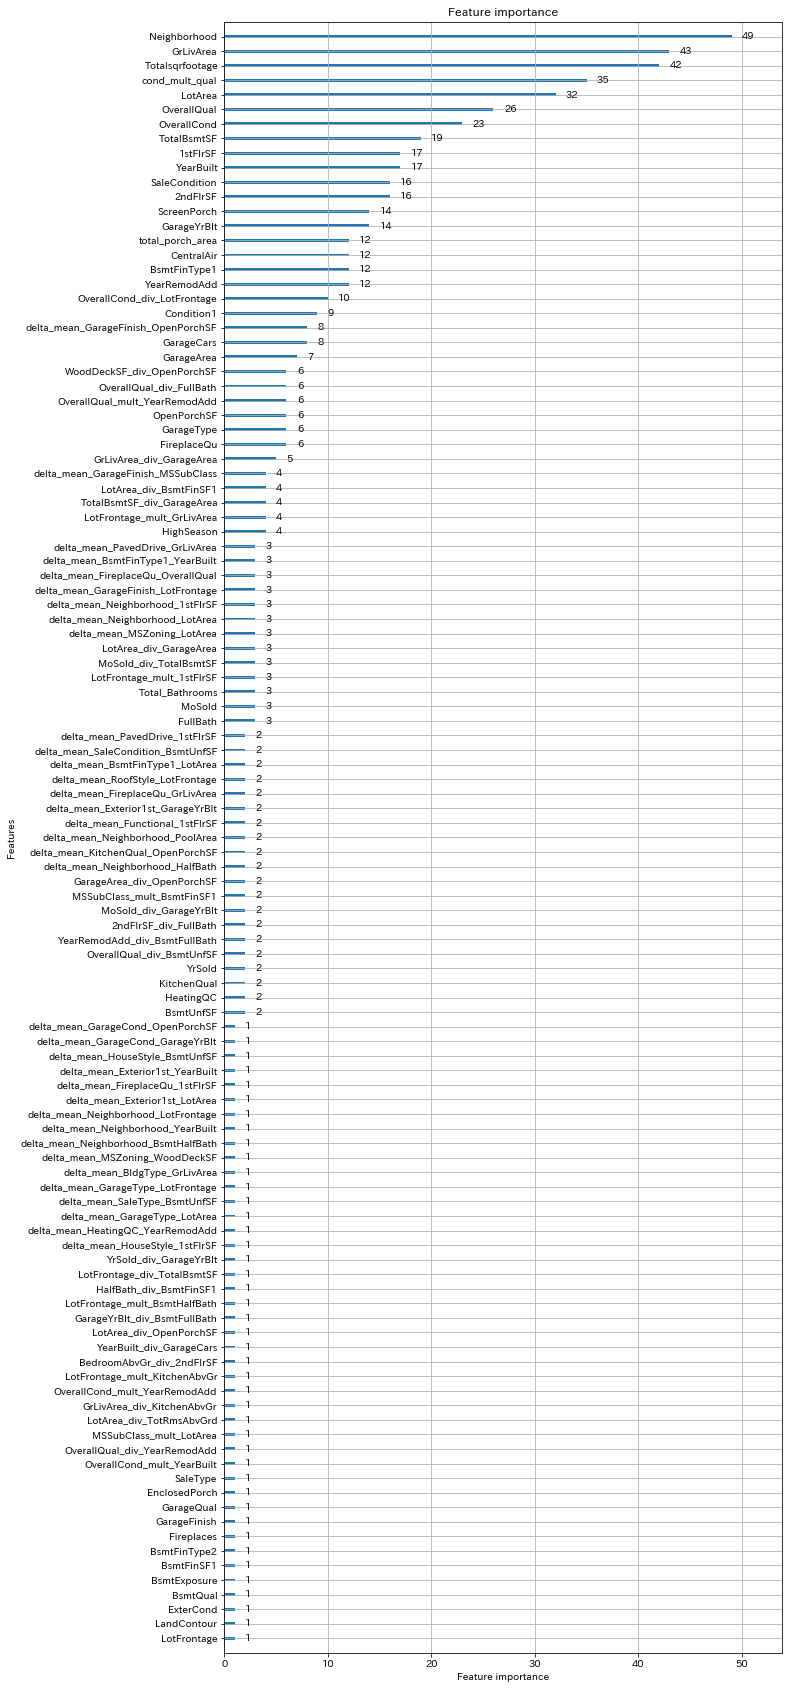

In [162]:
lgb.plot_importance(model, figsize=(10,30))

In [213]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
Neighborhood,66
Totalsqrfootage,65
GrLivArea,62
LotArea,55
cond_mult_qual,46
...,...
LowQualFinSF_div_TotalBsmtSF,0
YearRemodAdd_div_FullBath,0
MSSubClass_div_LotArea,0
GarageArea_div_OpenPorchSF,0


In [181]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

## 効いている特徴量のみにする。

In [223]:
data = pd.read_csv('../house price/alldata_007.csv')
data = pd.concat([data[importance.index[:65]], data['SalePrice']], sort=False, axis=1)
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[:len(train)]
test = data[len(train):]
categorical_cols = [f for f in data.columns if data.dtypes[f] == 'object']

In [224]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': 9,
        'num_leaves': 7,
        'learning_rate': 0.05,
        'max_bin': 424,
        'min_data_in_leaf': 23
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

(1460, 66) (1459, 66)


C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286027	valid_1's rmse: 0.279308
[20]	training's rmse: 0.216251	valid_1's rmse: 0.216124
[30]	training's rmse: 0.173652	valid_1's rmse: 0.180278
[40]	training's rmse: 0.147224	valid_1's rmse: 0.160982
[50]	training's rmse: 0.130571	valid_1's rmse: 0.150243
[60]	training's rmse: 0.11963	valid_1's rmse: 0.145173
[70]	training's rmse: 0.112328	valid_1's rmse: 0.142002
[80]	training's rmse: 0.10666	valid_1's rmse: 0.139954
[90]	training's rmse: 0.102477	valid_1's rmse: 0.139097
[100]	training's rmse: 0.0990696	valid_1's rmse: 0.138459
[110]	training's rmse: 0.0963003	valid_1's rmse: 0.138128
[120]	training's rmse: 0.093705	valid_1's rmse: 0.1376
[130]	training's rmse: 0.0911892	valid_1's rmse: 0.137088
[140]	training's rmse: 0.0891557	valid_1's rmse: 0.136362
[150]	training's rmse: 0.087272	valid_1's rmse: 0.136206
[160]	training's rmse: 0.0856237	valid_1's rmse: 0.136014
[170]	training's rmse: 0.0839094	va

In [206]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
Neighborhood,98
Totalsqrfootage,92
YearBuilt,91
LotArea,88
GrLivArea,86
cond_mult_qual,67
YearRemodAdd,57
TotalBsmtSF,57
OverallQual,55
total_porch_area,49


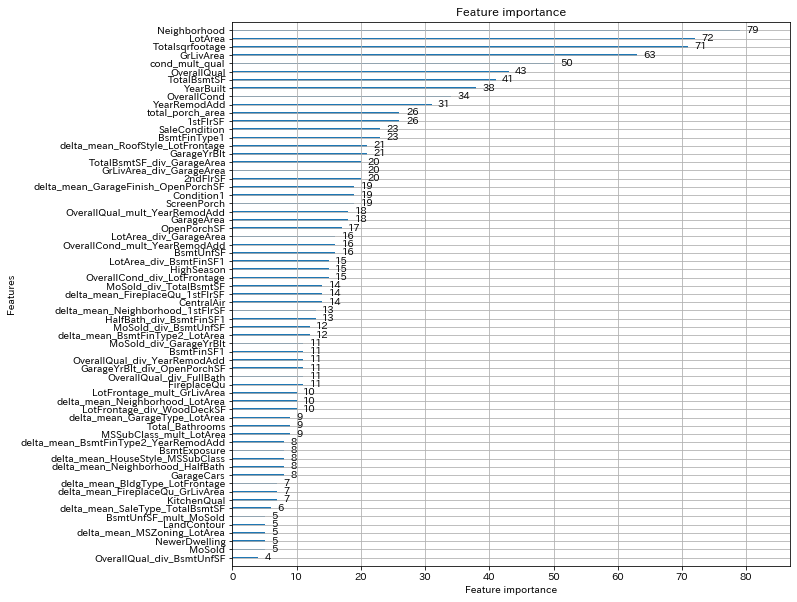

In [225]:
lgb.plot_importance(model, figsize=(10,10))

In [226]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 0.13391